# **Import Libraries**

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

# **<b>SALES DATA<b>**

# **Load sales Data**

In [2]:
# Load all sheets from the Sales Excel file
excel_sales = pd.read_excel('Sales Data.xlsx', sheet_name=None)

# Access each sheet by name and inspect the first few rows
sales_data = excel_sales['Sales']
distribution_data = excel_sales['Distribution']
shipment_data = excel_sales['Shipment']


### Raw data

In [3]:
# Iterate over each sheet and display the data in table format
for sheet_name, sheet_data in excel_sales.items():
    print(f"Sheet : {sheet_name}")
    display(sheet_data.head())  # Display the first 5 rows in table format
    print("\n")  # Add a blank line for separation

Sheet : Sales


Unnamed: 0 Value ('000 HKD) Unnamed: 2 Unnamed: 3 Unnamed: 4  \
0               Period            Brand         V1         V2         V3   
1  2011-07-01 00:00:00          28518.3    12706.5    12196.9     3614.4   
2  2011-08-01 00:00:00          31712.5    14190.5    13250.5     4271.6   
3  2011-09-01 00:00:00          28436.8    12422.5    11946.7     4067.6   
4  2011-10-01 00:00:00          29048.8    12652.5    12690.9     3705.5   

   Unnamed: 5 Volume (SU) Unnamed: 7 Unnamed: 8 Unnamed: 9  Unnamed: 10  \
0         NaN       Brand         V1         V2         V3          NaN   
1         NaN     85935.6    36127.4    40971.6     8835.6          NaN   
2         NaN     95135.2    40373.7    44402.1    10359.4          NaN   
3         NaN       85814    36034.5    40029.2     9750.3          NaN   
4         NaN     88047.7    36697.8    42431.3     8918.6          NaN   

  Avg Price per SU Unnamed: 12 Unnamed: 13 Unnamed: 14  Unnamed: 15  \
0            Brand          V1          V2          V3          NaN   
1       331.856646  351.713658  297.691572  409.072389          NaN   
2       333.341392  351.478809   298.42057  412.340483          NaN   
3       331.377165   344.73907  298.449632  417.176907          NaN   
4       329.921168  344.775436  299.092887  415.480008          NaN   

  Avg Price per USD Unnamed: 17 Unnamed: 18 Unnamed: 19  
0             Brand          V1          V2          V3  
1         43.141364   45.722776   38.699904   53.179411  
2         43.334381   45.692245   38.794674   53.604263  
3         43.079031   44.816079   38.798452   54.232998  
4         42.889752   44.820807   38.882075   54.012401



Sheet : Distribution


Unnamed: 0    WTD Unnamed: 2 Unnamed: 3 Unnamed: 4  Unnamed: 5  \
0               Period  Brand         V1         V2         V3         NaN   
1  2011-07-01 00:00:00    100        100         99         96         NaN   
2  2011-08-01 00:00:00    100         99         99         96         NaN   
3  2011-09-01 00:00:00    100         99         99         95         NaN   
4  2011-10-01 00:00:00     99         99         99         94         NaN   

    NUMD Unnamed: 7 Unnamed: 8 Unnamed: 9  
0  Brand         V1         V2         V3  
1     48         46         46         40  
2     48         46         46         40  
3     48         46         46         39  
4     48         46         46         38



Sheet : Shipment


Unnamed: 0  Shipment SU  Unnamed: 2  Unnamed: 3  Unnamed: 4  \
0               Period        Brand          V1          V2          V3   
1  2011-07-01 00:00:00   111110.765  43869.0272  59022.5266   8219.2112   
2  2011-08-01 00:00:00    98568.474   48970.128  40447.5286   9150.8174   
3  2011-09-01 00:00:00  122461.0034  54010.9639  58820.3602   9629.6793   
4  2011-10-01 00:00:00  134933.0212  60733.5058  63417.0106  10782.5048   

   Unnamed: 5 Volume (SU) Unnamed: 7 Unnamed: 8 Unnamed: 9  
0         NaN       Brand         V1         V2         V3  
1         NaN     85935.6    36127.4    40971.6     8835.6  
2         NaN     95135.2    40373.7    44402.1    10359.4  
3         NaN       85814    36034.5    40029.2     9750.3  
4         NaN     88047.7    36697.8    42431.3     8918.6

# **Data Preprocessing**

### Data Cleaning

In [4]:
def process_sheet(df):
    # Step 1: Rename row 1 columns based on previous columns, but leave 'Period' unchanged
    def fill_unnamed_columns(df):
        new_columns = []
        for i, col in enumerate(df.columns):
            if i == 0:
                new_columns.append("Period")
            elif 'Unnamed' in col:
                if df.iloc[:, i].notna().sum() > 0:
                    if len(new_columns) > 0:
                        new_columns.append(new_columns[-1])
                    else:
                        new_columns.append(col)
                else:
                    new_columns.append(col)
            else:
                if 'Value' in col:
                    new_columns.append('Value')
                elif 'Volume' in col:
                    new_columns.append('Volume')
                elif 'Shipment' in col:
                    new_columns.append('Shipment')
                else:
                    new_columns.append(col)
        return new_columns

    # Step 2: Combine the first two rows into column names but leave 'Period' unchanged
    def combine_first_two_rows_as_column_names(df):
        new_columns = []
        for i in range(len(df.columns)):
            row1_value = df.iloc[0, i]
            row2_value = df.columns[i].replace(" ", "_")
            if i == 0:
                new_columns.append("Period")
            elif pd.isna(row1_value):
                new_columns.append(row2_value)
            else:
                if 'Value' in row2_value:
                    new_columns.append(f"{row1_value}_Sales_{row2_value}")
                else:
                    new_columns.append(f"{row1_value}_{row2_value}")
        return new_columns

    df.columns = fill_unnamed_columns(df)
    df.columns = combine_first_two_rows_as_column_names(df)
    df = df.drop(0).reset_index(drop=True)
    df['Period'] = pd.to_datetime(df['Period'], errors='coerce')

    # Remove unnamed columns or empty columns
    df = df.loc[:, ~df.columns.str.contains('^Unnamed') & ~df.isnull().all()]
    return df


In [5]:
sales_df = process_sheet(sales_data)
distribution_df = process_sheet(distribution_data)
shipment_df = process_sheet(shipment_data)

# Drop unnecessary columns from the 'Shipment' sheet in place
shipment_df.drop(columns=['Brand_Volume', 'V1_Volume', 'V2_Volume', 'V3_Volume'], inplace=True)


## After Data Cleaning

### Sales data

In [6]:
sales_df.head()


Period Brand_Sales_Value V1_Sales_Value V2_Sales_Value V3_Sales_Value  \
0 2011-07-01           28518.3        12706.5        12196.9         3614.4   
1 2011-08-01           31712.5        14190.5        13250.5         4271.6   
2 2011-09-01           28436.8        12422.5        11946.7         4067.6   
3 2011-10-01           29048.8        12652.5        12690.9         3705.5   
4 2011-11-01          30463.54       13737.66       12723.97         4001.9   

  Brand_Volume V1_Volume V2_Volume V3_Volume Brand_Avg_Price_per_SU  \
0      85935.6   36127.4   40971.6    8835.6             331.856646   
1      95135.2   40373.7   44402.1   10359.4             333.341392   
2        85814   36034.5   40029.2    9750.3             331.377165   
3      88047.7   36697.8   42431.3    8918.6             329.921168   
4     92028.93   39742.8     42395   9891.13             331.021343   

  V1_Avg_Price_per_SU V2_Avg_Price_per_SU V3_Avg_Price_per_SU  \
0          351.713658          297.691572          409.072389   
1          351.478809           298.42057          412.340483   
2           344.73907          298.449632          417.176907   
3          344.775436          299.092887          415.480008   
4           345.66412          300.129025          404.594824   

  Brand_Avg_Price_per_USD V1_Avg_Price_per_USD V2_Avg_Price_per_USD  \
0               43.141364            45.722776            38.699904   
1               43.334381            45.692245            38.794674   
2               43.079031            44.816079            38.798452   
3               42.889752            44.820807            38.882075   
4               43.032775            44.936336            39.016773   

  V3_Avg_Price_per_USD  
0            53.179411  
1            53.604263  
2            54.232998  
3            54.012401  
4            52.597327

### Distribution data 

In [7]:
distribution_df.head()

Period Brand_WTD V1_WTD V2_WTD V3_WTD Brand_NUMD V1_NUMD V2_NUMD V3_NUMD
0 2011-07-01       100    100     99     96         48      46      46      40
1 2011-08-01       100     99     99     96         48      46      46      40
2 2011-09-01       100     99     99     95         48      46      46      39
3 2011-10-01        99     99     99     94         48      46      46      38
4 2011-11-01       100    100     99     93         48      46      45      39

### Shipment data

In [8]:
shipment_df.head()

Period Brand_Shipment V1_Shipment V2_Shipment V3_Shipment
0 2011-07-01     111110.765  43869.0272  59022.5266   8219.2112
1 2011-08-01      98568.474   48970.128  40447.5286   9150.8174
2 2011-09-01    122461.0034  54010.9639  58820.3602   9629.6793
3 2011-10-01    134933.0212  60733.5058  63417.0106  10782.5048
4 2011-11-01    122066.2618  52525.5475  60432.8513    9107.863

### Merge Sales,Distribution and Shipment Data

In [9]:
# Perform left joins on the 'Period' column
final_sales_data = sales_df.merge(distribution_df, on='Period', how='left') \
                     .merge(shipment_df, on='Period', how='left')


In [10]:
final_sales_data.head()

Period Brand_Sales_Value V1_Sales_Value V2_Sales_Value V3_Sales_Value  \
0 2011-07-01           28518.3        12706.5        12196.9         3614.4   
1 2011-08-01           31712.5        14190.5        13250.5         4271.6   
2 2011-09-01           28436.8        12422.5        11946.7         4067.6   
3 2011-10-01           29048.8        12652.5        12690.9         3705.5   
4 2011-11-01          30463.54       13737.66       12723.97         4001.9   

  Brand_Volume V1_Volume V2_Volume V3_Volume Brand_Avg_Price_per_SU  ...  \
0      85935.6   36127.4   40971.6    8835.6             331.856646  ...   
1      95135.2   40373.7   44402.1   10359.4             333.341392  ...   
2        85814   36034.5   40029.2    9750.3             331.377165  ...   
3      88047.7   36697.8   42431.3    8918.6             329.921168  ...   
4     92028.93   39742.8     42395   9891.13             331.021343  ...   

  V2_WTD V3_WTD Brand_NUMD V1_NUMD V2_NUMD V3_NUMD Brand_Shipment V1_Shipment  \
0     99     96         48      46      46      40     111110.765  43869.0272   
1     99     96         48      46      46      40      98568.474   48970.128   
2     99     95         48      46      46      39    122461.0034  54010.9639   
3     99     94         48      46      46      38    134933.0212  60733.5058   
4     99     93         48      46      45      39    122066.2618  52525.5475   

  V2_Shipment V3_Shipment  
0  59022.5266   8219.2112  
1  40447.5286   9150.8174  
2  58820.3602   9629.6793  
3  63417.0106  10782.5048  
4  60432.8513    9107.863  

[5 rows x 29 columns]

In [11]:
final_sales_data.shape

(41, 29)

# **<b>MEDIA DATA<b>**

# **Load Media data**

In [12]:
file_path='Media_Data.xlsx'

# Load all sheets from the Media Excel file
excel_media = pd.read_excel(file_path, sheet_name=None)

brand_data = pd.read_excel(file_path, sheet_name='Brand')
v1_data = pd.read_excel(file_path, sheet_name='V1')
v2_data = pd.read_excel(file_path, sheet_name='V2')
v3_data= pd.read_excel(file_path, sheet_name='V3')

# **Raw data**

In [13]:
# Iterate over each sheet and display the data in table format
for sheet_name, sheet_data in excel_media.items():
    print(f"Sheet : {sheet_name}")
    display(sheet_data.head())  # Display the first 5 rows in table format
    print("\n")  # Add a blank line for separation

Sheet : Brand


Unnamed: 0 TV including ISP (GRPs) - F30-39    Unnamed: 2  \
0                  NaN          TOTAL GRPs - (ISP + TV)  ISP TV Total   
1                 Unit                              GRP           GRP   
2       Responsibility                              AOR           AOR   
3  2010-01-01 00:00:00                              NaN           NaN   
4  2010-02-02 00:00:00                              NaN           NaN   

          Unnamed: 3   Unnamed: 4    Unnamed: 5    Unnamed: 6    Unnamed: 7  \
0  ISP Digital Total  5 Seconder   10 Seconder   15 Seconder   20 Seconder    
1                GRP          GRP           GRP           GRP           GRP   
2                AOR          AOR           AOR           AOR           AOR   
3                NaN          NaN           NaN           NaN           NaN   
4                NaN          NaN           NaN           NaN           NaN   

     Unnamed: 8    Unnamed: 9  ...              Trial Sampling  \
0  25 Seconder   30 Seconder   ...  Pls add all Trial Elements   
1           GRP           GRP  ...                         NaN   
2           AOR           AOR  ...                         P&G   
3           NaN           NaN  ...                         NaN   
4           NaN           NaN  ...                         NaN   

                        Promotion Unnamed: 211 Unnamed: 212 Unnamed: 213  \
0  Pls add all Promotion Elements          NaN          NaN          NaN   
1                             NaN          NaN          NaN          NaN   
2                             P&G          NaN          NaN          NaN   
3                             NaN          NaN          NaN          NaN   
4                             NaN          NaN          NaN          NaN   

  Unnamed: 214 Unnamed: 215 Unnamed: 216 Unnamed: 217 Unnamed: 218  
0          NaN          NaN          NaN          NaN          NaN  
1          NaN          NaN          NaN          NaN          NaN  
2          NaN          NaN          NaN          NaN          NaN  
3          NaN          NaN          NaN          NaN          NaN  
4          NaN          NaN          NaN          NaN          NaN  

[5 rows x 219 columns]



Sheet : V1


Unnamed: 0       TV (GRPs) - F30-39    Unnamed: 2  \
0                  NaN  TOTAL GRPs - (ISP + TV)  ISP TV Total   
1                 Unit                      GRP           GRP   
2       Responsibility                      AOR           AOR   
3  2010-01-01 00:00:00                        0             0   
4  2010-02-02 00:00:00                        0             0   

          Unnamed: 3   Unnamed: 4    Unnamed: 5    Unnamed: 6    Unnamed: 7  \
0  ISP Digital Total  5 Seconder   10 Seconder   15 Seconder   20 Seconder    
1                GRP          GRP           GRP           GRP           GRP   
2                AOR          AOR           AOR           AOR           AOR   
3                  0            0             0             0             0   
4                  0            0             0             0             0   

     Unnamed: 8    Unnamed: 9  ... Ecommerce Unnamed: 206      Unnamed: 207  \
0  25 Seconder   30 Seconder   ...   Offtake     Traffic   Conversion rate    
1           GRP           GRP  ...      NT$M          NaN               NaN   
2           AOR           AOR  ...       P&G          P&G               P&G   
3             0             0  ...       NaN          NaN               NaN   
4             0             0  ...       NaN          NaN               NaN   

  Ecommerce\n(Spends)              Trial Sampling  \
0             Offtake  Pls add all Trial Elements   
1                NT$M                         NaN   
2                 P&G                         P&G   
3                 NaN                         NaN   
4                 NaN                         NaN   

                        Promotion Unnamed: 211 Unnamed: 212 Unnamed: 213  \
0  Pls add all Promotion Elements          NaN          NaN          NaN   
1                             NaN          NaN          NaN          NaN   
2                             P&G          NaN          NaN          NaN   
3                             NaN          NaN          NaN          NaN   
4                             NaN          NaN          NaN          NaN   

  Unnamed: 214  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  

[5 rows x 215 columns]



Sheet : V2


Unnamed: 0       TV (GRPs) - F30-39    Unnamed: 2  \
0                  NaN  TOTAL GRPs - (ISP + TV)  ISP TV Total   
1                 Unit                      GRP           GRP   
2       Responsibility                      AOR           AOR   
3  2010-01-01 00:00:00                      975           975   
4  2010-02-02 00:00:00                      835           835   

          Unnamed: 3   Unnamed: 4    Unnamed: 5    Unnamed: 6    Unnamed: 7  \
0  ISP Digital Total  5 Seconder   10 Seconder   15 Seconder   20 Seconder    
1                GRP          GRP           GRP           GRP           GRP   
2                AOR          AOR           AOR           AOR           AOR   
3                  0            0             0             0             0   
4                  0            0             0             0             0   

     Unnamed: 8    Unnamed: 9  ... Ecommerce Unnamed: 206      Unnamed: 207  \
0  25 Seconder   30 Seconder   ...   Offtake     Traffic   Conversion rate    
1           GRP           GRP  ...      NT$M          NaN               NaN   
2           AOR           AOR  ...       P&G          P&G               P&G   
3             0           975  ...       NaN          NaN               NaN   
4             0           835  ...       NaN          NaN               NaN   

  Ecommerce\n(Spends)              Trial Sampling  \
0             Offtake  Pls add all Trial Elements   
1                NT$M                         NaN   
2                 P&G                         P&G   
3                 NaN                         NaN   
4                 NaN                         NaN   

                        Promotion Unnamed: 211 Unnamed: 212 Unnamed: 213  \
0  Pls add all Promotion Elements          NaN          NaN          NaN   
1                             NaN          NaN          NaN          NaN   
2                             P&G          NaN          NaN          NaN   
3                             NaN          NaN          NaN          NaN   
4                             NaN          NaN          NaN          NaN   

  Unnamed: 214  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  

[5 rows x 215 columns]



Sheet : V3


Unnamed: 0       TV (GRPs) - F30-39    Unnamed: 2  \
0                  NaN  TOTAL GRPs - (ISP + TV)  ISP TV Total   
1                 Unit                      GRP           GRP   
2       Responsibility                      AOR           AOR   
3  2010-01-01 00:00:00                        0             0   
4  2010-02-02 00:00:00                        0             0   

          Unnamed: 3   Unnamed: 4    Unnamed: 5    Unnamed: 6    Unnamed: 7  \
0  ISP Digital Total  5 Seconder   10 Seconder   15 Seconder   20 Seconder    
1                GRP          GRP           GRP           GRP           GRP   
2                AOR          AOR           AOR           AOR           AOR   
3                  0            0             0             0             0   
4                  0            0             0             0             0   

     Unnamed: 8    Unnamed: 9  ... Ecommerce Unnamed: 206      Unnamed: 207  \
0  25 Seconder   30 Seconder   ...   Offtake     Traffic   Conversion rate    
1           GRP           GRP  ...      NT$M          NaN               NaN   
2           AOR           AOR  ...       P&G          P&G               P&G   
3             0             0  ...       NaN          NaN               NaN   
4             0             0  ...       NaN          NaN               NaN   

  Ecommerce\n(Spends)              Trial Sampling  \
0             Offtake  Pls add all Trial Elements   
1                NT$M                         NaN   
2                 P&G                         P&G   
3                 NaN                         NaN   
4                 NaN                         NaN   

                        Promotion Unnamed: 211 Unnamed: 212 Unnamed: 213  \
0  Pls add all Promotion Elements          NaN          NaN          NaN   
1                             NaN          NaN          NaN          NaN   
2                             P&G          NaN          NaN          NaN   
3                             NaN          NaN          NaN          NaN   
4                             NaN          NaN          NaN          NaN   

  Unnamed: 214  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  

[5 rows x 215 columns]

# **Data Preprocessing**

## Data Cleaning

#### <b> Rename row 1 columns based on previous columns, but leave 'Period' unchanged <b>

In [14]:
# Step 1: Rename row 1 columns based on previous columns, but leave 'Period' unchanged
def fill_unnamed_columns(df):
    new_columns = []
    for i, col in enumerate(df.columns):
        if i == 0:
            new_columns.append("Period")  # Keep 'Period' column as is
        elif 'Unnamed' in col:
            if df.iloc[:, i].notna().sum() > 0:
                # Use the previous column name if available
                if len(new_columns) > 0:
                    new_columns.append(new_columns[-1])
                else:
                    new_columns.append(col)
            else:
                new_columns.append(col)
        else:
            new_columns.append(col)

    return new_columns
for i in [brand_data,v1_data,v2_data,v3_data]:
    i.columns = fill_unnamed_columns(i)


In [15]:
def filter_df(df):
    # Rename the first column to 'Period'
    df.columns.values[0] = 'Period'
    
    # Convert 'Period' to datetime; specify the format if known
    df['Period'] = pd.to_datetime(df['Period'], errors='coerce', format='%Y-%m-%d')  # Change format as per your data
    
    # Define the date range for filtering
    start_date = pd.to_datetime('2011-06-29')
    end_date = pd.to_datetime('2014-06-01')
    
    # Get the first three rows as they are
    first_three_rows = df.head(3)
    
    # Filter the DataFrame by date range
    df_filtered = df[(df['Period'] >= start_date) & (df['Period'] <= end_date)]
    
    # Concatenate the first three rows with the filtered DataFrame
    result_df = pd.concat([first_three_rows, df_filtered]).drop_duplicates().reset_index(drop=True)
    
    # Update all dates to be the first of their respective month
    result_df['Period'] = result_df['Period'].apply(lambda x: x.replace(day=1) if pd.notnull(x) else x)

    
    return result_df

brand_df = filter_df(brand_data)
v1_df=filter_df(v1_data)
v2_df=filter_df(v2_data)
v3_df=filter_df(v3_data)

#### <b> Retaining Columns with ≥ 60% Data Completeness <b>

In [16]:
def filter_columns(df):
    # Replace '-' with NaN to consider it as a null value
    df = df.replace(0, np.nan)
    
    # Get the number of rows excluding the first three
    num_rows_excluding_first_three = len(df) - 3
    
    # Calculate the threshold for non-null values (60%)
    threshold = 0.6* num_rows_excluding_first_three
    
    # Filter columns based on the threshold
    df_filtered = df.loc[:, df.notnull().sum() > threshold]
    
    return df_filtered

# Apply the function to each DataFrame
brand_df = filter_columns(brand_df)
v1_df = filter_columns(v1_df)
v2_df = filter_columns(v2_df)
v3_df = filter_columns(v3_df)

In [17]:
print("Brand data shape : ",brand_df.shape,"\n","V1 Shape : ",v1_df.shape,"\n","V2 Shape : ",v2_df.shape,"\n","V1 Shape : ",v2_df.shape)

Brand data shape :  (40, 9) 
 V1 Shape :  (40, 14) 
 V2 Shape :  (40, 1) 
 V1 Shape :  (40, 1)


V2 & V3 sheet has no columns which has minimum 60% of non NaN values. SO, V2 & V3 are completely dropped.

#### <b> Rename Brand data column names <b>

In [18]:
# Drop the first 4 rows
brand_df = brand_df.iloc[4:].reset_index(drop=True)

# Rename the columns
brand_df.columns = [
    'Period',
    'Brand_Search_SEM_YahooAlwaysON_Imp_Dgtl',
    'Brand_Search_SEM_YahooAlwaysON_Clks_Dgtl',
    'Brand_Search_YahooAlwaysON_Spends_Dgtl',
    'Brand_SocialAd_fbAd_Likes_Dgtl',
    'Brand_SocialAd_fbAd_PTAT_Dgtl',
    'Brand_BirthRate_noOfBirths_ppl_CPA',
    'Brand_YoutubeBrandChannel_sideBySideVideo_Views',
    'Brand_CRM_PampersBabyClub'
]

# Display the resulting dataframe
brand_df.head()

Period Brand_Search_SEM_YahooAlwaysON_Imp_Dgtl  \
0 2011-07-01                                66442189   
1 2011-08-01                                74218274   
2 2011-09-01                                62093623   
3 2011-10-01                                55363384   
4 2011-11-01                                58743642   

  Brand_Search_SEM_YahooAlwaysON_Clks_Dgtl  \
0                                    24418   
1                                    23888   
2                                    22417   
3                                    18600   
4                                    21662   

  Brand_Search_YahooAlwaysON_Spends_Dgtl Brand_SocialAd_fbAd_Likes_Dgtl  \
0                               5.037171                          74109   
1                               4.619848                          75408   
2                               4.624386                          77106   
3                               3.597169                          77227   
4                               4.457098                          77366   

  Brand_SocialAd_fbAd_PTAT_Dgtl Brand_BirthRate_noOfBirths_ppl_CPA  \
0                    172.133333                               8128   
1                  76277.064516                               8531   
2                  77099.533333                               8099   
3                  77205.258065                               8352   
4                  77464.533333                               7816   

  Brand_YoutubeBrandChannel_sideBySideVideo_Views Brand_CRM_PampersBabyClub  
0                                             NaN                 40.458478  
1                                             NaN                 22.657005  
2                                             NaN                 22.240559  
3                                             NaN                 26.985212  
4                                             NaN                 41.319185

#### <b> Rename V1 data column names <b>

In [19]:
v1_df = v1_df.iloc[4:].reset_index(drop=True)
v1_df.columns=[
    'Period',
    'V1_TV_Total_ISP&TV_GRP_AOR',
    'V1_TV_Total_ISP_GRP_AOR',
    'V1_TV_Total_ISP&TV_Spends_AOR',
    'V1_TV_ISP_Spends_AOR',
    'V1_IMedia_Total_Imp_Dgtl',
    'V1_IMedia_Total_Clks_Dgtl',
    'V1_IMediaBySiteType_PS_BBK_Imp_Dgtl',
    'V1_IMediaBySiteType_PS_BBK_Clks_Dgtl',
    'V1_IMediaBySite_BBK_Imp_Dgtl',
    'V1_IMediaBySite_BBK_Clks_Dgtl',
    'V1_IMedia_Total_Spends_Dgtl',
    'V1_IMediaBySiteType_PS_BBK_Spends_Dgtl',
    'V1_IMediaBySite_BBK_Spends_Dgtl'   
]
v1_df.head()

Period V1_TV_Total_ISP&TV_GRP_AOR V1_TV_Total_ISP_GRP_AOR  \
0 2011-07-01                        200                     200   
1 2011-08-01                        100                     100   
2 2011-09-01                        100                     100   
3 2011-10-01                         91                      91   
4 2011-11-01                        686                     686   

  V1_TV_Total_ISP&TV_Spends_AOR V1_TV_ISP_Spends_AOR V1_IMedia_Total_Imp_Dgtl  \
0                       9.17844              9.17844                  2108173   
1                      3.856487             3.856487                   507787   
2                      5.321952             5.321952                  3076266   
3                      3.856487             3.856487                  3250974   
4                     47.161647            47.161647                   867203   

  V1_IMedia_Total_Clks_Dgtl V1_IMediaBySiteType_PS_BBK_Imp_Dgtl  \
0                      2549                             2108173   
1                       357                              507787   
2                      2077                             3076266   
3                      2130                             3250974   
4                      1743                              867203   

  V1_IMediaBySiteType_PS_BBK_Clks_Dgtl V1_IMediaBySite_BBK_Imp_Dgtl  \
0                                 2549                      2108173   
1                                  357                       507787   
2                                 2077                      3076266   
3                                 2130                      3250974   
4                                 1743                       867203   

  V1_IMediaBySite_BBK_Clks_Dgtl V1_IMedia_Total_Spends_Dgtl  \
0                          2549                   14.182385   
1                           357                    0.703259   
2                          2077                    7.032588   
3                          2130                   10.314462   
4                          1743                    5.127854   

  V1_IMediaBySiteType_PS_BBK_Spends_Dgtl V1_IMediaBySite_BBK_Spends_Dgtl  
0                              14.182385                       14.182385  
1                               0.703259                        0.703259  
2                               7.032588                        7.032588  
3                              10.314462                       10.314462  
4                               5.127854                        5.127854

#### <b> Merging Brand and V1 <b>

In [20]:
final_Media_data = brand_df.merge(v1_df, on='Period', how='left')       

In [21]:
final_Media_data.shape

(36, 22)

In [22]:
final_Media_data.head()

Period Brand_Search_SEM_YahooAlwaysON_Imp_Dgtl  \
0 2011-07-01                                66442189   
1 2011-08-01                                74218274   
2 2011-09-01                                62093623   
3 2011-10-01                                55363384   
4 2011-11-01                                58743642   

  Brand_Search_SEM_YahooAlwaysON_Clks_Dgtl  \
0                                    24418   
1                                    23888   
2                                    22417   
3                                    18600   
4                                    21662   

  Brand_Search_YahooAlwaysON_Spends_Dgtl Brand_SocialAd_fbAd_Likes_Dgtl  \
0                               5.037171                          74109   
1                               4.619848                          75408   
2                               4.624386                          77106   
3                               3.597169                          77227   
4                               4.457098                          77366   

  Brand_SocialAd_fbAd_PTAT_Dgtl Brand_BirthRate_noOfBirths_ppl_CPA  \
0                    172.133333                               8128   
1                  76277.064516                               8531   
2                  77099.533333                               8099   
3                  77205.258065                               8352   
4                  77464.533333                               7816   

  Brand_YoutubeBrandChannel_sideBySideVideo_Views Brand_CRM_PampersBabyClub  \
0                                             NaN                 40.458478   
1                                             NaN                 22.657005   
2                                             NaN                 22.240559   
3                                             NaN                 26.985212   
4                                             NaN                 41.319185   

  V1_TV_Total_ISP&TV_GRP_AOR  ... V1_TV_ISP_Spends_AOR  \
0                        200  ...              9.17844   
1                        100  ...             3.856487   
2                        100  ...             5.321952   
3                         91  ...             3.856487   
4                        686  ...            47.161647   

  V1_IMedia_Total_Imp_Dgtl V1_IMedia_Total_Clks_Dgtl  \
0                  2108173                      2549   
1                   507787                       357   
2                  3076266                      2077   
3                  3250974                      2130   
4                   867203                      1743   

  V1_IMediaBySiteType_PS_BBK_Imp_Dgtl V1_IMediaBySiteType_PS_BBK_Clks_Dgtl  \
0                             2108173                                 2549   
1                              507787                                  357   
2                             3076266                                 2077   
3                             3250974                                 2130   
4                              867203                                 1743   

  V1_IMediaBySite_BBK_Imp_Dgtl V1_IMediaBySite_BBK_Clks_Dgtl  \
0                      2108173                          2549   
1                       507787                           357   
2                      3076266                          2077   
3                      3250974                          2130   
4                       867203                          1743   

  V1_IMedia_Total_Spends_Dgtl V1_IMediaBySiteType_PS_BBK_Spends_Dgtl  \
0                   14.182385                              14.182385   
1                    0.703259                               0.703259   
2                    7.032588                               7.032588   
3                   10.314462                              10.314462   
4                    5.127854                               5.127854   

  V1_IMediaBySite_BBK_Spends_Dgtl  
0                       14.182385  


# <b>Merge Cleaned Sales Data and Cleaned Media Data<b>

In [23]:
# Merge Brand_data_cleaned and V1_data_cleaned on 'Period'
final_data = pd.merge(final_sales_data, final_Media_data, on='Period', how='left')

# Save final_data to an Excel file
final_data.to_excel('final_data.xlsx', index=False)


In [24]:
final_data.head()

Period Brand_Sales_Value V1_Sales_Value V2_Sales_Value V3_Sales_Value  \
0 2011-07-01           28518.3        12706.5        12196.9         3614.4   
1 2011-08-01           31712.5        14190.5        13250.5         4271.6   
2 2011-09-01           28436.8        12422.5        11946.7         4067.6   
3 2011-10-01           29048.8        12652.5        12690.9         3705.5   
4 2011-11-01          30463.54       13737.66       12723.97         4001.9   

  Brand_Volume V1_Volume V2_Volume V3_Volume Brand_Avg_Price_per_SU  ...  \
0      85935.6   36127.4   40971.6    8835.6             331.856646  ...   
1      95135.2   40373.7   44402.1   10359.4             333.341392  ...   
2        85814   36034.5   40029.2    9750.3             331.377165  ...   
3      88047.7   36697.8   42431.3    8918.6             329.921168  ...   
4     92028.93   39742.8     42395   9891.13             331.021343  ...   

  V1_TV_ISP_Spends_AOR V1_IMedia_Total_Imp_Dgtl V1_IMedia_Total_Clks_Dgtl  \
0              9.17844                  2108173                      2549   
1             3.856487                   507787                       357   
2             5.321952                  3076266                      2077   
3             3.856487                  3250974                      2130   
4            47.161647                   867203                      1743   

  V1_IMediaBySiteType_PS_BBK_Imp_Dgtl V1_IMediaBySiteType_PS_BBK_Clks_Dgtl  \
0                             2108173                                 2549   
1                              507787                                  357   
2                             3076266                                 2077   
3                             3250974                                 2130   
4                              867203                                 1743   

  V1_IMediaBySite_BBK_Imp_Dgtl V1_IMediaBySite_BBK_Clks_Dgtl  \
0                      2108173                          2549   
1                       507787                           357   
2                      3076266                          2077   
3                      3250974                          2130   
4                       867203                          1743   

  V1_IMedia_Total_Spends_Dgtl V1_IMediaBySiteType_PS_BBK_Spends_Dgtl  \
0                   14.182385                              14.182385   
1                    0.703259                               0.703259   
2                    7.032588                               7.032588   
3                   10.314462                              10.314462   
4                    5.127854                               5.127854   

  V1_IMediaBySite_BBK_Spends_Dgtl  
0                       14.182385  
1                        0.703259  
2                        7.032588  
3                       10.314462  
4                        5.127854  

[5 rows x 50 columns]

In [25]:
final_data.shape

(41, 50)

# **Exploratory Data Analysis**

In [26]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 50 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   Period                                           41 non-null     datetime64[ns]
 1   Brand_Sales_Value                                41 non-null     object        
 2   V1_Sales_Value                                   41 non-null     object        
 3   V2_Sales_Value                                   41 non-null     object        
 4   V3_Sales_Value                                   41 non-null     object        
 5   Brand_Volume                                     41 non-null     object        
 6   V1_Volume                                        41 non-null     object        
 7   V2_Volume                                        41 non-null     object        
 8   V3_Volume                                 

In [27]:
final_data.isnull().sum()

Period                                              0
Brand_Sales_Value                                   0
V1_Sales_Value                                      0
V2_Sales_Value                                      0
V3_Sales_Value                                      0
Brand_Volume                                        0
V1_Volume                                           0
V2_Volume                                           0
V3_Volume                                           0
Brand_Avg_Price_per_SU                              0
V1_Avg_Price_per_SU                                 0
V2_Avg_Price_per_SU                                 0
V3_Avg_Price_per_SU                                 0
Brand_Avg_Price_per_USD                             0
V1_Avg_Price_per_USD                                0
V2_Avg_Price_per_USD                                0
V3_Avg_Price_per_USD                                0
Brand_WTD                                           0
V1_WTD                      

In [28]:
# First, apply forward fill to fill most missing values
final_data.fillna(method='ffill', inplace=True)

# Then, apply backward fill to handle any remaining missing values
final_data.fillna(method='bfill', inplace=True)

# Check for any remaining missing values
print("Remaining missing values after forward and backward fill:\n", final_data.isnull().sum())


Remaining missing values after forward and backward fill:
 Period                                             0
Brand_Sales_Value                                  0
V1_Sales_Value                                     0
V2_Sales_Value                                     0
V3_Sales_Value                                     0
Brand_Volume                                       0
V1_Volume                                          0
V2_Volume                                          0
V3_Volume                                          0
Brand_Avg_Price_per_SU                             0
V1_Avg_Price_per_SU                                0
V2_Avg_Price_per_SU                                0
V3_Avg_Price_per_SU                                0
Brand_Avg_Price_per_USD                            0
V1_Avg_Price_per_USD                               0
V2_Avg_Price_per_USD                               0
V3_Avg_Price_per_USD                               0
Brand_WTD                               

C:\Users\vaish\AppData\Local\Temp\ipykernel_7216\2848202812.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_data.fillna(method='ffill', inplace=True)
C:\Users\vaish\AppData\Local\Temp\ipykernel_7216\2848202812.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_data.fillna(method='bfill', inplace=True)


#### <b>Descriptive statistics<b>

In [29]:
final_data.describe()

Period  Brand_Sales_Value  V1_Sales_Value  \
count                             41          41.000000       41.000000   
mean   2013-03-01 20:29:16.097561088       38379.313902    17890.832683   
min              2011-07-01 00:00:00       28436.800000    12422.500000   
25%              2012-05-01 00:00:00       35746.670000    16154.000000   
50%              2013-03-01 00:00:00       38711.490000    18054.970000   
75%              2014-01-01 00:00:00       41766.940000    19764.630000   
max              2014-11-01 00:00:00       46926.170000    22749.220000   
std                              NaN        4741.210138     2649.936210   

       V2_Sales_Value  V3_Sales_Value   Brand_Volume     V1_Volume  \
count       41.000000       41.000000      41.000000     41.000000   
mean     15149.017073     5339.454878  107378.072439  49329.040732   
min      11946.700000     3614.400000   85814.000000  36034.500000   
25%      14246.370000     4455.510000   99598.590000  44838.660000   
50%      15504.090000     5247.830000  108255.480000  48281.830000   
75%      16205.310000     6272.480000  115667.680000  55182.760000   
max      17594.810000     7515.340000  128288.770000  63628.410000   
std       1449.530193     1090.575979   11222.528686   7196.255873   

          V2_Volume     V3_Volume  Brand_Avg_Price_per_SU  ...  \
count     41.000000     41.000000               41.000000  ...   
mean   46256.017073  11792.987561              356.788095  ...   
min    40029.200000   8574.870000              329.921168  ...   
25%    43191.570000  10076.510000              354.305695  ...   
50%    46735.730000  11537.200000              360.673267  ...   
75%    48933.140000  13328.580000              364.059630  ...   
max    52747.340000  16314.090000              374.603470  ...   
std     3558.156471   2130.397844               12.476360  ...   

       V1_TV_ISP_Spends_AOR  V1_IMedia_Total_Imp_Dgtl  \
count             41.000000              4.100000e+01   
mean              21.376418              5.203598e+06   
min                3.856487              5.077870e+05   
25%               14.717568              1.509125e+06   
50%               16.868417              4.069701e+06   
75%               28.019365              8.194711e+06   
max               47.161647              1.521348e+07   
std               11.951686              4.203017e+06   

       V1_IMedia_Total_Clks_Dgtl  V1_IMediaBySiteType_PS_BBK_Imp_Dgtl  \
count                  41.000000                         4.100000e+01   
mean                 9591.618467                         4.526014e+06   
min                   191.500000                         5.077870e+05   
25%                  2077.000000                         1.509125e+06   
50%                  7325.000000                         3.250974e+06   
75%                 14871.500000                         5.515397e+06   
max                 60041.000000                         1.466634e+07   
std                 12596.502346                         3.986699e+06   

       V1_IMediaBySiteType_PS_BBK_Clks_Dgtl  V1_IMediaBySite_BBK_Imp_Dgtl  \
count                             41.000000                  4.100000e+01   
mean                            6782.929268                  4.526014e+06   
min                              191.500000                  5.077870e+05   
25%                             1786.000000                  1.509125e+06   
50%                             5314.000000                  3.250974e+06   
75%                             9617.000000                  5.515397e+06   
max                            15801.000000                  1.466634e+07   
std                             5635.565032                  3.986699e+06   

       V1_IMediaBySite_BBK_Clks_Dgtl  V1_IMedia_Total_Spends_Dgtl  \
count                      41.000000                    41.000000   
mean                     6782.929268                    16.513475   
min                       191.500000                   

#### <b>Time Series Trends Comparison: (Sales Value,Avg Price, WTD, NUMD, Shipment)<b>

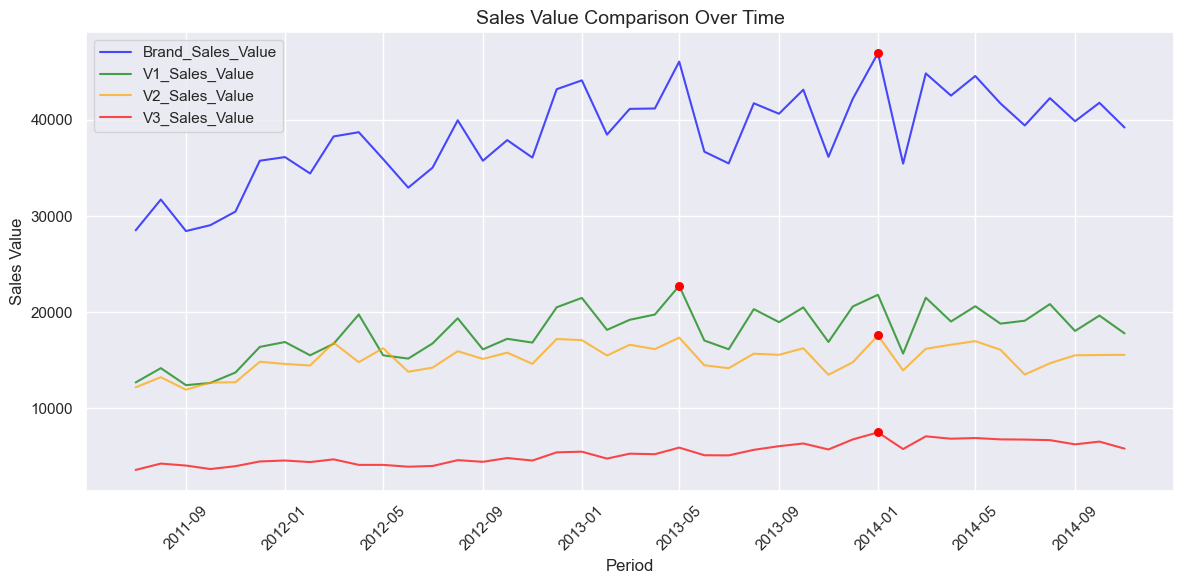

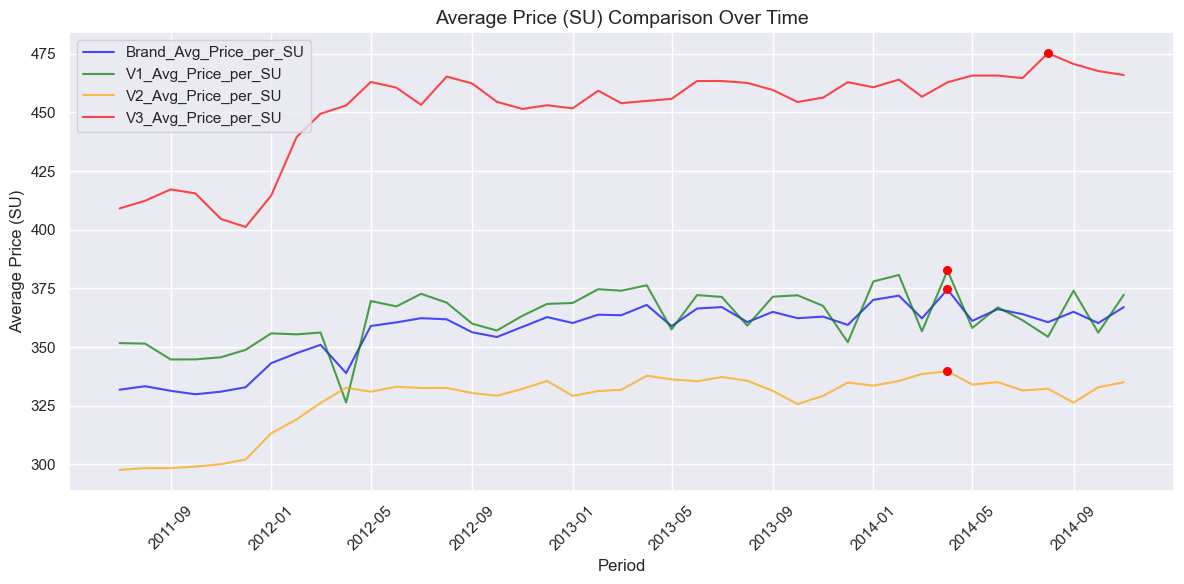

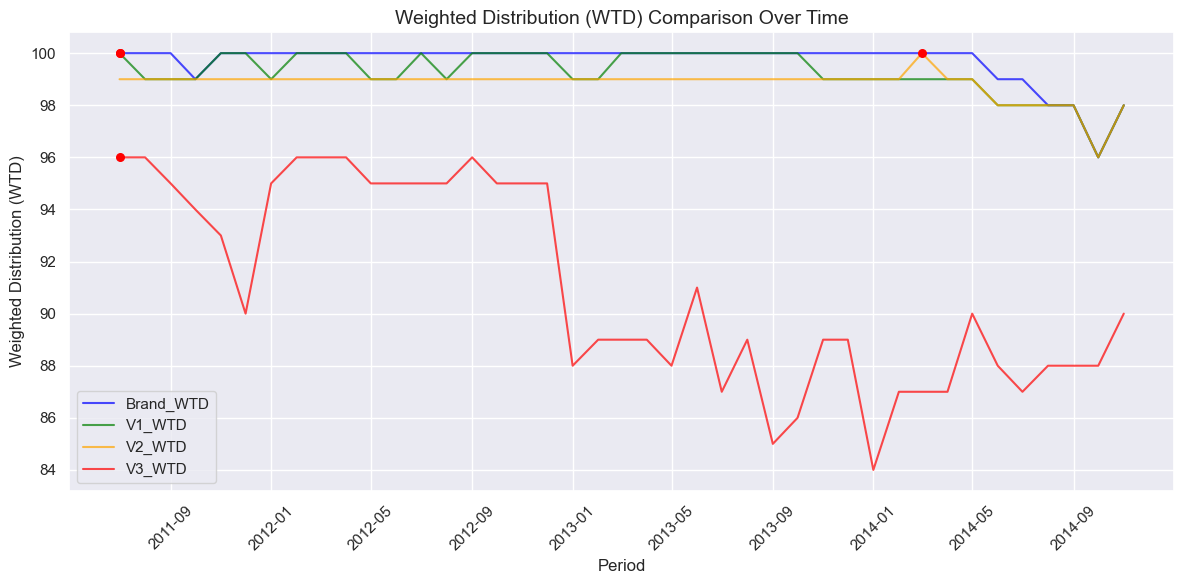

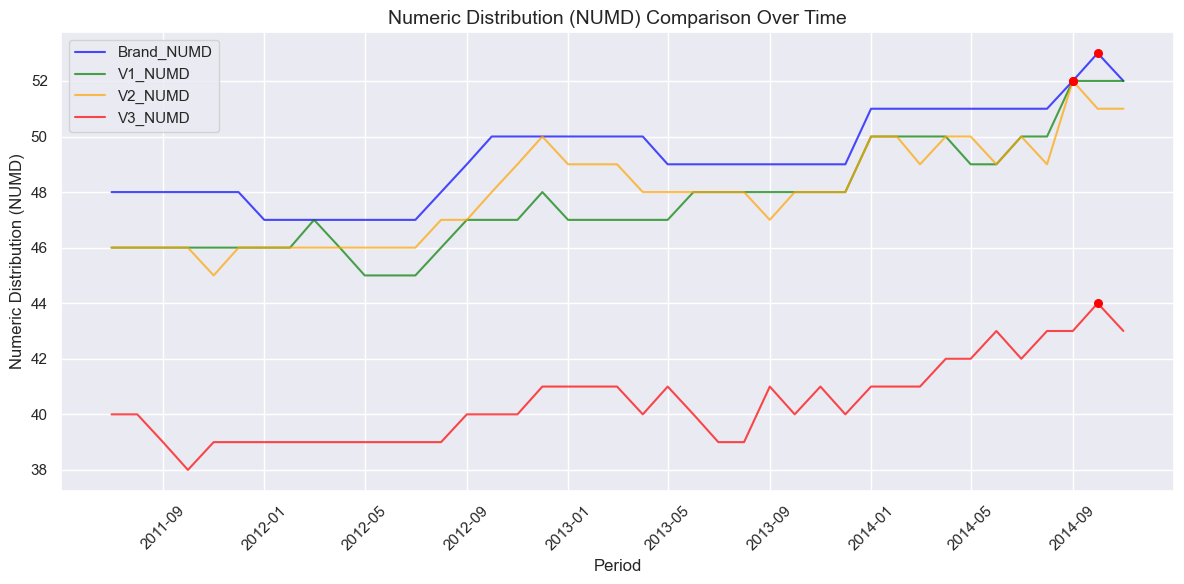

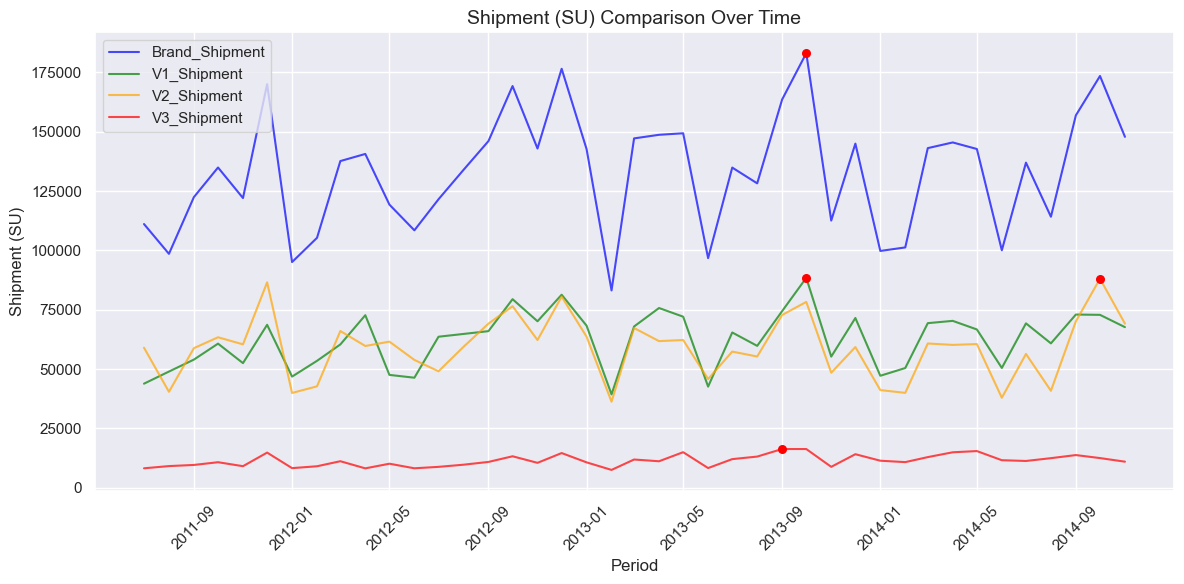

In [30]:
# Ensure 'Period' is in datetime format and set as index
final_data['Period'] = pd.to_datetime(final_data['Period'], errors='coerce')

# Function to plot time series with peak annotation using a small red dot
def plot_with_peaks(data, columns, title, ylabel, colors):
    plt.figure(figsize=(12, 6))
    sns.set(style="darkgrid")
    
    for col, color in zip(columns, colors):
        sns.lineplot(data=data, x='Period', y=col, label=col, color=color, alpha=0.7)
        
        # Annotate the peak point with a small red dot
        highest = data[col].idxmax()
        peak_value = data.loc[highest, col]
        peak_time = data.loc[highest, 'Period']
        plt.scatter(peak_time, peak_value, color='red', s=30, zorder=5)

    plt.title(title, fontsize=14)
    plt.xlabel('Period', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot Sales Value
plot_with_peaks(
    final_data,
    ['Brand_Sales_Value', 'V1_Sales_Value', 'V2_Sales_Value', 'V3_Sales_Value'],
    'Sales Value Comparison Over Time',
    'Sales Value',
    ['blue', 'green', 'orange', 'red']
)

# Plot Average Price (Including Avg_Price_Brand_SU)
plot_with_peaks(
    final_data,
    ['Brand_Avg_Price_per_SU', 'V1_Avg_Price_per_SU', 'V2_Avg_Price_per_SU', 'V3_Avg_Price_per_SU'],
    'Average Price (SU) Comparison Over Time',
    'Average Price (SU)',
    ['blue', 'green', 'orange', 'red']
)

# Plot Weighted Distribution (WTD)
plot_with_peaks(
    final_data,
    ['Brand_WTD', 'V1_WTD','V2_WTD','V3_WTD'],
    'Weighted Distribution (WTD) Comparison Over Time',
    'Weighted Distribution (WTD)',
    ['blue', 'green', 'orange', 'red']
)

# Plot Numeric Distribution (NUMD)
plot_with_peaks(
    final_data,
    ['Brand_NUMD','V1_NUMD','V2_NUMD','V3_NUMD'],
    'Numeric Distribution (NUMD) Comparison Over Time',
    'Numeric Distribution (NUMD)',
    ['blue', 'green', 'orange', 'red']
)

# Plot Shipment Comparison
plot_with_peaks(
    final_data,
    ['Brand_Shipment', 'V1_Shipment','V2_Shipment','V3_Shipment'],
    'Shipment (SU) Comparison Over Time',
    'Shipment (SU)',
    ['blue', 'green', 'orange', 'red']
)


**Key Observations from Time Series Comparisons**

1. **Sales Value Trends**  
   - The **Brand_Sales_Value** consistently outperforms others, with significant peaks observed in **May 2013** and **December 2013**.  

2. **Average Price (SU)**  
   - **V3_Avg_Price_per_SU** maintains the highest values, peaking prominently in early 2014. The other product lines exhibit relatively stable trends.  

3. **Weighted Distribution (WTD)**  
   - **Brand_WTD** shows remarkable stability and leads the metric. In contrast, **V3_WTD** displays noticeable fluctuations and underperformance.  

4. **Numeric Distribution (NUMD)**  
   - **Brand_NUMD** demonstrates steady growth over time, while **V3_NUMD** remains the lowest but shows gradual improvement.  

5. **Shipment (SU)**  
   - **Brand_Shipment** exhibits dominance with considerable volatility, whereas **V3_Shipment** is the lowest yet steadily increasing over the analyzed period.
 

#### <b> Correlation Analysis<b>

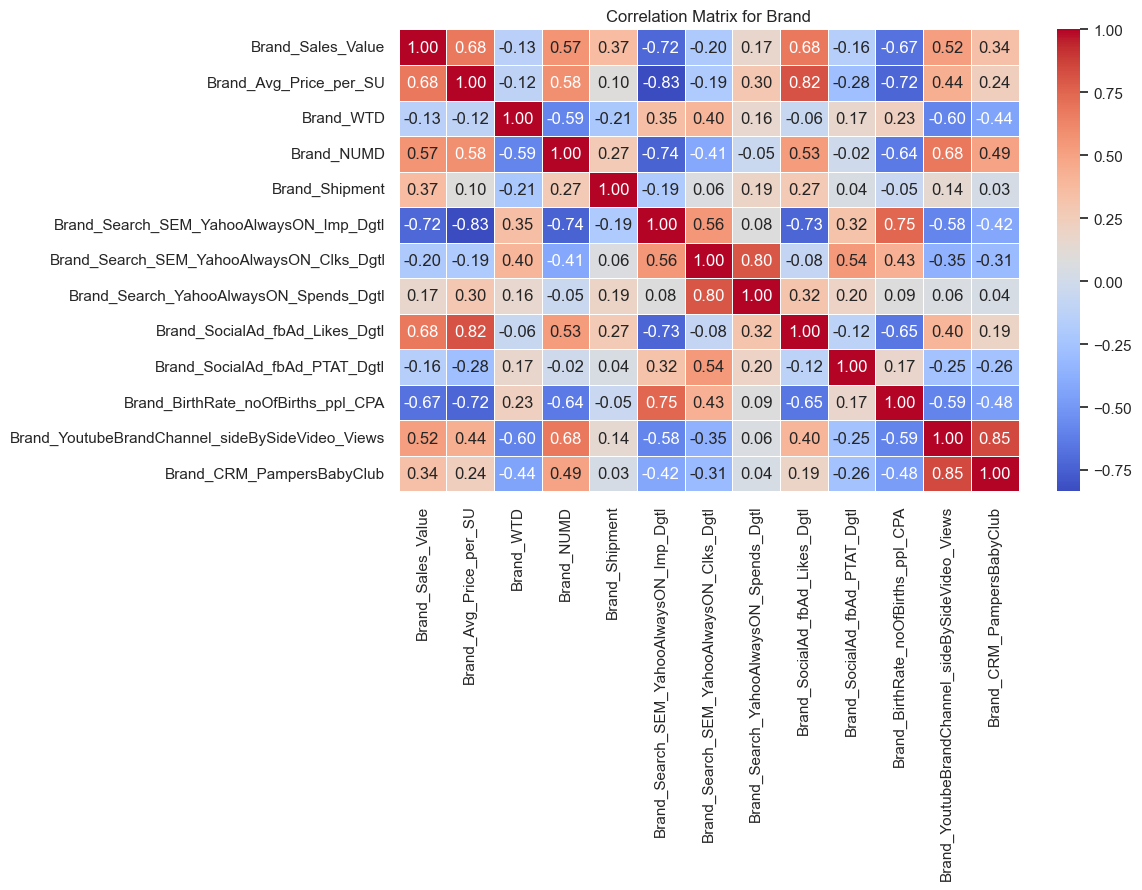

In [31]:
metrics = [
    'Brand_Sales_Value','Brand_Avg_Price_per_SU', 'Brand_WTD', 'Brand_NUMD', 'Brand_Shipment',
    'Brand_Search_SEM_YahooAlwaysON_Imp_Dgtl','Brand_Search_SEM_YahooAlwaysON_Clks_Dgtl','Brand_Search_YahooAlwaysON_Spends_Dgtl',
    'Brand_SocialAd_fbAd_Likes_Dgtl','Brand_SocialAd_fbAd_PTAT_Dgtl','Brand_BirthRate_noOfBirths_ppl_CPA',
    'Brand_YoutubeBrandChannel_sideBySideVideo_Views','Brand_CRM_PampersBabyClub'
]

# Filter the data to include only the selected metrics
selected_data = final_data[metrics]

# Compute the correlation matrix
correlation_matrix = selected_data.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Title and show plot
plt.title('Correlation Matrix for Brand')
plt.show()


**Correlation Matrix Insights for Brand**
- **Sales Value Brand**  
  - Strongly correlated with **Average Price Brand** (0.68) and **Brand Social Facebook Likes Digital** (0.68).  

- **Avg Price Brand SU**  
  - Shows a high correlation with **Brand Social Facebook Likes Digital** (0.82).  

- **Brand Search SEM Yahoo Metrics**  
  - Displays a strong negative correlation with **Sales Value Brand** (-0.83).  

- **Brand Social Facebook PTAT Digital**  
  - Exhibits weak correlations with most other metrics.  


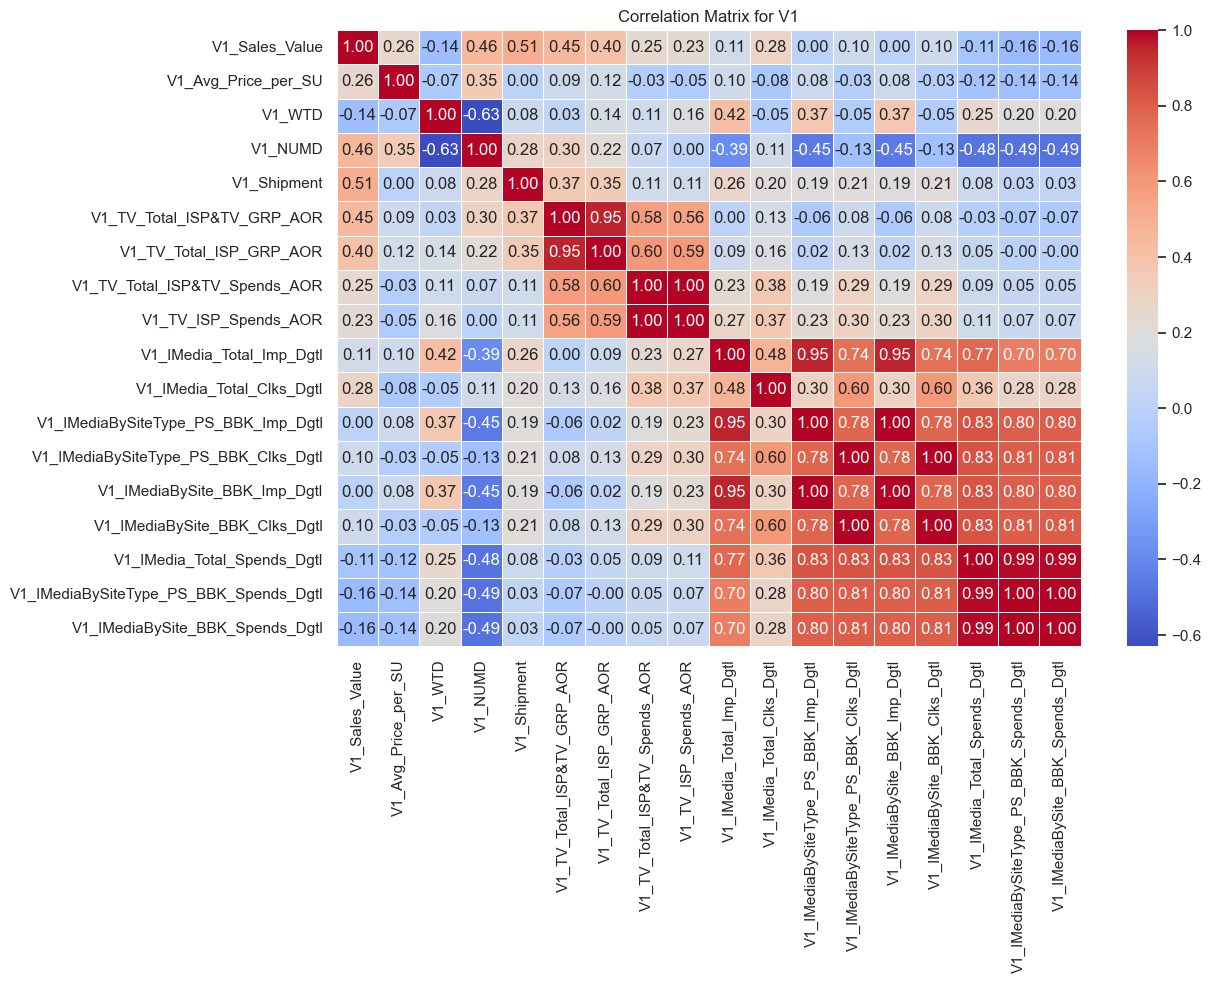

In [32]:
metrics = [
    'V1_Sales_Value','V1_Avg_Price_per_SU', 'V1_WTD', 'V1_NUMD', 'V1_Shipment',
    'V1_TV_Total_ISP&TV_GRP_AOR','V1_TV_Total_ISP_GRP_AOR','V1_TV_Total_ISP&TV_Spends_AOR',
    'V1_TV_ISP_Spends_AOR','V1_IMedia_Total_Imp_Dgtl','V1_IMedia_Total_Clks_Dgtl',
    'V1_IMediaBySiteType_PS_BBK_Imp_Dgtl','V1_IMediaBySiteType_PS_BBK_Clks_Dgtl',
    'V1_IMediaBySite_BBK_Imp_Dgtl','V1_IMediaBySite_BBK_Clks_Dgtl','V1_IMedia_Total_Spends_Dgtl',
    'V1_IMediaBySiteType_PS_BBK_Spends_Dgtl','V1_IMediaBySite_BBK_Spends_Dgtl'
]

# Filter the data to include only the selected metrics
selected_data = final_data[metrics]

# Compute the correlation matrix
correlation_matrix = selected_data.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Title and show plot
plt.title('Correlation Matrix for V1')
plt.show()

**Correlation Matrix Insights for V1**

- **V1 Sales Value**  
  - Moderately correlated with **V1_TV_Total_ISP&TV_GRP_AOR** (0.45) and **V1_Shipment** (0.51).  

- **V1_TV_Total_ISP&TV_GRP_AOR**  
  - Shows strong internal correlations (up to 0.95).  

- **iMedia Metrics**  
  - Exhibits strong interdependence, particularly for **Parenting and BBK metrics** (0.74 to 0.99).  

- **V1_Shipment**  
  - Weakly correlated with most digital and media spend metrics.  


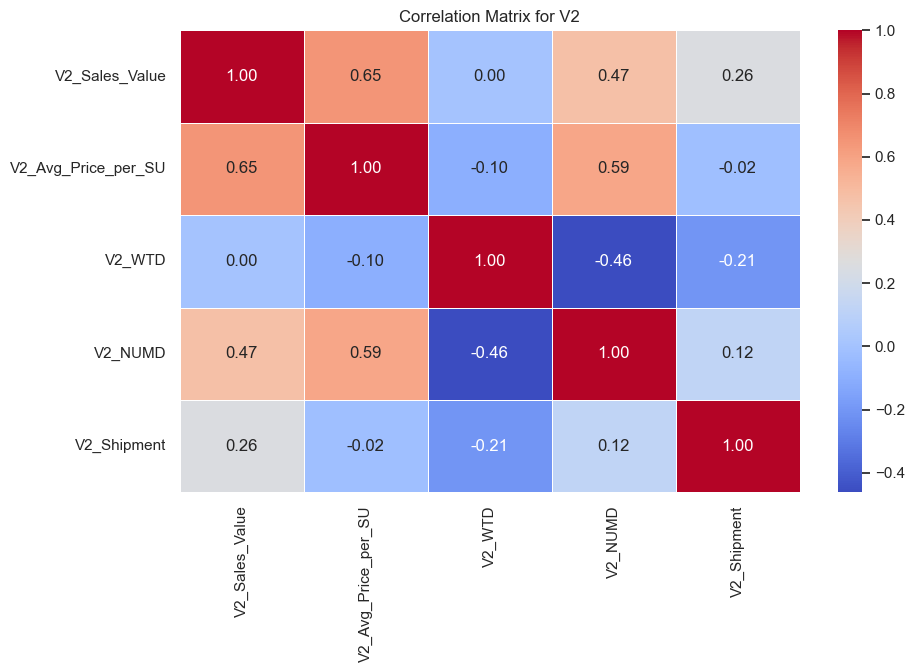

In [33]:
metrics = [
    'V2_Sales_Value','V2_Avg_Price_per_SU', 'V2_WTD', 'V2_NUMD', 'V2_Shipment'
]

# Filter the data to include only the selected metrics
selected_data = final_data[metrics]

# Compute the correlation matrix
correlation_matrix = selected_data.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Title and show plot
plt.title('Correlation Matrix for V2')
plt.show()

**Correlation Matrix Insights for V2**

- **Sales Value V2**  
  - Moderately correlated with **Average Price V2 SU** (0.65) and **NUMD V2** (0.47).  

- **NUMD V2**  
  - Shows a moderate positive correlation with **Sales Value V2** (0.47).  

- **WTD V2**  
  - No significant correlations observed. 

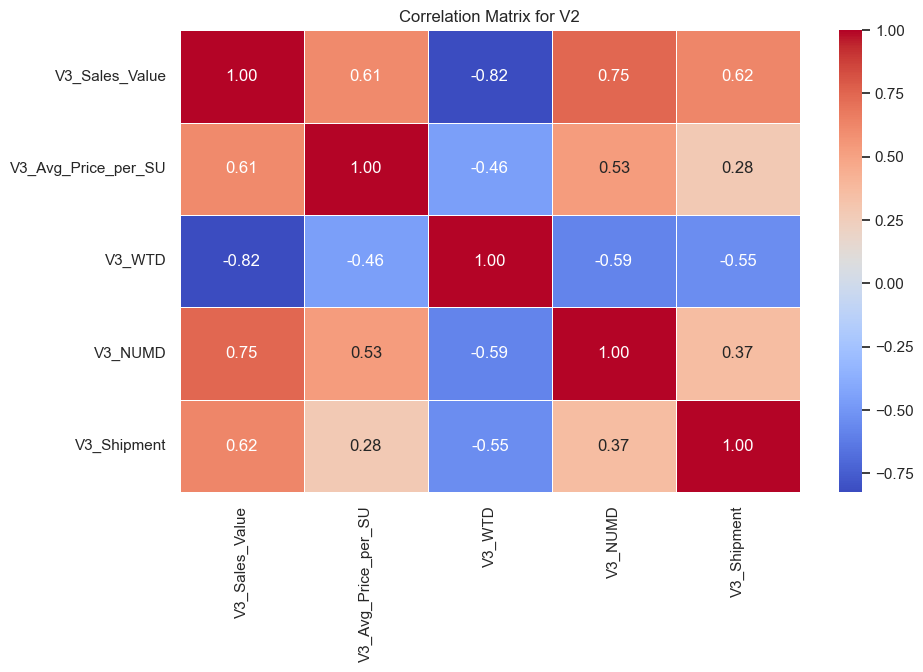

In [34]:
metrics = [
    'V3_Sales_Value','V3_Avg_Price_per_SU', 'V3_WTD', 'V3_NUMD', 'V3_Shipment'
]

# Filter the data to include only the selected metrics
selected_data = final_data[metrics]

# Compute the correlation matrix
correlation_matrix = selected_data.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Title and show plot
plt.title('Correlation Matrix for V2')
plt.show()

**Correlation Matrix Insights for V3**

- **Sales Value V3**  
  - Strong negative correlation with **WTD V3** (-0.82) and a positive correlation with **NUMD V3** (0.75).  

- **Avg Price V3 SU**  
  - Moderately correlated with **NUMD V3** (0.53).  

- **Shipment_SU_V3**  
  - Shows a moderate correlation with **Sales Value V3** (0.62) and weak correlations with other metrics.  


#### <b>Outlier Detection<b>

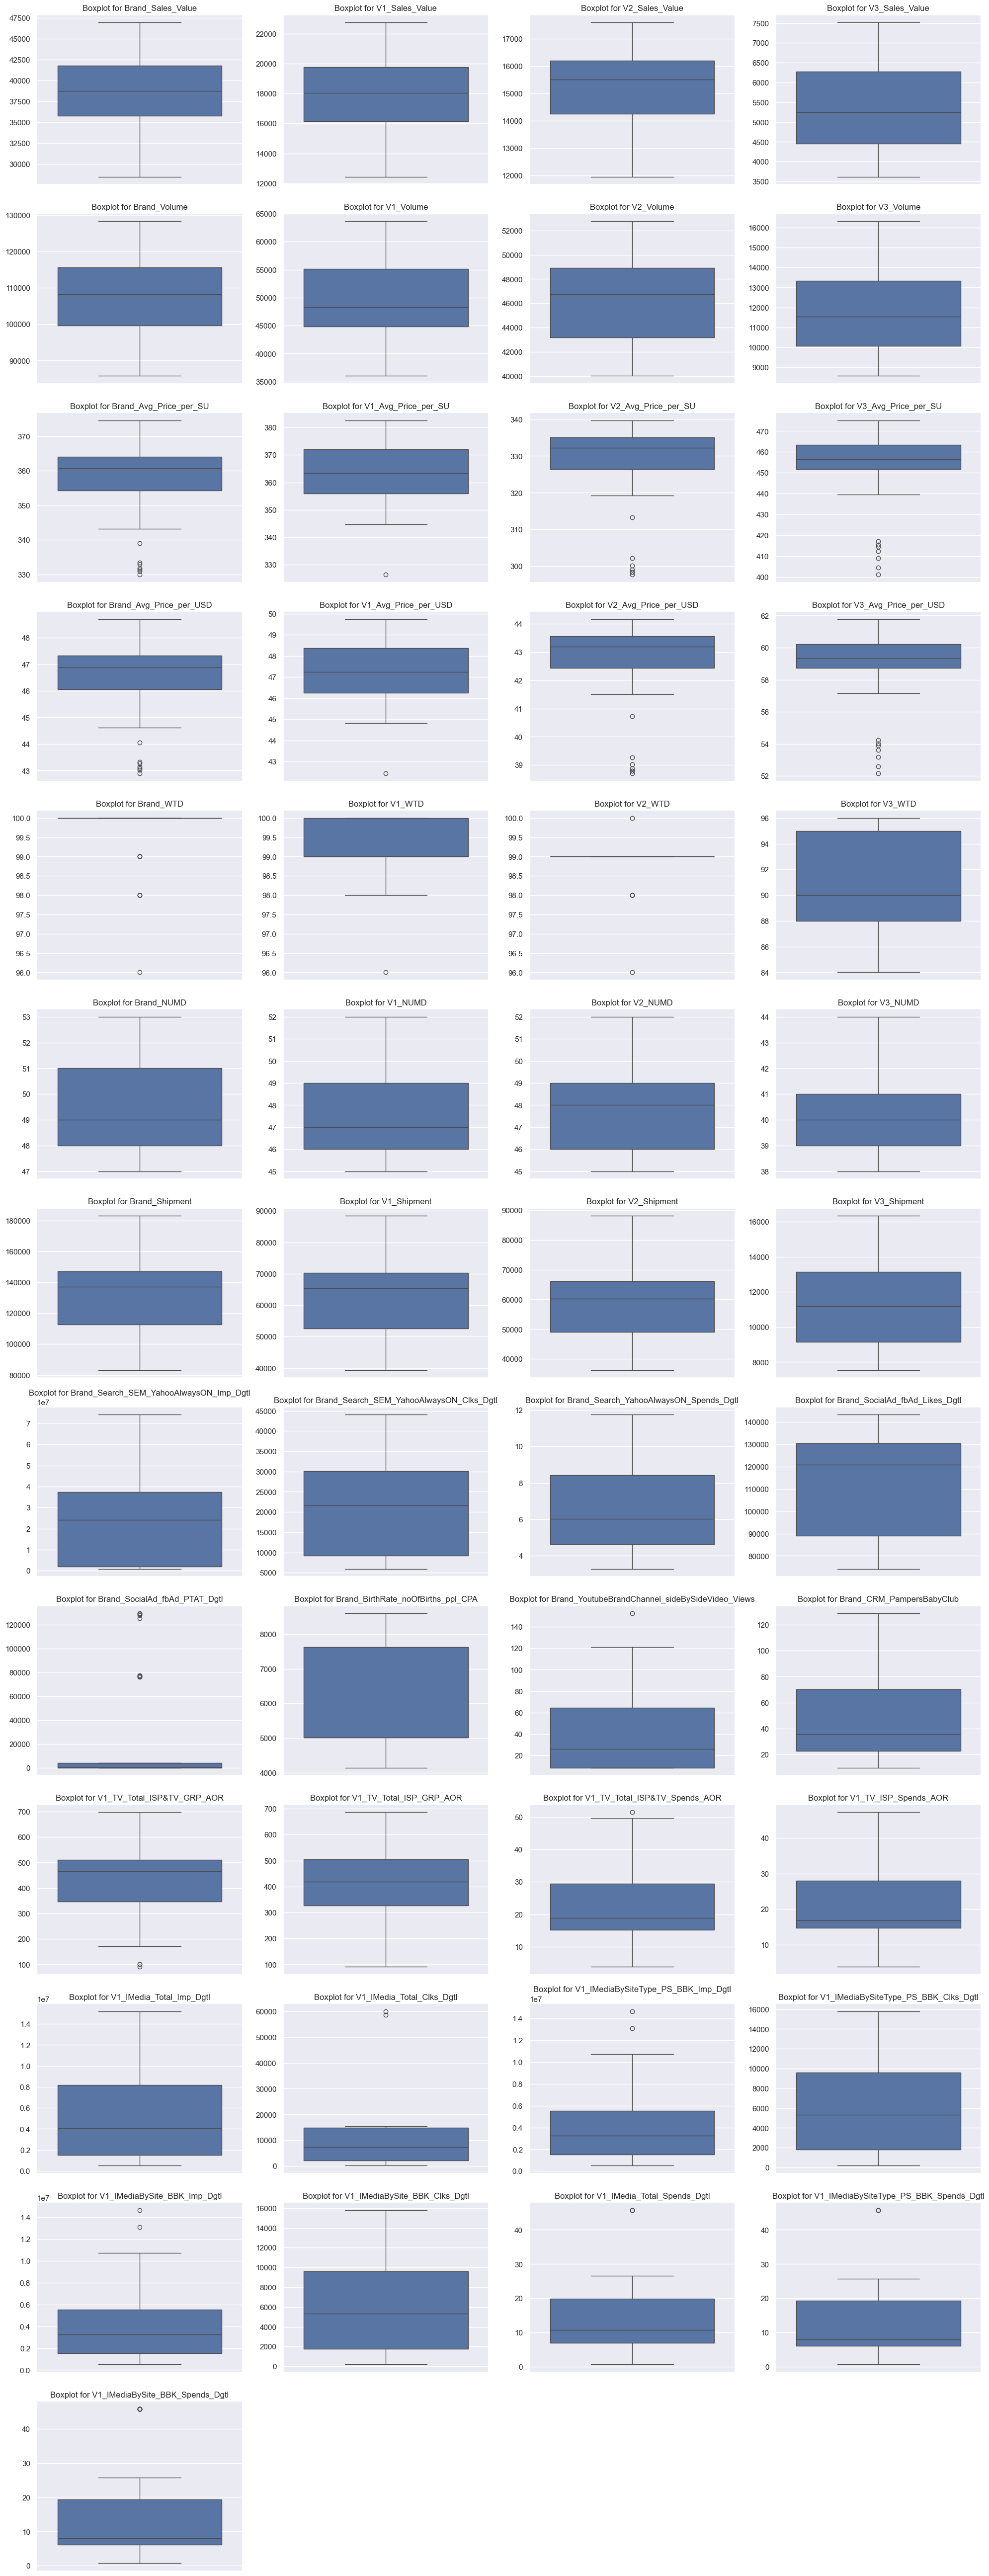

In [35]:
# Filter out non-numeric columns
numeric_cols = final_data.select_dtypes(include=['number']).columns

# Calculate number of rows and columns needed for the subplot grid
n_cols = 4  
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

# Set up the figure size
plt.figure(figsize=(20, n_rows * 4))

# Loop through each numeric column in the dataset
for i, col in enumerate(numeric_cols):
    plt.subplot(n_rows, n_cols, i + 1) 
    sns.boxplot(y=final_data[col])
    plt.title(f'Boxplot for {col}')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

**Outlier Detection Insights**

1. **Sales & Volume**  
   - The `Sales_Value` and `Volume` metrics across `Brand`, `V1`, `V2`, and `V3` show minimal to no significant outliers, suggesting stable data for these categories.  

2. **Average Price (SU)**  
   - Notable outliers observed on the **lower end** for `Avg_Price` variables, especially for `Brand_Avg_Price_per_SU` and `V1_Avg_Price_per_SU`, indicating potential anomalies in pricing strategies or data recording issues.  

3. **Weighted Distribution (WTD)**  
   - Outliers are present in `WTD` metrics (`Brand_WTD`, `V1_WTD`, `V2_WTD`, `V3_WTD`), possibly reflecting inconsistencies in product availability or distribution strategies across different channels.  

4. **Numeric Distribution (NUMD)**  
   - No major outliers detected across all `NUMD` variables, suggesting consistent numeric distribution performance.  

5. **Shipment (SU)**  
   - Some outliers identified in shipment metrics (`Brand_Shipment`, `V1_Shipment`, `V2_Shipment`, `V3_Shipment`), which may indicate unexpected spikes or delays in product shipments.  

6. **Media Metrics (Digital)**  
   - Several outliers observed in **digital metrics**, such as `Brand_SocialAd_fbAd_Likes_Dgtl` and `V1_IMedia_Total_Imp_Dgtl`, likely caused by specific marketing campaigns or seasonal events driving sudden changes.  

7. **CRM & YouTube Metrics**  
   - Outliers found in `Brand_YoutubeBrandChannel_sideBySideVideo_Views` and `Brand_CRM_PampersBabyClub`, hinting at occasional spikes in engagement or membership activities.  

8. **Other Observations**  
   - **Month & Year Data**: No significant outliers detected in time-related variables, confirming consistent time-series entries.  
   - **Miscellaneous Variables**: A few outliers noted in specific subcategories, such as `V1_TV_Total_ISP&TV_GRP_AOR ` and related variables, reflecting anomalies in advertising spends or media strategies.


#### <b>Sales Trends Over Time<b>

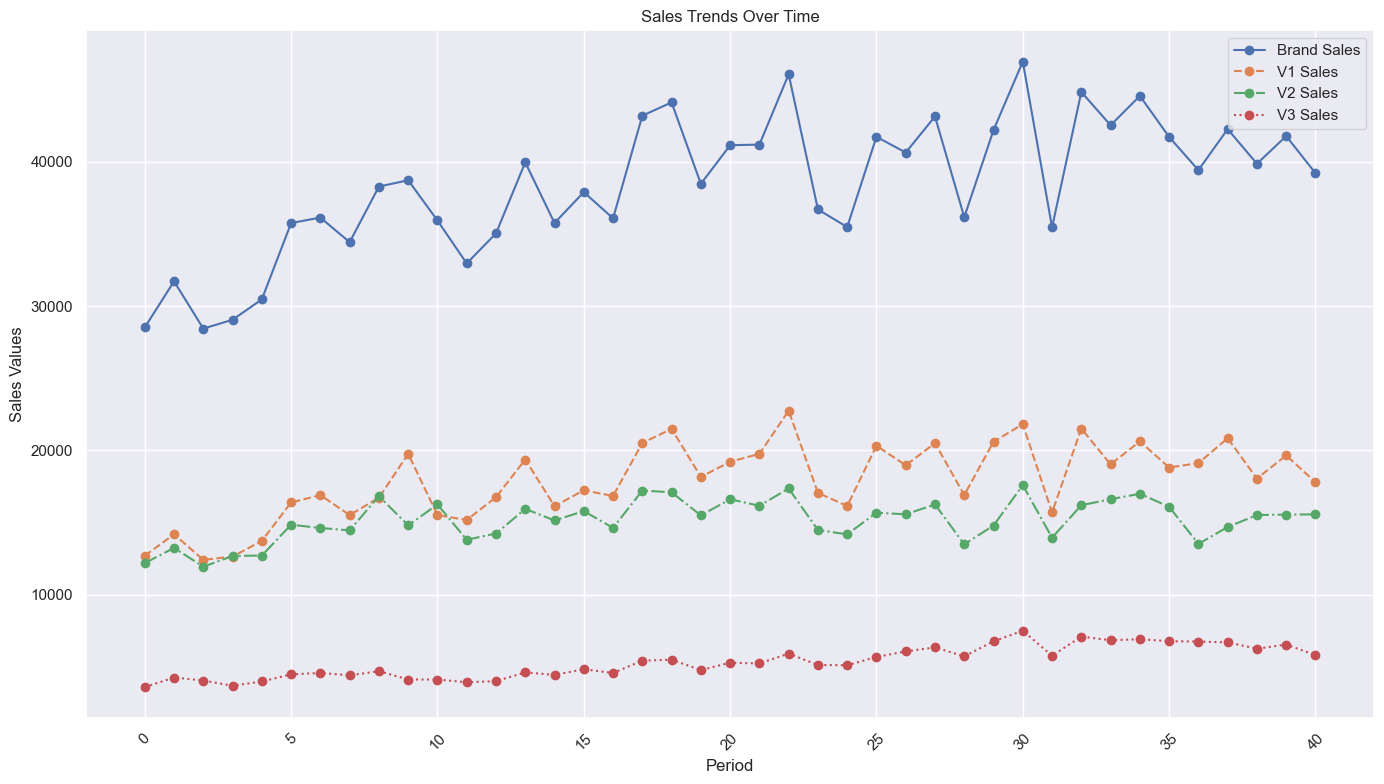

In [36]:
# Plot the sales columns in one chart
plt.figure(figsize=(14, 8))
plt.plot(final_data.index, final_data['Brand_Sales_Value'], label='Brand Sales', marker='o', linestyle='-')
plt.plot(final_data.index, final_data['V1_Sales_Value'], label='V1 Sales', marker='o', linestyle='--')
plt.plot(final_data.index, final_data['V2_Sales_Value'], label='V2 Sales', marker='o', linestyle='-.')
plt.plot(final_data.index, final_data['V3_Sales_Value'], label='V3 Sales', marker='o', linestyle=':')

# Customize the chart
plt.title('Sales Trends Over Time')
plt.xlabel('Period')
plt.ylabel('Sales Values')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

# Display the chart
plt.tight_layout()
plt.show()

**Observations:**
1. **Brand Sales**:
   - Overall brand sales show an upward trend with periodic fluctuations.

2. **V1 Sales**:
   - V1 sales are steady with some oscillations.
   - They are significantly lower than the overall brand sales.

3. **V2 Sales**:
   - V2 sales are stable and slightly lower than V1 sales for most periods.

4. **V3 Sales**:
   - V3 sales are the lowest among all product lines.
   - They remain steady with minimal variations.

5. **Comparison**:
   - V1 is the largest contributor to brand sales.
   - Overall fluctuations in brand sales are driven mainly by changes in V1 and V2.


#### <b>Visualizing Key Sales Metrics Over Time with Peak Value Highlights<b>

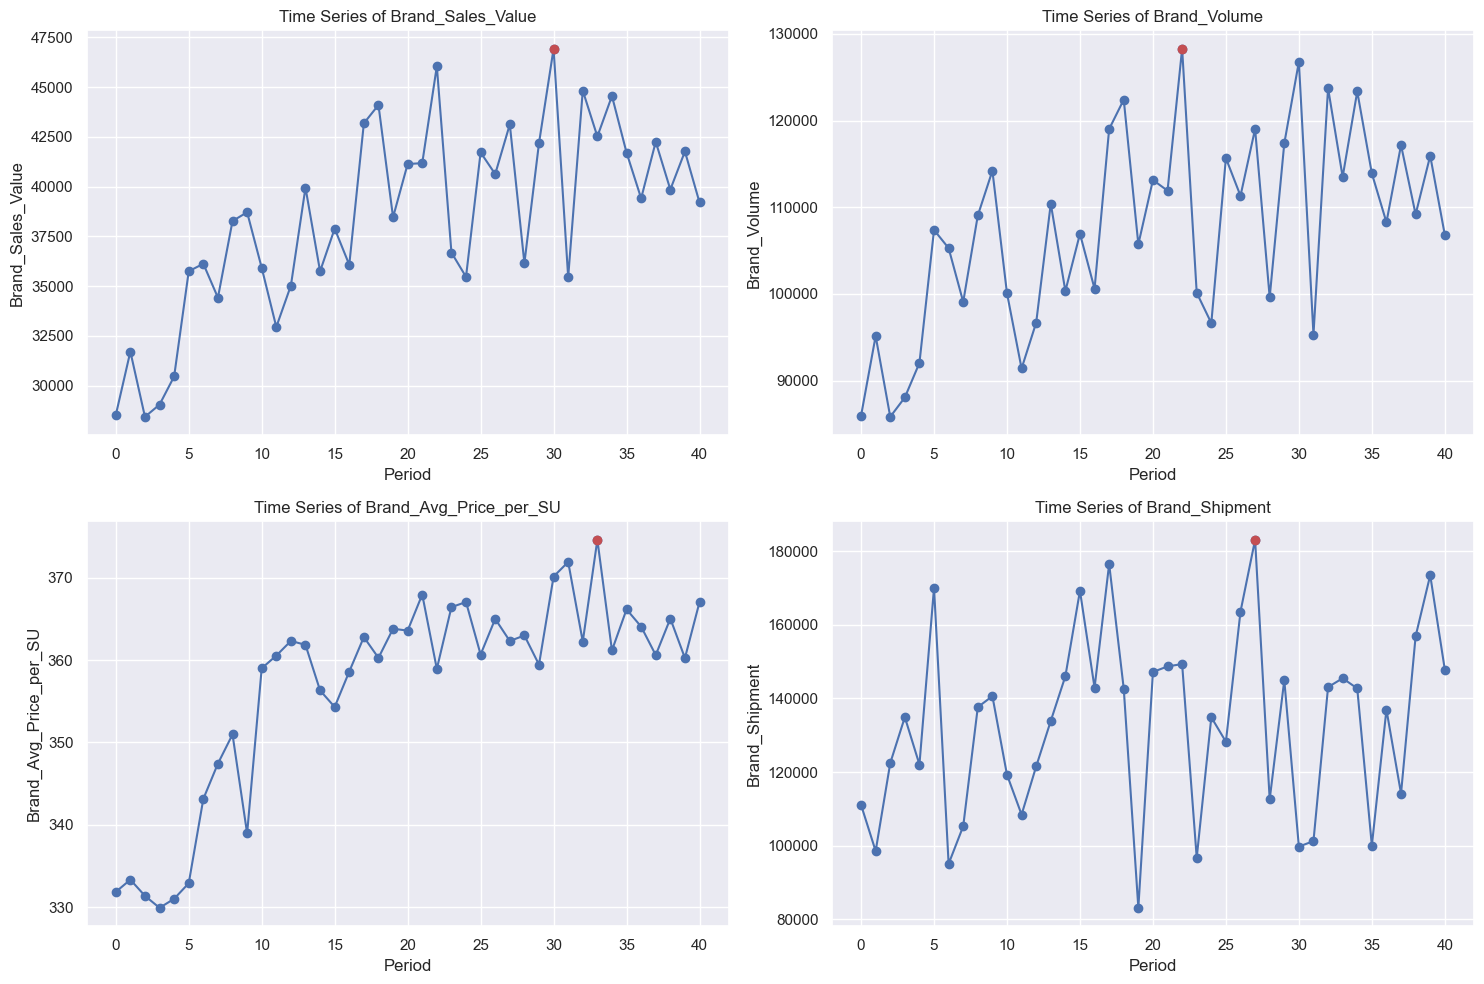

In [37]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # Updated to 2x2 subplots

# List of metrics to plot
metrics = ['Brand_Sales_Value', 'Brand_Volume', 'Brand_Avg_Price_per_SU', 'Brand_Shipment']

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Plot each metric in a separate subplot
for i, metric in enumerate(metrics):
    # Plot the time series
    axs[i].plot(final_data.index, final_data[metric], marker='o', linestyle='-', color='b')
    
    # Highlight the highest value in red
    max_value = final_data[metric].max()
    max_index = final_data[metric].idxmax()
    axs[i].plot(max_index, max_value, 'ro')  # Red circle at the highest point

    # Set plot title and labels
    axs[i].set_title(f'Time Series of {metric}')
    axs[i].set_xlabel('Period')
    axs[i].set_ylabel(metric)
    axs[i].grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

**Observations of the Time Series Plots**

**1. Brand Sales Value**
- Shows an upward trend over time, indicating increasing sales value.
- The highest value is marked with a red dot.

**2. Brand Volume**
- Overall increasing trend with some fluctuations.
- A red dot highlights the maximum volume observed.

**3. Brand Avg Price per SU**
- Initially shows a steady upward trend, then stabilizes with minor variations.
- The maximum average price point is indicated with a red dot.

**4. Brand Shipment**
- Displays significant variability with no clear trend.
- The highest shipment level is marked with a red dot.

**General Observations**
- Peaks for each metric are clearly highlighted with red dots.
- Some metrics, like Brand Sales Value and Avg Price per SU, show consistent growth, while Brand Shipment is more irregular.


#### <b>Distribution Analysis<b>

Brand

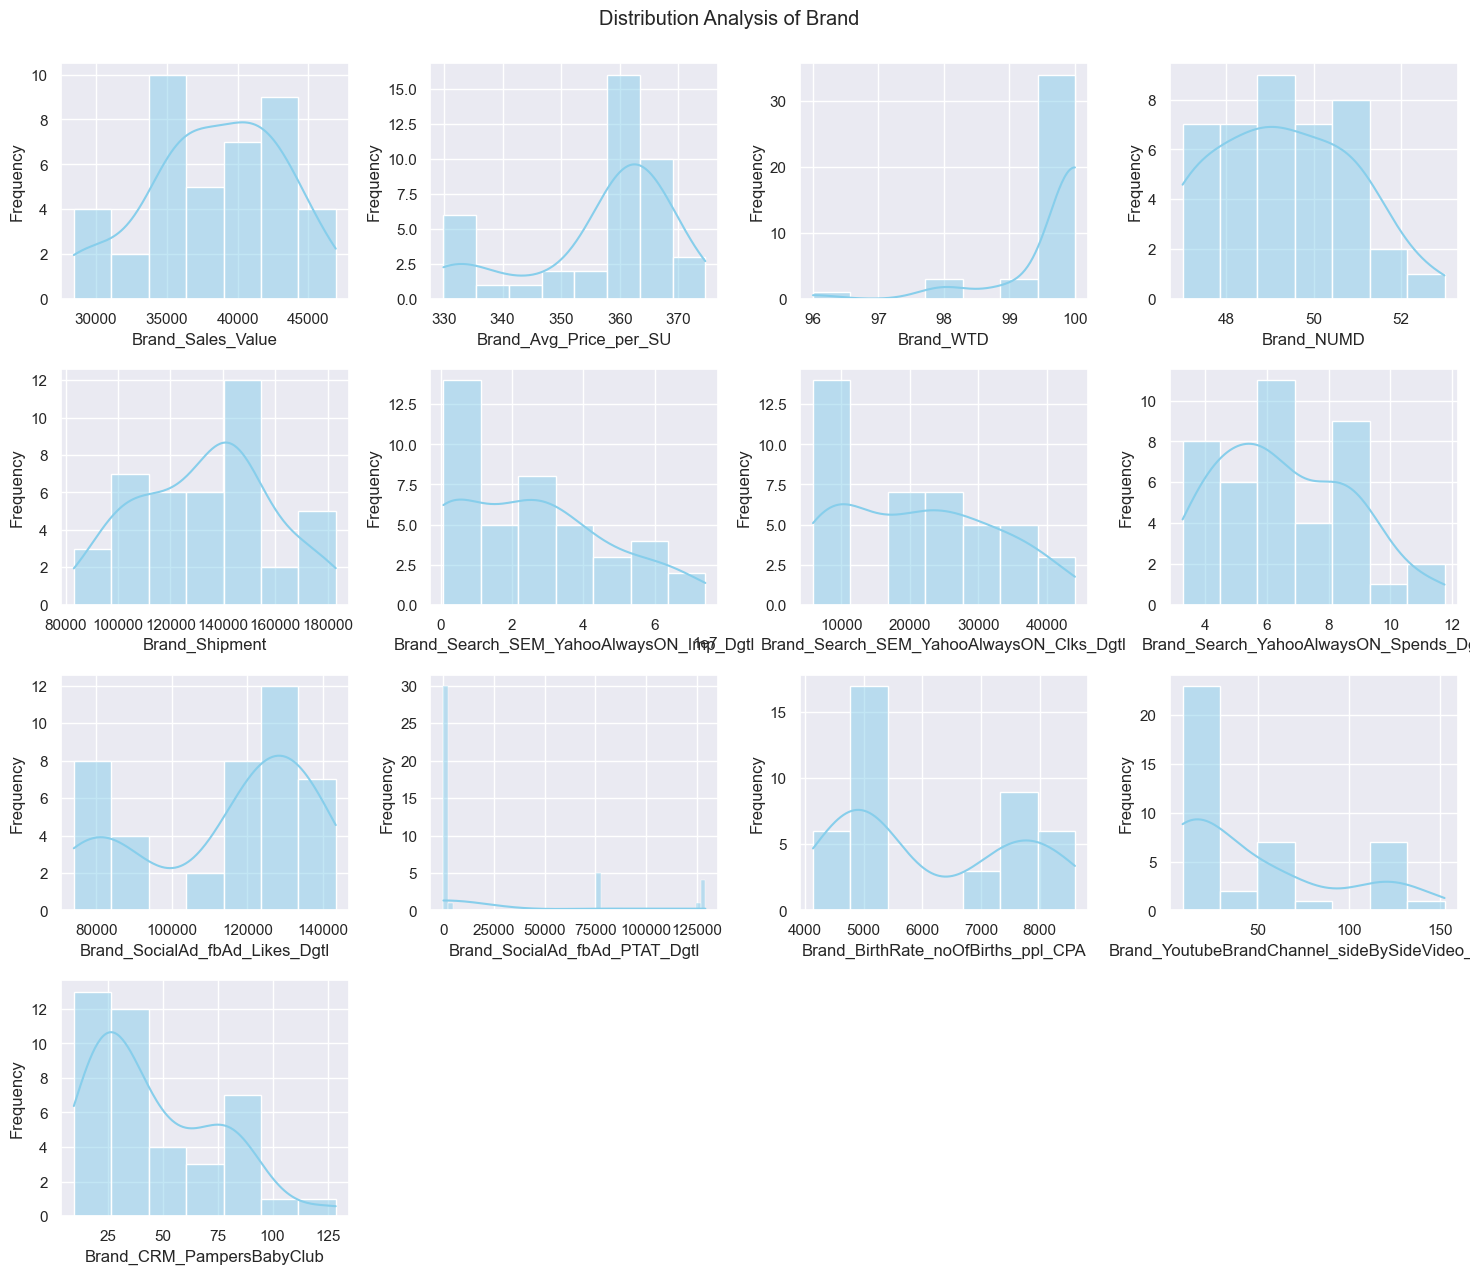

In [38]:
# Define the columns of interest for distribution analysis, including the additional ones
cols = [
    'Brand_Sales_Value','Brand_Avg_Price_per_SU', 'Brand_WTD', 'Brand_NUMD', 'Brand_Shipment',
    'Brand_Search_SEM_YahooAlwaysON_Imp_Dgtl','Brand_Search_SEM_YahooAlwaysON_Clks_Dgtl','Brand_Search_YahooAlwaysON_Spends_Dgtl',
    'Brand_SocialAd_fbAd_Likes_Dgtl','Brand_SocialAd_fbAd_PTAT_Dgtl','Brand_BirthRate_noOfBirths_ppl_CPA',
    'Brand_YoutubeBrandChannel_sideBySideVideo_Views','Brand_CRM_PampersBabyClub'
]

# Set up the plot grid
plt.figure(figsize=(15, 18))  # Adjusted size for more plots
for i, col in enumerate(cols, 1):
    plt.subplot(6, 4, i)  # 6 rows, 4 columns for better organization
    sns.histplot(final_data[col].dropna(), kde=True, color='skyblue')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.suptitle("Distribution Analysis of Brand", y=1.02)
plt.show()

v1

In [ ]:
cols = [
    'V1_Sales_Value','V1_Avg_Price_per_SU', 'V1_WTD', 'V1_NUMD', 'V1_Shipment',
    'V1_TV_Total_ISP&TV_GRP_AOR','V1_TV_Total_ISP_GRP_AOR','V1_TV_Total_ISP&TV_Spends_AOR',
    'V1_TV_ISP_Spends_AOR','V1_IMedia_Total_Imp_Dgtl','V1_IMedia_Total_Clks_Dgtl',
    'V1_IMediaBySiteType_PS_BBK_Imp_Dgtl','V1_IMediaBySiteType_PS_BBK_Clks_Dgtl',
    'V1_IMediaBySite_BBK_Imp_Dgtl','V1_IMediaBySite_BBK_Clks_Dgtl','V1_IMedia_Total_Spends_Dgtl',
    'V1_IMediaBySiteType_PS_BBK_Spends_Dgtl','V1_IMediaBySite_BBK_Spends_Dgtl'
]
# Set up the plot grid
plt.figure(figsize=(15, 18))  # Adjusted size for more plots
for i, col in enumerate(cols, 1):
    plt.subplot(6, 4, i)  # 6 rows, 4 columns for better organization
    sns.histplot(final_data[col].dropna(), kde=True, color='mediumseagreen')  # Changed color to mediumseagreen
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.suptitle("Distribution Analysis of V1", y=1.02)
plt.show()


#### <b>Pie Chart to understand Sales share<b>

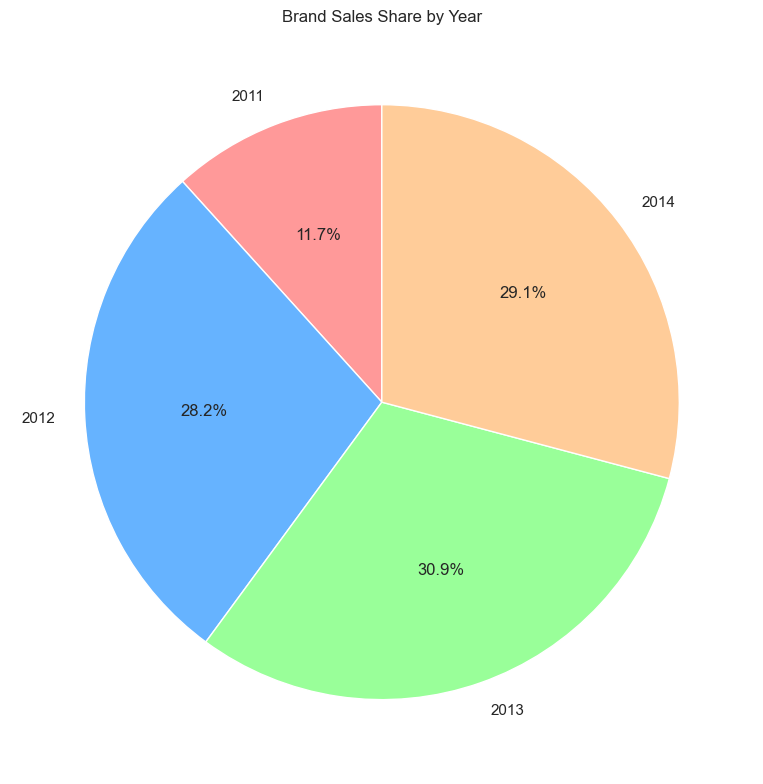

In [1358]:
# First, ensure the 'Year' column is extracted from the 'Period' or 'Date' column
final_data['Year'] = pd.to_datetime(final_data['Period']).dt.year

# Calculate sales by year
sales_by_year = final_data.groupby('Year')['Brand_Sales_Value'].sum()

# Plot pie chart
plt.figure(figsize=(8, 8))
sales_by_year.plot.pie(autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0'])
plt.title('Brand Sales Share by Year')
plt.ylabel('')  # Hide y-label for clarity
plt.tight_layout()
plt.show()

**Observations: Brand Sales Share by Year**

1. **2013 has the largest sales share (30.9%)**, indicating peak performance.
2. **2014 follows with 29.1%**, showing consistent sales after 2013.
3. **2012 contributed 28.2%**, indicating steady growth leading to the peak.
4. **2011 has the lowest share (11.7%)**, marking it as a year of lower sales.
5. **Sales increased from 2011 to 2013**, with a slight dip in 2014 while maintaining strong performance.


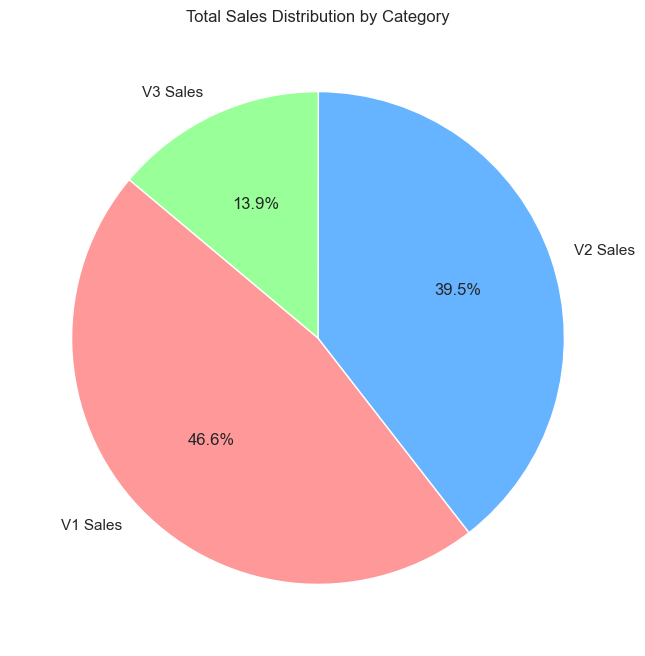

In [1359]:
# Ensure 'Period' is of datetime type if it's not already
final_data['Period'] = pd.to_datetime(final_data['Period'])

# Set 'Period' as the index
final_data.set_index('Period', inplace=True)

# Extract the year from the 'Period' index and create a 'Year' column
final_data['Year'] = final_data.index.year

# Calculate total sales per year for Brand, V1, V2, and V3

total_sales_v1 = final_data['V1_Sales_Value'].sum()
total_sales_v2 = final_data['V2_Sales_Value'].sum()
total_sales_v3 = final_data['V3_Sales_Value'].sum()

# Data for the pie chart
sales_data = [total_sales_v1, total_sales_v2, total_sales_v3]
labels = ['V1 Sales', 'V2 Sales', 'V3 Sales']
custom_colors = ['#ff9999', '#66b3ff', '#99ff99']  # Light red, blue, and green

# Plot a pie chart with custom colors
plt.figure(figsize=(8, 8))
plt.pie(
    sales_data, 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=custom_colors
)

# Title for the pie chart
plt.title('Total Sales Distribution by Category')

# Show the plot
plt.show()

# Reset the index so 'Period' becomes a column
final_data = final_data.reset_index()


**Observations: Total Sales Distribution by Category**

1. **V1 Sales account for the largest share (46.6%)**, making it the dominant category.
2. **V2 Sales contribute 39.5%**, closely following V1 in total sales.
3. **V3 Sales have the smallest share (13.9%)**, indicating relatively lower performance compared to V1 and V2.
4. **V1 and V2 together account for over 85% of the total sales**, showing their significant dominance in the distribution.


#### <b>Yearly Comparision of Sales<b>

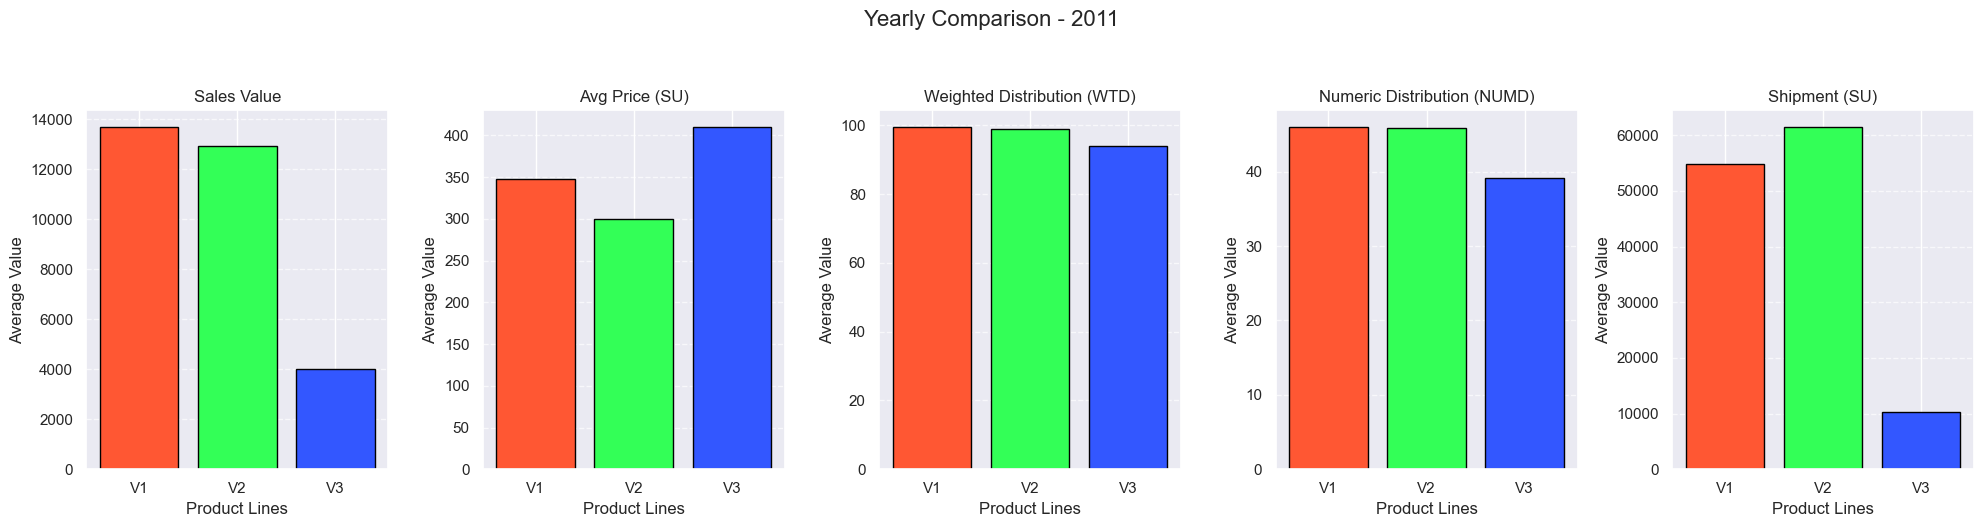

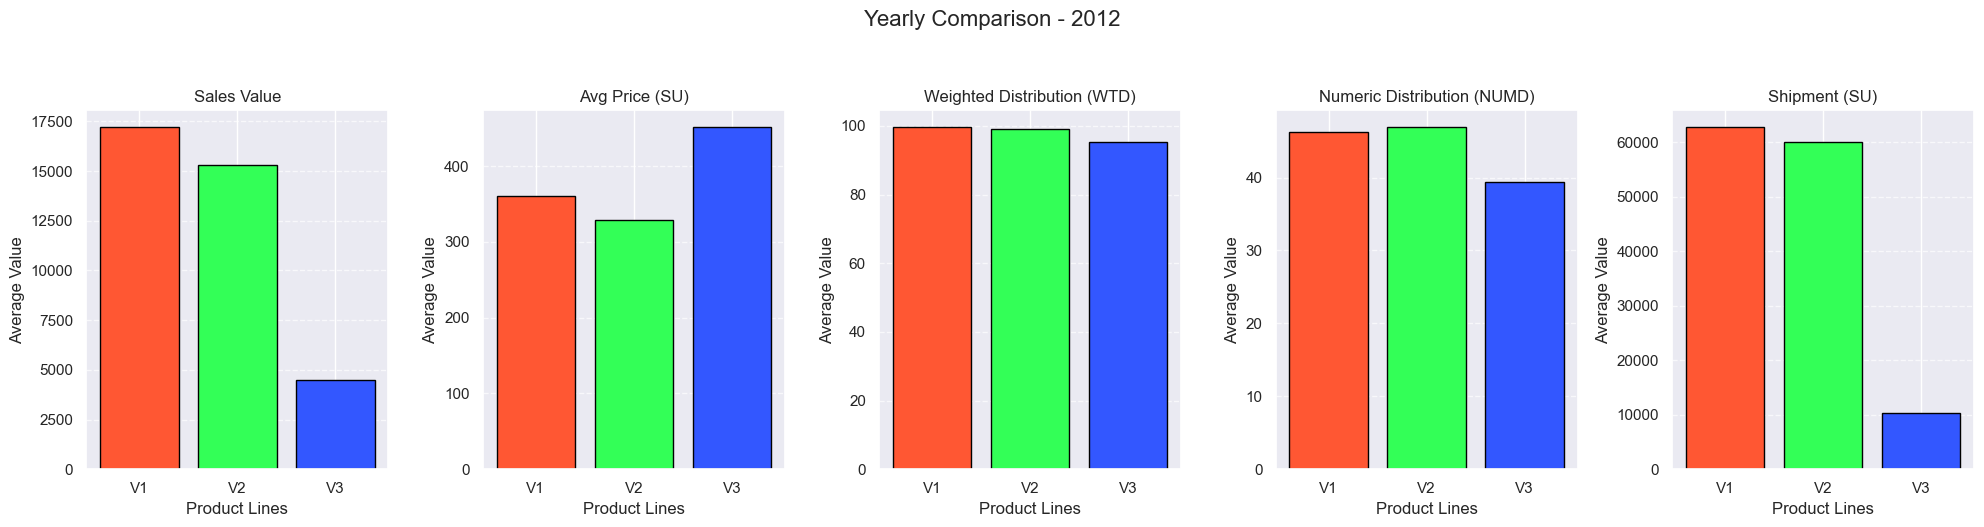

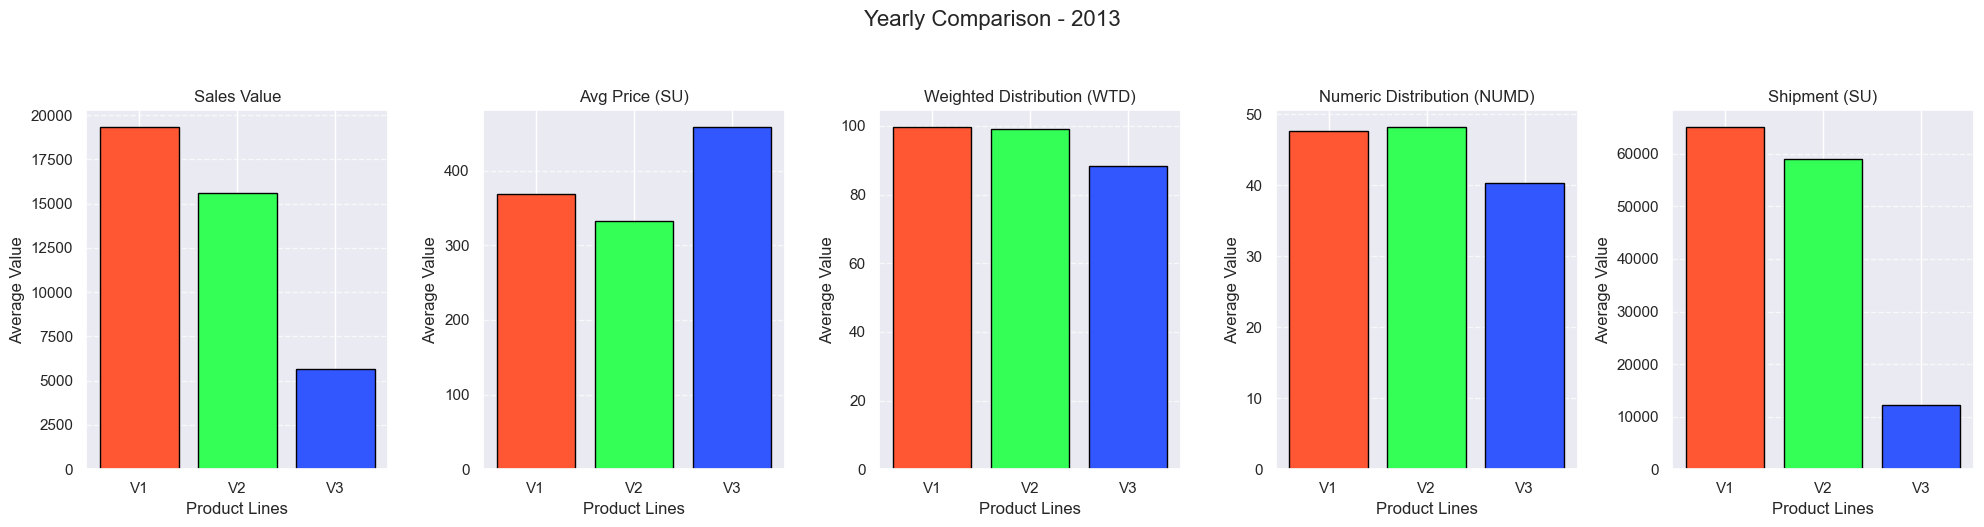

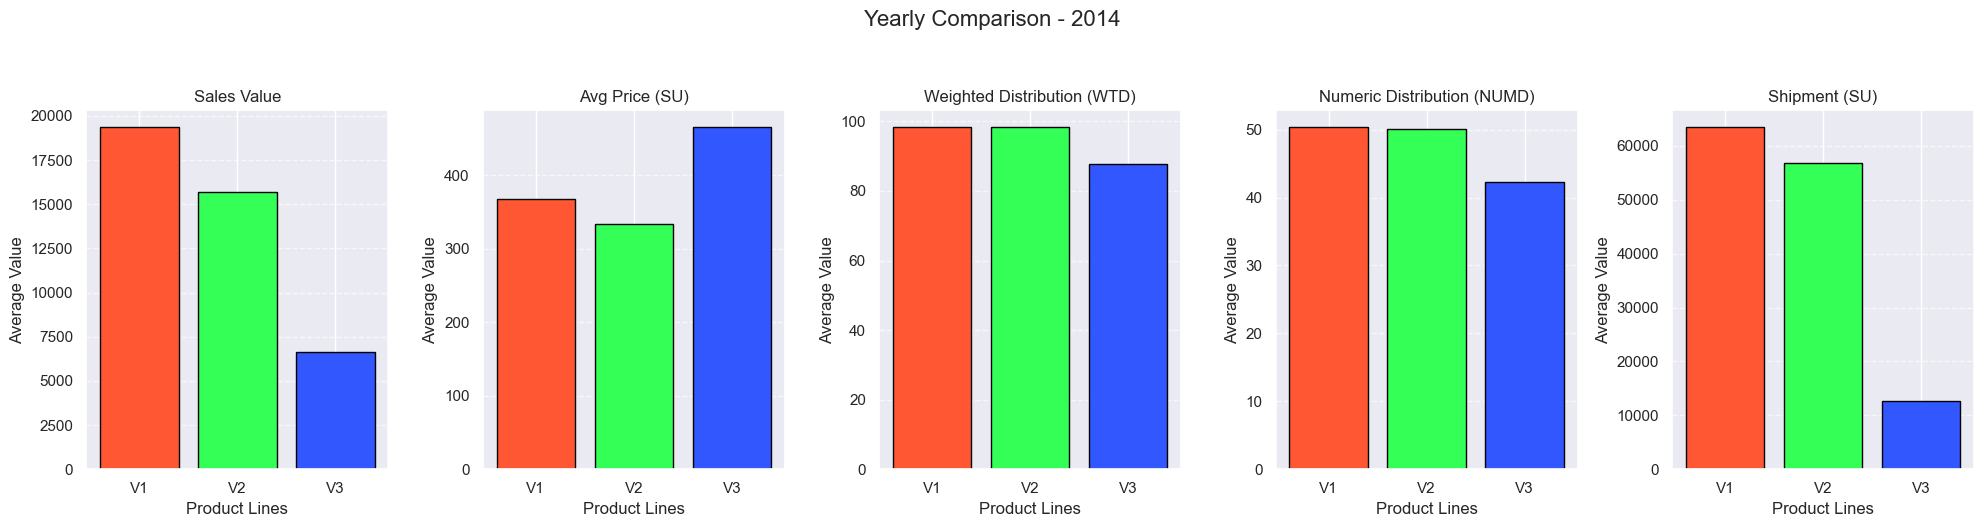

In [1360]:
# Convert 'Period' to datetime format
final_data['Period'] = pd.to_datetime(final_data['Period'], errors='coerce')

# Extract the year and filter for 2011-2014
final_data['Year'] = final_data['Period'].dt.year
final_merged_data_filtered = final_data[final_data['Year'].isin([2011, 2012, 2013, 2014])]

# Define metrics and labels for each product line (excluding Brand)
metrics = {
    "Sales Value": ["V1_Sales_Value", "V2_Sales_Value", "V3_Sales_Value"],
    "Avg Price (SU)": ["V1_Avg_Price_per_SU", "V2_Avg_Price_per_SU", "V3_Avg_Price_per_SU"],
    "Weighted Distribution (WTD)": ["V1_WTD", "V2_WTD", "V3_WTD"],
    "Numeric Distribution (NUMD)": ["V1_NUMD", "V2_NUMD", "V3_NUMD"],
    "Shipment (SU)": ["V1_Shipment", "V2_Shipment", "V3_Shipment"]
}

labels = ['V1', 'V2', 'V3']

# Define colors for consistency
colors = ['#FF5733', '#33FF57', '#3357FF']

# Loop through the years (2011-2014)
for year in [2011, 2012, 2013, 2014]:
    yearly_data = final_merged_data_filtered[final_merged_data_filtered['Year'] == year]
    
    # Create a figure for each year
    fig, axes = plt.subplots(1, len(metrics), figsize=(20, 5))
    fig.suptitle(f"Yearly Comparison - {year}", fontsize=16, y=1.05)

    # Loop through metrics to create bar charts
    for i, (metric_name, cols) in enumerate(metrics.items()):
        # Calculate average values for the metrics
        metric_data = yearly_data[cols].mean()
        
        # Create bar chart
        axes[i].bar(labels, metric_data, color=colors, edgecolor='black')
        axes[i].set_title(metric_name, fontsize=12)
        axes[i].set_ylabel("Average Value")
        axes[i].set_xlabel("Product Lines")
        axes[i].set_xticks(range(len(labels)))
        axes[i].set_xticklabels(labels)
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)

    # Adjust layout and display
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()


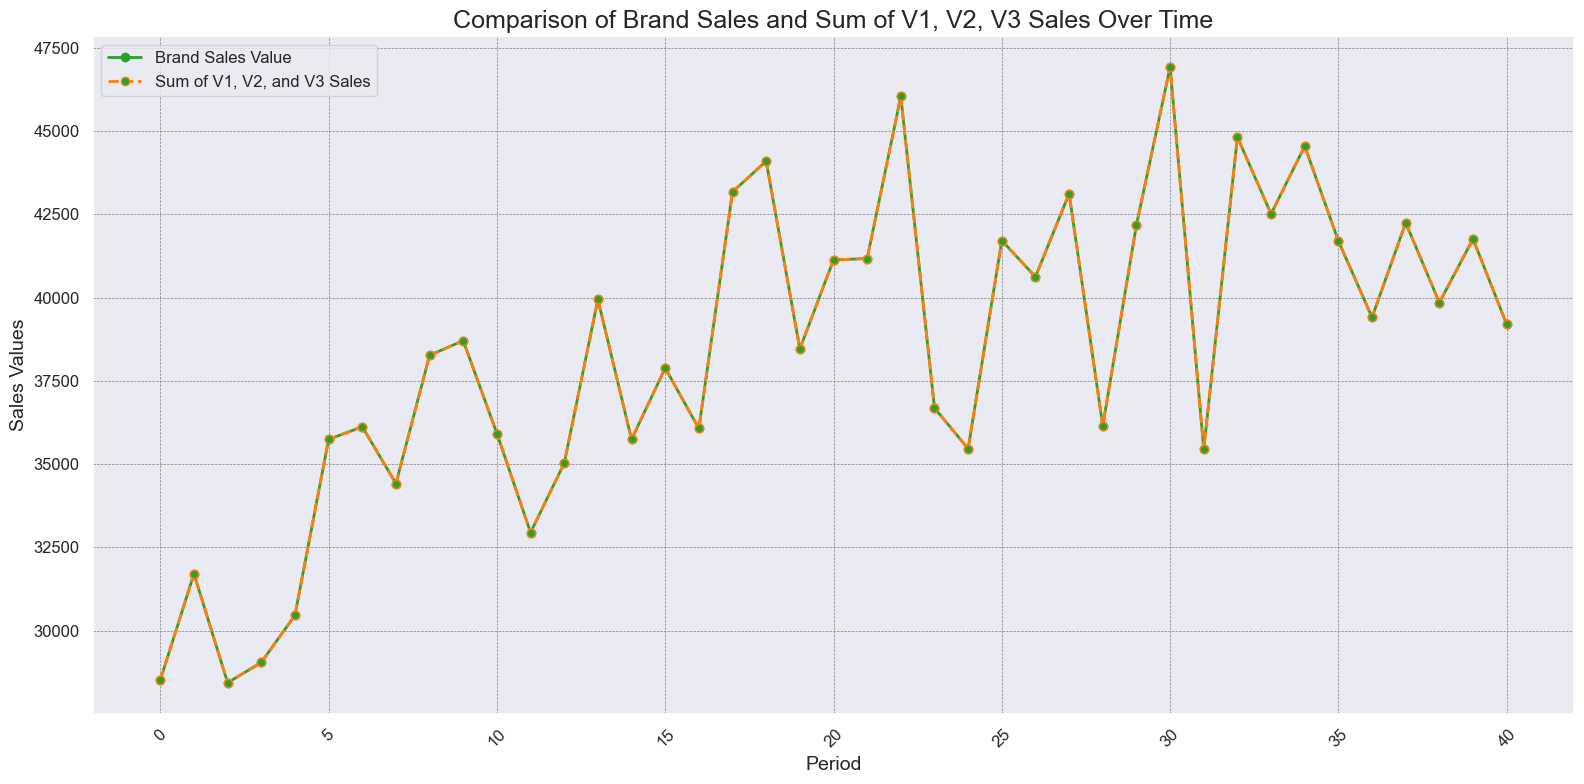

In [1361]:
# Add a new column that sums v1_sales, v2_sales, and v3_sales
final_data['Sum_v_sales'] = final_data['V1_Sales_Value'] + final_data['V2_Sales_Value'] + final_data['V3_Sales_Value']

# Check if Brand_sales matches the sum of v1_sales, v2_sales, and v3_sales
final_data['Check'] = final_data['Brand_Sales_Value'] == final_data['Sum_v_sales']

# Display rows where Brand_sales is not equal to the sum
discrepancies = final_data[~final_data['Check']]
final_data.sort_index(inplace=True)

# Plot the data
plt.figure(figsize=(16, 8))

# Plot Brand_Sales_Value with green points and a solid line
plt.plot(
    final_data.index, final_data['Brand_Sales_Value'],
    label='Brand Sales Value', marker='o', linestyle='-', color='#2ca02c', linewidth=2, markersize=6
)

# Plot Sum_v_sales with orange points and a dashed line
plt.plot(
    final_data.index, final_data['Sum_v_sales'],
    label='Sum of V1, V2, and V3 Sales', marker='o', linestyle='--', color='#ff7f0e', linewidth=2, markersize=6, markerfacecolor='#2ca02c'
)

# Customizing the plot
plt.title('Comparison of Brand Sales and Sum of V1, V2, V3 Sales Over Time', fontsize=18)
plt.xlabel('Period', fontsize=14)
plt.ylabel('Sales Values', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.legend(fontsize=12, loc='upper left')

# Adding background color for better readability
plt.gca().set_facecolor('#eaeaf2')

plt.tight_layout()

# Display the plot
plt.show()


**Observations from the Plot**

1. **Consistency in Sales Values**:
   - The **Brand Sales Value** and the **Sum of V1, V2, and V3 Sales** are closely aligned, indicating that the aggregated sales data for individual product categories accurately reflects the total brand sales.

2. **Minimal Discrepancies**:
   - Across all time periods, the two lines almost overlap perfectly, highlighting minimal or no discrepancies between the reported brand sales and the sum of individual product sales.

3. **Trends Over Time**:
   - Both sales metrics exhibit a similar upward trend with periodic fluctuations, suggesting potential seasonal variations or market dynamics affecting sales performance.

4. **Stability**:
   - The sales data appears stable over time, with consistent growth observed, indicating strong brand performance and well-distributed product contributions.

5. **Insight**:
   - This alignment between the brand sales and individual sales categories indicates a reliable data aggregation process, which supports decision-making and analysis based on accurate sales metrics.


#### create month dummies

In [1362]:
# Map month names to numbers
month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}
# Extract the year and filter for 2011-2014
final_data['Month'] = final_data['Period'].dt.month_name()
# Replace month names with their corresponding numbers
final_data['Month'] = final_data['Month'].map(month_mapping)

# Create monthly dummies using the updated 'Month' column
monthly_dummies = pd.get_dummies(final_data['Month'], prefix='month', prefix_sep='_')

# Convert dummies to integer type
monthly_dummies = monthly_dummies.astype(int)

# Merge the dummies back into the dataframe
final_data = pd.concat([final_data, monthly_dummies], axis=1)


# <b>Linear Regression Model<b>

### Brand

In [1363]:
# Dependent
target_var = 'Brand_Sales_Value'

# Independent
feature_columns = [
    'Brand_Avg_Price_per_SU',
    'Brand_Shipment',
    'Brand_SocialAd_fbAd_Likes_Dgtl',
    'month_3',
    'month_7',
    'month_12'
]
X_data = final_data[feature_columns]
y_data = final_data[target_var]

# Split the data into training and testing sets
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
linear_model = LinearRegression()

# Fit the model on the training data
linear_model.fit(X_train_data, y_train_data)

# Predict on the test set
y_predictions = linear_model.predict(X_test_data)

# Compute evaluation metrics
mse_value = mean_squared_error(y_test_data, y_predictions)
mape_value = mean_absolute_percentage_error(y_test_data, y_predictions) * 100
r2_value = r2_score(y_test_data, y_predictions)


# Adjusted R²
num_observations = len(y_test_data)  # Number of observations
num_features = X_test_data.shape[1]  # Number of predictors
adjusted_r2 = 1 - ((1 - r2_value) * (num_observations - 1) / (num_observations - num_features - 1))

# Display the results
print("Linear Regression Model Evaluation Metrics:")
print(f"Mean Absolute Percentage Error (MAPE): {mape_value:.2f}%")
print(f"R² Score: {r2_value:.3f}")
print(f"Adjusted R² Score: {adjusted_r2:.3f}")


Linear Regression Model Evaluation Metrics:
Mean Absolute Percentage Error (MAPE): 3.05%
R² Score: 0.828
Adjusted R² Score: 0.313


### Actual vs Predicted Sales Value for Brand

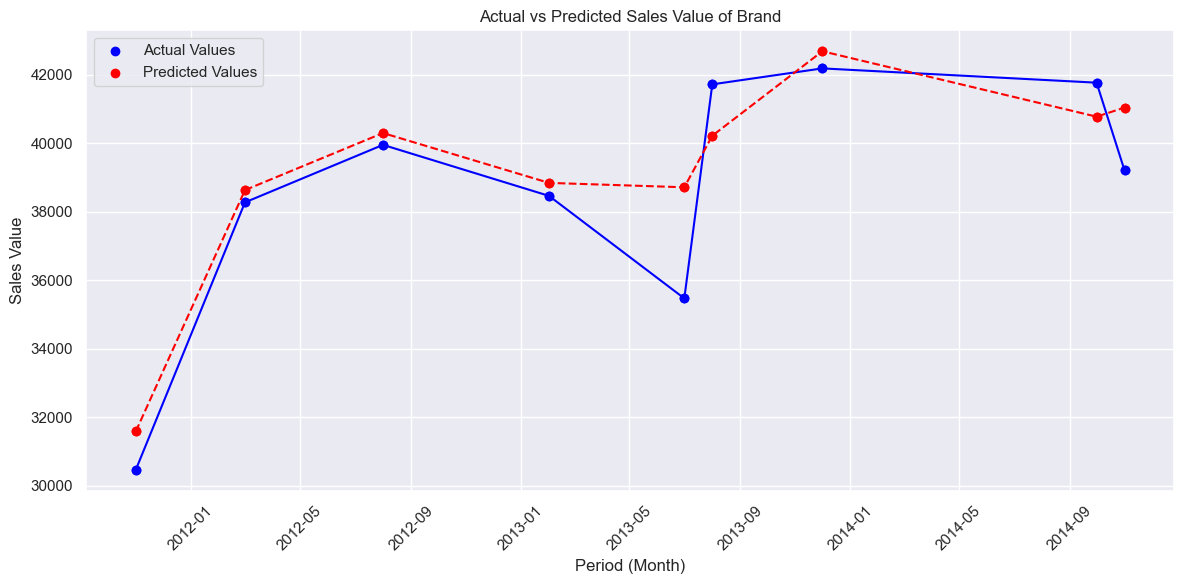

In [1364]:
import matplotlib.pyplot as plt

# Create a DataFrame for test data with actual and predicted values
test_comparison_df = pd.DataFrame({
    'Period': final_data.loc[X_test_data.index, 'Period'],  # Extract periods corresponding to the test set
    'Actual': y_test_data,
    'Predicted': y_predictions
}).sort_values(by='Period')  # Ensure the Period column is sorted

# Create scatter and line plots for actual and predicted sales by Period
plt.figure(figsize=(12, 6))

# Scatter and line plot for actual values
plt.scatter(test_comparison_df['Period'], test_comparison_df['Actual'], label='Actual Values', color='blue')
plt.plot(test_comparison_df['Period'], test_comparison_df['Actual'], color='blue', linestyle='-', marker='o')

# Scatter and line plot for predicted values
plt.scatter(test_comparison_df['Period'], test_comparison_df['Predicted'], label='Predicted Values', color='red')
plt.plot(test_comparison_df['Period'], test_comparison_df['Predicted'], color='red', linestyle='--', marker='o')

# Customize the plot
plt.xlabel('Period (Month)')
plt.ylabel('Sales Value')
plt.title('Actual vs Predicted Sales Value of Brand')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()



### V1

### Adstock for TV GRP

In [1365]:
# Adstock function
def calculate_adstock(series, decay):
    adstock = np.zeros(len(series))
    for t in range(len(series)):
        if t == 0:
            adstock[t] = series.iloc[t]
        else:
            adstock[t] = series.iloc[t] + decay * adstock[t-1]
    return adstock

# Apply adstock transformation to one variable
decay_factor = 0.7  # Set the decay factor
final_data['Adstock_V1_TV_Total_GRP_AOR'] = calculate_adstock(final_data['V1_TV_Total_ISP&TV_GRP_AOR'], decay_factor)

# Display first few rows for verification
final_data[['V1_TV_Total_ISP&TV_GRP_AOR', 'Adstock_V1_TV_Total_GRP_AOR']].head()


V1_TV_Total_ISP&TV_GRP_AOR  Adstock_V1_TV_Total_GRP_AOR
0                       200.0                       200.00
1                       100.0                       240.00
2                       100.0                       268.00
3                        91.0                       278.60
4                       686.0                       881.02

In [1366]:
# Dependent
target_var = 'V1_Sales_Value'

# Independent
feature_columns = [
    'V1_IMedia_Total_Clks_Dgtl',
    'V1_IMedia_Total_Imp_Dgtl',
    'Adstock_V1_TV_Total_GRP_AOR',
    'month_7',
    'month_8',
    'month_11'
]
X_data = final_data[feature_columns]
y_data = final_data[target_var]

# Split the data into training and testing sets
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
linear_model = LinearRegression()

# Fit the model on the training data
linear_model.fit(X_train_data, y_train_data)

# Predict on the test set
y_predictions = linear_model.predict(X_test_data)

# Compute evaluation metrics
mse_value = mean_squared_error(y_test_data, y_predictions)
mape_value = mean_absolute_percentage_error(y_test_data, y_predictions) * 100
r2_value = r2_score(y_test_data, y_predictions)


# Adjusted R²
num_observations = len(y_test_data)  # Number of observations
num_features = X_test_data.shape[1]  # Number of predictors
adjusted_r2 = 1 - ((1 - r2_value) * (num_observations - 1) / (num_observations - num_features - 1))

# Display the results
print("Linear Regression Model Evaluation Metrics:")
print(f"Mean Absolute Percentage Error (MAPE): {mape_value:.2f}%")
print(f"R² Score: {r2_value:.3f}")
print(f"Adjusted R² Score: {adjusted_r2:.3f}")

Linear Regression Model Evaluation Metrics:
Mean Absolute Percentage Error (MAPE): 3.49%
R² Score: 0.849
Adjusted R² Score: 0.395


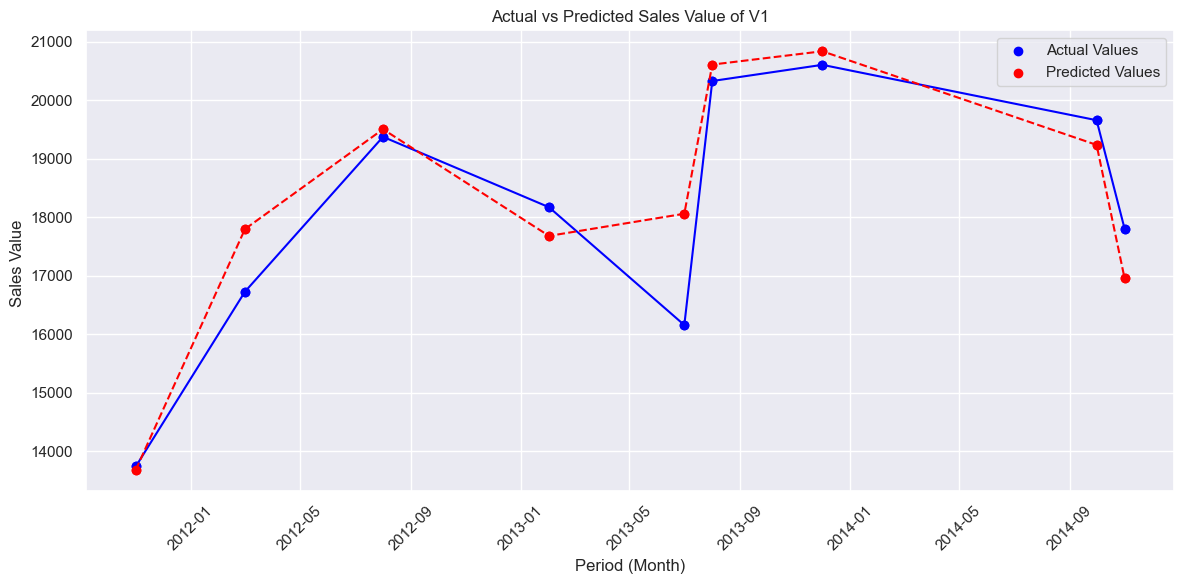

In [1367]:

# Create a DataFrame for test data with actual and predicted values
test_comparison_df = pd.DataFrame({
    'Period': final_data.loc[X_test_data.index, 'Period'],  # Extract periods corresponding to the test set
    'Actual': y_test_data,
    'Predicted': y_predictions
}).sort_values(by='Period')  # Ensure the Period column is sorted

# Create scatter and line plots for actual and predicted sales by Period
plt.figure(figsize=(12, 6))

# Scatter and line plot for actual values
plt.scatter(test_comparison_df['Period'], test_comparison_df['Actual'], label='Actual Values', color='blue')
plt.plot(test_comparison_df['Period'], test_comparison_df['Actual'], color='blue', linestyle='-', marker='o')

# Scatter and line plot for predicted values
plt.scatter(test_comparison_df['Period'], test_comparison_df['Predicted'], label='Predicted Values', color='red')
plt.plot(test_comparison_df['Period'], test_comparison_df['Predicted'], color='red', linestyle='--', marker='o')

# Customize the plot
plt.xlabel('Period (Month)')
plt.ylabel('Sales Value ')
plt.title('Actual vs Predicted Sales Value of V1')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


### V2

In [1368]:
# Dependent
target_var = 'V2_Sales_Value'

# Independent
feature_columns = [
    'V2_Avg_Price_per_SU',
    'V1_TV_Total_ISP&TV_Spends_AOR',
    'V1_NUMD',
    'V1_IMedia_Total_Imp_Dgtl',
    'Adstock_V1_TV_Total_GRP_AOR',
    'month_1',
    'month_3',
    'month_7',
    'month_5',
    'month_9'    
]
X_data = final_data[feature_columns]
y_data = final_data[target_var]

# Split the data into training and testing sets
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
linear_model = LinearRegression()

# Fit the model on the training data
linear_model.fit(X_train_data, y_train_data)

# Predict on the test set
y_predictions = linear_model.predict(X_test_data)

# Compute evaluation metrics
mse_value = mean_squared_error(y_test_data, y_predictions)
mape_value = mean_absolute_percentage_error(y_test_data, y_predictions) * 100
r2_value = r2_score(y_test_data, y_predictions)


# Adjusted R²
num_observations = len(y_test_data)  # Number of observations
num_features = X_test_data.shape[1]  # Number of predictors
adjusted_r2 = 1 - ((1 - r2_value) * (num_observations - 1) / (num_observations - num_features - 1))

# Display the results
print("Linear Regression Model Evaluation Metrics:")
print(f"Mean Absolute Percentage Error (MAPE): {mape_value:.2f}%")
print(f"R² Score: {r2_value:.3f}")
print(f"Adjusted R² Score: {adjusted_r2:.3f}")

Linear Regression Model Evaluation Metrics:
Mean Absolute Percentage Error (MAPE): 2.43%
R² Score: 0.787
Adjusted R² Score: 1.851


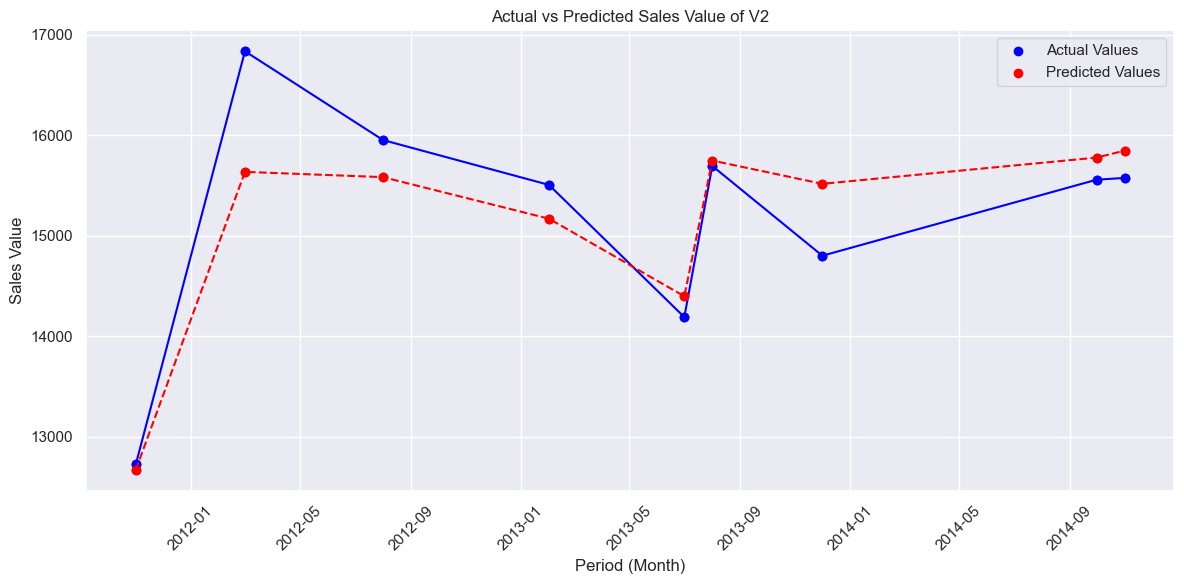

In [1369]:
# Create a DataFrame for test data with actual and predicted values
test_comparison_df = pd.DataFrame({
    'Period': final_data.loc[X_test_data.index, 'Period'],  # Extract periods corresponding to the test set
    'Actual': y_test_data,
    'Predicted': y_predictions
}).sort_values(by='Period')  # Ensure the Period column is sorted

# Create scatter and line plots for actual and predicted sales by Period
plt.figure(figsize=(12, 6))

# Scatter and line plot for actual values
plt.scatter(test_comparison_df['Period'], test_comparison_df['Actual'], label='Actual Values', color='blue')
plt.plot(test_comparison_df['Period'], test_comparison_df['Actual'], color='blue', linestyle='-', marker='o')

# Scatter and line plot for predicted values
plt.scatter(test_comparison_df['Period'], test_comparison_df['Predicted'], label='Predicted Values', color='red')
plt.plot(test_comparison_df['Period'], test_comparison_df['Predicted'], color='red', linestyle='--', marker='o')

# Customize the plot
plt.xlabel('Period (Month)')
plt.ylabel('Sales Value')
plt.title('Actual vs Predicted Sales Value of V2')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

### V3

In [1370]:
# Dependent
target_var = 'V3_Sales_Value'

# Independent
feature_columns = [
    'V3_Shipment',
    'V3_Avg_Price_per_SU',
    'V1_TV_Total_ISP&TV_Spends_AOR',
    'V1_TV_ISP_Spends_AOR',
    'V1_IMedia_Total_Imp_Dgtl',
    'Adstock_V1_TV_Total_GRP_AOR',
    'V1_IMedia_Total_Spends_Dgtl',
    'month_1',
    'month_6',
    'month_8',
    'month_12',   
]
X_data = final_data[feature_columns]
y_data = final_data[target_var]

# Split the data into training and testing sets
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
linear_model = LinearRegression()

# Fit the model on the training data
linear_model.fit(X_train_data, y_train_data)

# Predict on the test set
y_predictions = linear_model.predict(X_test_data)

# Compute evaluation metrics
mse_value = mean_squared_error(y_test_data, y_predictions)
mape_value = mean_absolute_percentage_error(y_test_data, y_predictions) * 100
r2_value = r2_score(y_test_data, y_predictions)


# Adjusted R²
num_observations = len(y_test_data)  # Number of observations
num_features = X_test_data.shape[1]  # Number of predictors
adjusted_r2 = 1 - ((1 - r2_value) * (num_observations - 1) / (num_observations - num_features - 1))

# Display the results
print("Linear Regression Model Evaluation Metrics:")
print(f"Mean Absolute Percentage Error (MAPE): {mape_value:.2f}%")
print(f"R² Score: {r2_value:.3f}")
print(f"Adjusted R² Score: {adjusted_r2:.3f}")

Linear Regression Model Evaluation Metrics:
Mean Absolute Percentage Error (MAPE): 4.59%
R² Score: 0.896
Adjusted R² Score: 1.276


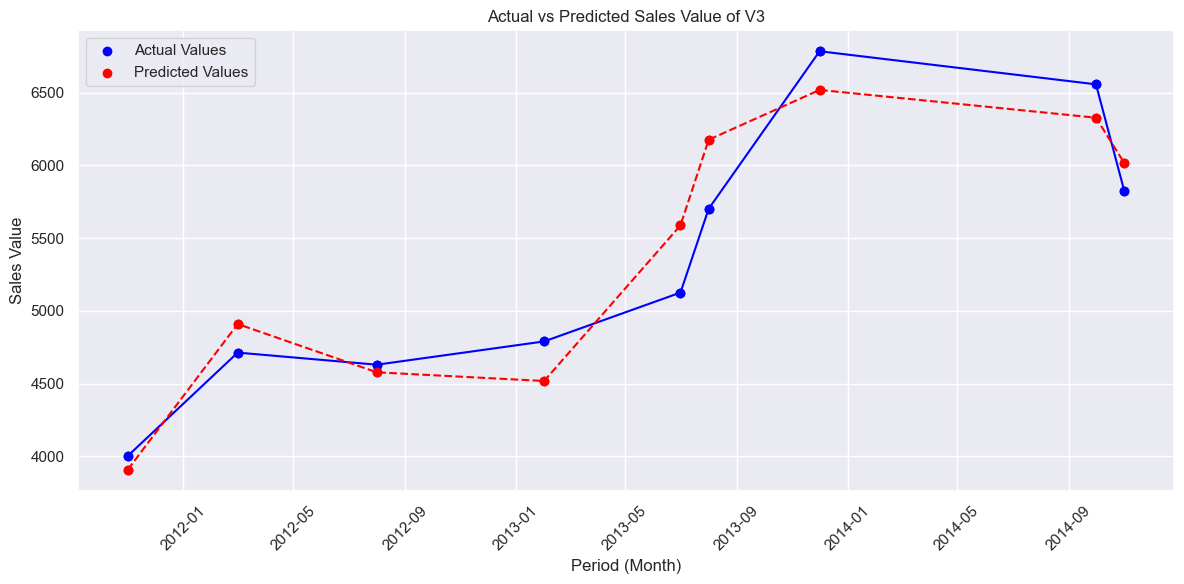

In [1371]:
# Create a DataFrame for test data with actual and predicted values
test_comparison_df = pd.DataFrame({
    'Period': final_data.loc[X_test_data.index, 'Period'],  # Extract periods corresponding to the test set
    'Actual': y_test_data,
    'Predicted': y_predictions
}).sort_values(by='Period')  # Ensure the Period column is sorted

# Create scatter and line plots for actual and predicted sales by Period
plt.figure(figsize=(12, 6))

# Scatter and line plot for actual values
plt.scatter(test_comparison_df['Period'], test_comparison_df['Actual'], label='Actual Values', color='blue')
plt.plot(test_comparison_df['Period'], test_comparison_df['Actual'], color='blue', linestyle='-', marker='o')

# Scatter and line plot for predicted values
plt.scatter(test_comparison_df['Period'], test_comparison_df['Predicted'], label='Predicted Values', color='red')
plt.plot(test_comparison_df['Period'], test_comparison_df['Predicted'], color='red', linestyle='--', marker='o')

# Customize the plot
plt.xlabel('Period (Month)')
plt.ylabel('Sales Value')
plt.title('Actual vs Predicted Sales Value of V3')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

# <b>Lasso Regression Model<b>

### Brand 

In [1372]:
# Dependent
target_var = 'Brand_Sales_Value'

# Independent
feature_columns = [
    'Brand_Avg_Price_per_SU',
    'Brand_Shipment',
    'Brand_SocialAd_fbAd_Likes_Dgtl',
    'month_3',
    'month_7',
    'month_12'
]
X_data = final_data[feature_columns]
y_data = final_data[target_var]

# Split the data into training and testing sets
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
lasso = Lasso(alpha=1.0)

# Fit the model on the training data
lasso.fit(X_train_data, y_train_data)

# Predict on the test set
y_predictions = lasso.predict(X_test_data)

# Compute evaluation metrics
mse_value = mean_squared_error(y_test_data, y_predictions)
mape_value = mean_absolute_percentage_error(y_test_data, y_predictions) * 100
r2_value = r2_score(y_test_data, y_predictions)


# Adjusted R²
num_observations = len(y_test_data)  # Number of observations
num_features = X_test_data.shape[1]  # Number of predictors
adjusted_r2 = 1 - ((1 - r2_value) * (num_observations - 1) / (num_observations - num_features - 1))

# Display the results
print("Lasso Regression Model Evaluation Metrics:")
print(f"Mean Absolute Percentage Error (MAPE): {mape_value:.2f}%")
print(f"R² Score: {r2_value:.3f}")
print(f"Adjusted R² Score: {adjusted_r2:.3f}")

Lasso Regression Model Evaluation Metrics:
Mean Absolute Percentage Error (MAPE): 3.04%
R² Score: 0.828
Adjusted R² Score: 0.312


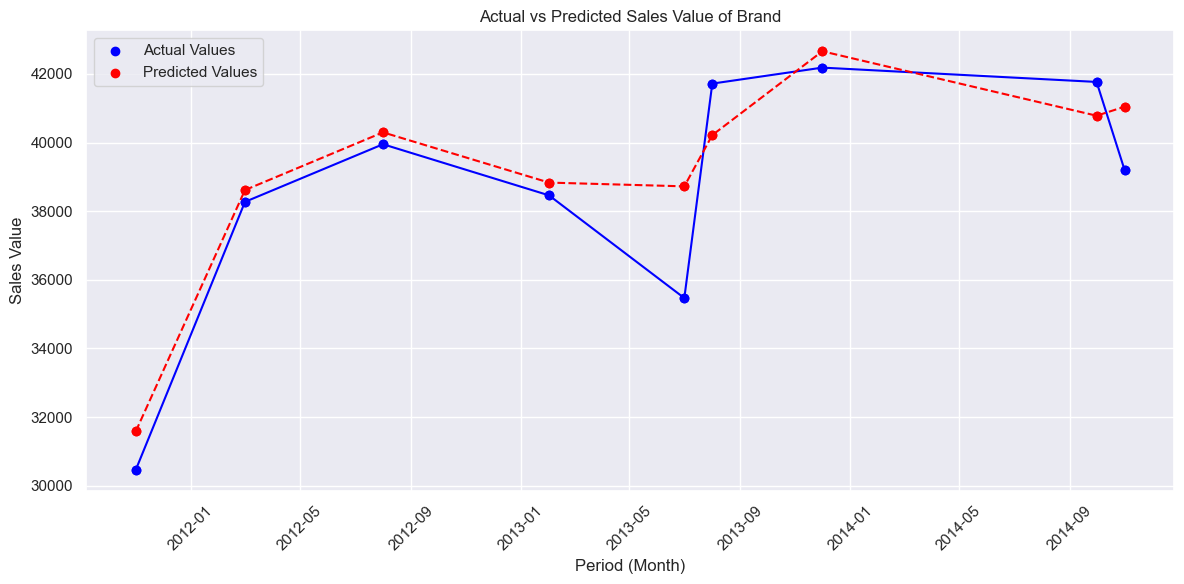

In [1373]:
# Create a DataFrame for test data with actual and predicted values
test_comparison_df = pd.DataFrame({
    'Period': final_data.loc[X_test_data.index, 'Period'],  # Extract periods corresponding to the test set
    'Actual': y_test_data,
    'Predicted': y_predictions
}).sort_values(by='Period')  # Ensure the Period column is sorted

# Create scatter and line plots for actual and predicted sales by Period
plt.figure(figsize=(12, 6))

# Scatter and line plot for actual values
plt.scatter(test_comparison_df['Period'], test_comparison_df['Actual'], label='Actual Values', color='blue')
plt.plot(test_comparison_df['Period'], test_comparison_df['Actual'], color='blue', linestyle='-', marker='o')

# Scatter and line plot for predicted values
plt.scatter(test_comparison_df['Period'], test_comparison_df['Predicted'], label='Predicted Values', color='red')
plt.plot(test_comparison_df['Period'], test_comparison_df['Predicted'], color='red', linestyle='--', marker='o')

# Customize the plot
plt.xlabel('Period (Month)')
plt.ylabel('Sales Value')
plt.title('Actual vs Predicted Sales Value of Brand')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

### V1

In [1374]:
# Dependent
target_var = 'V1_Sales_Value'

# Independent
feature_columns = [
    'V1_IMedia_Total_Clks_Dgtl',
    'V1_IMedia_Total_Imp_Dgtl',
    'Adstock_V1_TV_Total_GRP_AOR',
    'month_7',
    'month_8',
    'month_11'
]
X_data = final_data[feature_columns]
y_data = final_data[target_var]

# Split the data into training and testing sets
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Initialize the Lasso Regression model
lasso = Lasso(alpha=1.0)

# Fit the model on the training data
lasso.fit(X_train_data, y_train_data)

# Predict on the test set
y_predictions = lasso.predict(X_test_data)

# Compute evaluation metrics
mse_value = mean_squared_error(y_test_data, y_predictions)
mape_value = mean_absolute_percentage_error(y_test_data, y_predictions) * 100
r2_value = r2_score(y_test_data, y_predictions)


# Adjusted R²
num_observations = len(y_test_data)  # Number of observations
num_features = X_test_data.shape[1]  # Number of predictors
adjusted_r2 = 1 - ((1 - r2_value) * (num_observations - 1) / (num_observations - num_features - 1))

# Display the results
print("Lasso Regression Model Evaluation Metrics:")
print(f"Mean Absolute Percentage Error (MAPE): {mape_value:.2f}%")
print(f"R² Score: {r2_value:.3f}")
print(f"Adjusted R² Score: {adjusted_r2:.3f}")

Lasso Regression Model Evaluation Metrics:
Mean Absolute Percentage Error (MAPE): 3.44%
R² Score: 0.849
Adjusted R² Score: 0.396


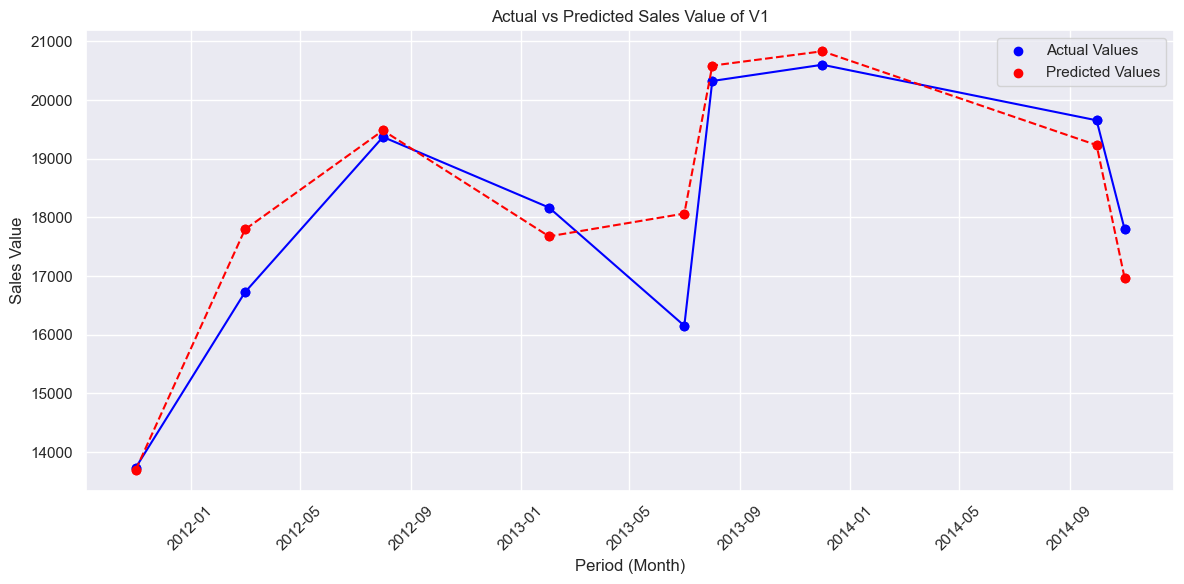

In [1375]:
# Create a DataFrame for test data with actual and predicted values
test_comparison_df = pd.DataFrame({
    'Period': final_data.loc[X_test_data.index, 'Period'],  # Extract periods corresponding to the test set
    'Actual': y_test_data,
    'Predicted': y_predictions
}).sort_values(by='Period')  # Ensure the Period column is sorted

# Create scatter and line plots for actual and predicted sales by Period
plt.figure(figsize=(12, 6))

# Scatter and line plot for actual values
plt.scatter(test_comparison_df['Period'], test_comparison_df['Actual'], label='Actual Values', color='blue')
plt.plot(test_comparison_df['Period'], test_comparison_df['Actual'], color='blue', linestyle='-', marker='o')

# Scatter and line plot for predicted values
plt.scatter(test_comparison_df['Period'], test_comparison_df['Predicted'], label='Predicted Values', color='red')
plt.plot(test_comparison_df['Period'], test_comparison_df['Predicted'], color='red', linestyle='--', marker='o')

# Customize the plot
plt.xlabel('Period (Month)')
plt.ylabel('Sales Value')
plt.title('Actual vs Predicted Sales Value of V1')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

### V2

In [1376]:
# Dependent
target_var = 'V2_Sales_Value'

# Independent
feature_columns = [
    'V2_Avg_Price_per_SU',
    'V1_TV_Total_ISP&TV_Spends_AOR',
    'V1_NUMD',
    'V1_IMedia_Total_Imp_Dgtl',
    'Adstock_V1_TV_Total_GRP_AOR',
    'month_1',
    'month_3',
    'month_7',
    'month_5',
    'month_9'    
]
X_data = final_data[feature_columns]
y_data = final_data[target_var]

# Split the data into training and testing sets
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Initialize the Lasso Regression model
lasso = Lasso(alpha=1.0)

# Fit the model on the training data
lasso.fit(X_train_data, y_train_data)

# Predict on the test set
y_predictions = lasso.predict(X_test_data)

# Compute evaluation metrics
mse_value = mean_squared_error(y_test_data, y_predictions)
mape_value = mean_absolute_percentage_error(y_test_data, y_predictions) * 100
r2_value = r2_score(y_test_data, y_predictions)


# Adjusted R²
num_observations = len(y_test_data)  # Number of observations
num_features = X_test_data.shape[1]  # Number of predictors
adjusted_r2 = 1 - ((1 - r2_value) * (num_observations - 1) / (num_observations - num_features - 1))

# Display the results
print("Lasso Regression Model Evaluation Metrics:")
print(f"Mean Absolute Percentage Error (MAPE): {mape_value:.2f}%")
print(f"R² Score: {r2_value:.3f}")
print(f"Adjusted R² Score: {adjusted_r2:.3f}")

Lasso Regression Model Evaluation Metrics:
Mean Absolute Percentage Error (MAPE): 2.44%
R² Score: 0.781
Adjusted R² Score: 1.876


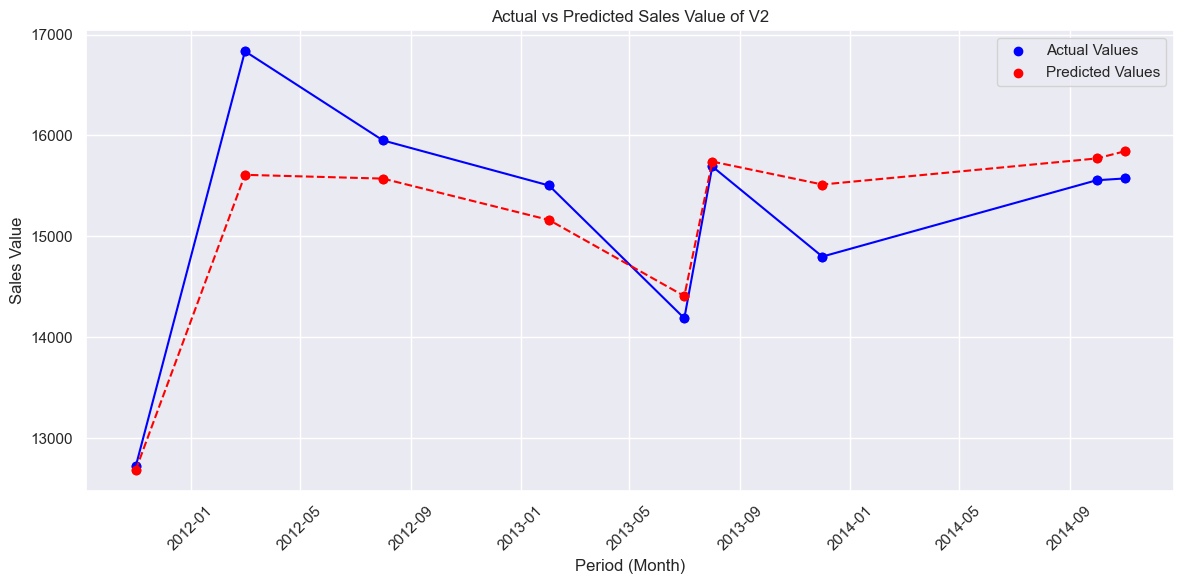

In [1377]:
# Create a DataFrame for test data with actual and predicted values
test_comparison_df = pd.DataFrame({
    'Period': final_data.loc[X_test_data.index, 'Period'],  # Extract periods corresponding to the test set
    'Actual': y_test_data,
    'Predicted': y_predictions
}).sort_values(by='Period')  # Ensure the Period column is sorted

# Create scatter and line plots for actual and predicted sales by Period
plt.figure(figsize=(12, 6))

# Scatter and line plot for actual values
plt.scatter(test_comparison_df['Period'], test_comparison_df['Actual'], label='Actual Values', color='blue')
plt.plot(test_comparison_df['Period'], test_comparison_df['Actual'], color='blue', linestyle='-', marker='o')

# Scatter and line plot for predicted values
plt.scatter(test_comparison_df['Period'], test_comparison_df['Predicted'], label='Predicted Values', color='red')
plt.plot(test_comparison_df['Period'], test_comparison_df['Predicted'], color='red', linestyle='--', marker='o')

# Customize the plot
plt.xlabel('Period (Month)')
plt.ylabel('Sales Value')
plt.title('Actual vs Predicted Sales Value of V2')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

### V3

In [1378]:
# Dependent
target_var = 'V3_Sales_Value'

# Independent
feature_columns = [
    'V3_Shipment',
    'V3_Avg_Price_per_SU',
    'V1_TV_Total_ISP&TV_Spends_AOR',
    'V1_TV_ISP_Spends_AOR',
    'V1_IMedia_Total_Imp_Dgtl',
    'Adstock_V1_TV_Total_GRP_AOR',
    'V1_IMedia_Total_Spends_Dgtl',
    'month_1',
    'month_6',
    'month_8',
    'month_12',   
]
X_data = final_data[feature_columns]
y_data = final_data[target_var]

# Split the data into training and testing sets
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Initialize the Lasso Regression model
lasso = Lasso(alpha=1.0)

# Fit the model on the training data
lasso.fit(X_train_data, y_train_data)

# Predict on the test set
y_predictions = lasso.predict(X_test_data)

# Compute evaluation metrics
mse_value = mean_squared_error(y_test_data, y_predictions)
mape_value = mean_absolute_percentage_error(y_test_data, y_predictions) * 100
r2_value = r2_score(y_test_data, y_predictions)


# Adjusted R²
num_observations = len(y_test_data)  # Number of observations
num_features = X_test_data.shape[1]  # Number of predictors
adjusted_r2 = 1 - ((1 - r2_value) * (num_observations - 1) / (num_observations - num_features - 1))

# Display the results
print("Lasso Regression Model Evaluation Metrics:")
print(f"Mean Absolute Percentage Error (MAPE): {mape_value:.2f}%")
print(f"R² Score: {r2_value:.3f}")
print(f"Adjusted R² Score: {adjusted_r2:.3f}")

Lasso Regression Model Evaluation Metrics:
Mean Absolute Percentage Error (MAPE): 4.63%
R² Score: 0.890
Adjusted R² Score: 1.294


C:\Users\vaish\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.308e+06, tolerance: 4.061e+03
  model = cd_fast.enet_coordinate_descent(


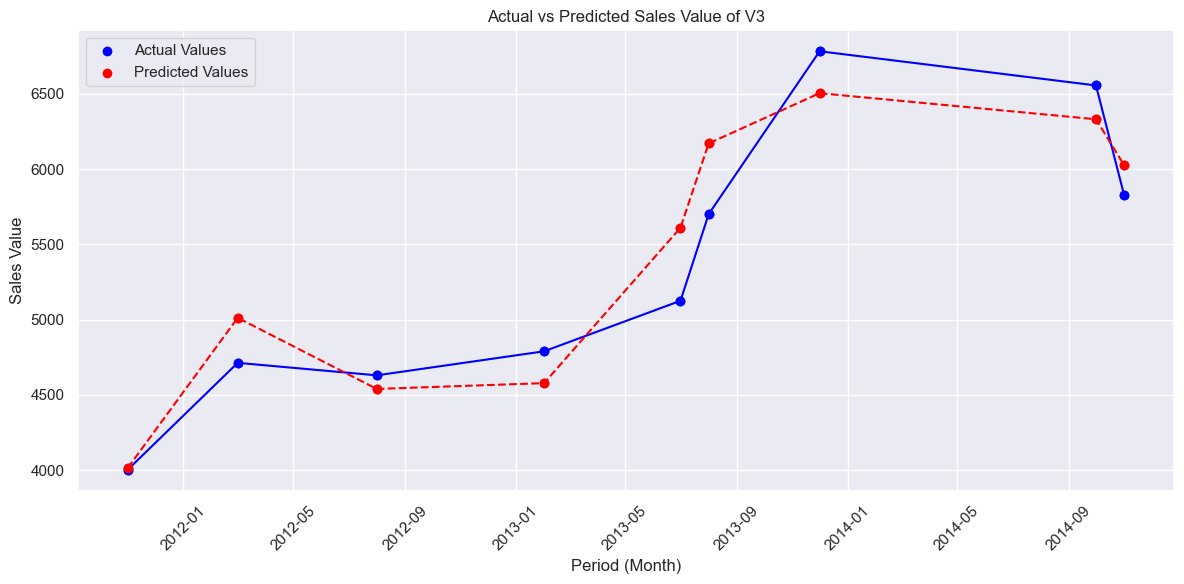

In [1379]:
# Create a DataFrame for test data with actual and predicted values
test_comparison_df = pd.DataFrame({
    'Period': final_data.loc[X_test_data.index, 'Period'],  # Extract periods corresponding to the test set
    'Actual': y_test_data,
    'Predicted': y_predictions
}).sort_values(by='Period')  # Ensure the Period column is sorted

# Create scatter and line plots for actual and predicted sales by Period
plt.figure(figsize=(12, 6))

# Scatter and line plot for actual values
plt.scatter(test_comparison_df['Period'], test_comparison_df['Actual'], label='Actual Values', color='blue')
plt.plot(test_comparison_df['Period'], test_comparison_df['Actual'], color='blue', linestyle='-', marker='o')

# Scatter and line plot for predicted values
plt.scatter(test_comparison_df['Period'], test_comparison_df['Predicted'], label='Predicted Values', color='red')
plt.plot(test_comparison_df['Period'], test_comparison_df['Predicted'], color='red', linestyle='--', marker='o')

# Customize the plot
plt.xlabel('Period (Month)')
plt.ylabel('Sales Value')
plt.title('Actual vs Predicted Sales Value of V3')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

## <b>Ridge Regression Model

### Brand

In [1380]:
# Dependent
target_var = 'Brand_Sales_Value'

# Independent
feature_columns = [
    'Brand_Avg_Price_per_SU',
    'Brand_Shipment',
    'Brand_SocialAd_fbAd_Likes_Dgtl',
    'month_3',
    'month_7',
    'month_12'
]
X_data = final_data[feature_columns]
y_data = final_data[target_var]

# Split the data into training and testing sets
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Initialize the Ridge Regression model
ridge = Ridge(alpha=1.0)

# Fit the model on the training data
ridge.fit(X_train_data, y_train_data)

# Predict on the test set
y_predictions = ridge.predict(X_test_data)

# Compute evaluation metrics
mse_value = mean_squared_error(y_test_data, y_predictions)
mape_value = mean_absolute_percentage_error(y_test_data, y_predictions) * 100
r2_value = r2_score(y_test_data, y_predictions)


# Adjusted R²
num_observations = len(y_test_data)  # Number of observations
num_features = X_test_data.shape[1]  # Number of predictors
adjusted_r2 = 1 - ((1 - r2_value) * (num_observations - 1) / (num_observations - num_features - 1))

# Display the results
print("Ridge Regression Model Evaluation Metrics:")
print(f"Mean Absolute Percentage Error (MAPE): {mape_value:.2f}%")
print(f"R² Score: {r2_value:.3f}")
print(f"Adjusted R² Score: {adjusted_r2:.3f}")

Ridge Regression Model Evaluation Metrics:
Mean Absolute Percentage Error (MAPE): 3.14%
R² Score: 0.779
Adjusted R² Score: 0.118


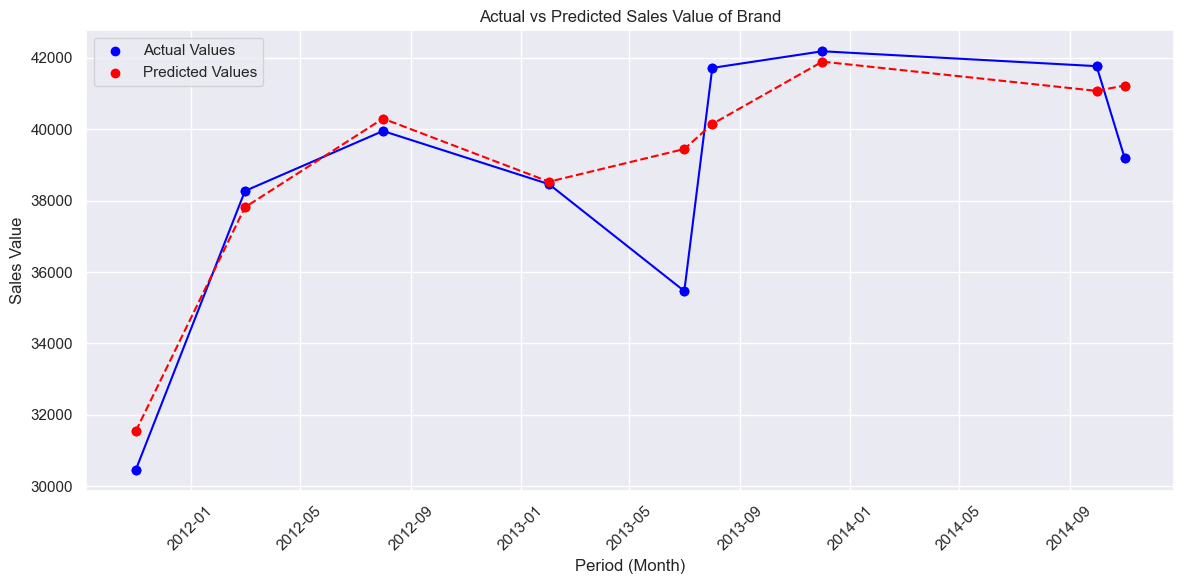

In [1381]:
# Create a DataFrame for test data with actual and predicted values
test_comparison_df = pd.DataFrame({
    'Period': final_data.loc[X_test_data.index, 'Period'],  # Extract periods corresponding to the test set
    'Actual': y_test_data,
    'Predicted': y_predictions
}).sort_values(by='Period')  # Ensure the Period column is sorted

# Create scatter and line plots for actual and predicted sales by Period
plt.figure(figsize=(12, 6))

# Scatter and line plot for actual values
plt.scatter(test_comparison_df['Period'], test_comparison_df['Actual'], label='Actual Values', color='blue')
plt.plot(test_comparison_df['Period'], test_comparison_df['Actual'], color='blue', linestyle='-', marker='o')

# Scatter and line plot for predicted values
plt.scatter(test_comparison_df['Period'], test_comparison_df['Predicted'], label='Predicted Values', color='red')
plt.plot(test_comparison_df['Period'], test_comparison_df['Predicted'], color='red', linestyle='--', marker='o')

# Customize the plot
plt.xlabel('Period (Month)')
plt.ylabel('Sales Value')
plt.title('Actual vs Predicted Sales Value of Brand')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

### V1 

In [1382]:
# Dependent
target_var = 'V1_Sales_Value'

# Independent
feature_columns = [
    'V1_IMedia_Total_Clks_Dgtl',
    'V1_IMedia_Total_Imp_Dgtl',
    'Adstock_V1_TV_Total_GRP_AOR',
    'month_7',
    'month_8',
    'month_11'
]
X_data = final_data[feature_columns]
y_data = final_data[target_var]

# Split the data into training and testing sets
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Initialize the Ridge Regression model
ridge = Ridge(alpha=1.0)

# Fit the model on the training data
ridge.fit(X_train_data, y_train_data)

# Predict on the test set
y_predictions = ridge.predict(X_test_data)

# Compute evaluation metrics
mse_value = mean_squared_error(y_test_data, y_predictions)
mape_value = mean_absolute_percentage_error(y_test_data, y_predictions) * 100
r2_value = r2_score(y_test_data, y_predictions)


# Adjusted R²
num_observations = len(y_test_data)  # Number of observations
num_features = X_test_data.shape[1]  # Number of predictors
adjusted_r2 = 1 - ((1 - r2_value) * (num_observations - 1) / (num_observations - num_features - 1))

# Display the results
print("Ridge Regression Model Evaluation Metrics:")
print(f"Mean Absolute Percentage Error (MAPE): {mape_value:.2f}%")
print(f"R² Score: {r2_value:.3f}")
print(f"Adjusted R² Score: {adjusted_r2:.3f}")

Ridge Regression Model Evaluation Metrics:
Mean Absolute Percentage Error (MAPE): 3.87%
R² Score: 0.833
Adjusted R² Score: 0.331


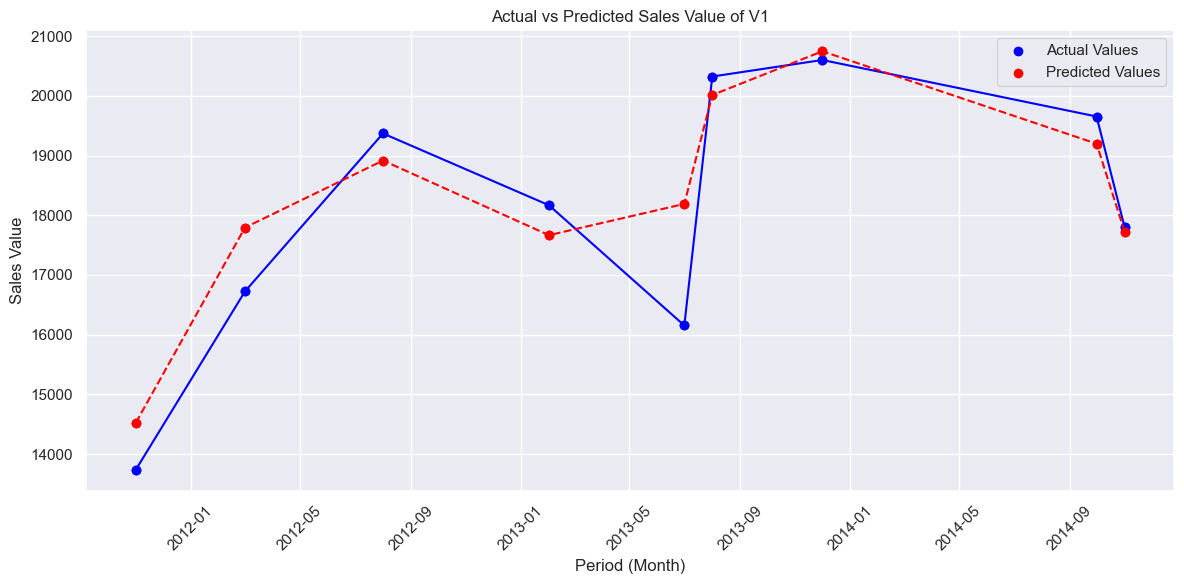

In [1383]:
# Create a DataFrame for test data with actual and predicted values
test_comparison_df = pd.DataFrame({
    'Period': final_data.loc[X_test_data.index, 'Period'],  # Extract periods corresponding to the test set
    'Actual': y_test_data,
    'Predicted': y_predictions
}).sort_values(by='Period')  # Ensure the Period column is sorted

# Create scatter and line plots for actual and predicted sales by Period
plt.figure(figsize=(12, 6))

# Scatter and line plot for actual values
plt.scatter(test_comparison_df['Period'], test_comparison_df['Actual'], label='Actual Values', color='blue')
plt.plot(test_comparison_df['Period'], test_comparison_df['Actual'], color='blue', linestyle='-', marker='o')

# Scatter and line plot for predicted values
plt.scatter(test_comparison_df['Period'], test_comparison_df['Predicted'], label='Predicted Values', color='red')
plt.plot(test_comparison_df['Period'], test_comparison_df['Predicted'], color='red', linestyle='--', marker='o')

# Customize the plot
plt.xlabel('Period (Month)')
plt.ylabel('Sales Value')
plt.title('Actual vs Predicted Sales Value of V1')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

### V2

In [1384]:
# Dependent
target_var = 'V2_Sales_Value'

# Independent
feature_columns = [
    'V2_Avg_Price_per_SU',
    'V1_TV_Total_ISP&TV_Spends_AOR',
    'V1_NUMD',
    'V1_IMedia_Total_Imp_Dgtl',
    'Adstock_V1_TV_Total_GRP_AOR',
    'month_1',
    'month_3',
    'month_7',
    'month_5',
    'month_9'    
]
X_data = final_data[feature_columns]
y_data = final_data[target_var]

# Split the data into training and testing sets
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Initialize the Ridge Regression model
ridge = Ridge(alpha=1.0)

# Fit the model on the training data
ridge.fit(X_train_data, y_train_data)

# Predict on the test set
y_predictions = ridge.predict(X_test_data)

# Compute evaluation metrics
mse_value = mean_squared_error(y_test_data, y_predictions)
mape_value = mean_absolute_percentage_error(y_test_data, y_predictions) * 100
r2_value = r2_score(y_test_data, y_predictions)


# Adjusted R²
num_observations = len(y_test_data)  # Number of observations
num_features = X_test_data.shape[1]  # Number of predictors
adjusted_r2 = 1 - ((1 - r2_value) * (num_observations - 1) / (num_observations - num_features - 1))

# Display the results
print("Ridge Regression Model Evaluation Metrics:")
print(f"Mean Absolute Percentage Error (MAPE): {mape_value:.2f}%")
print(f"R² Score: {r2_value:.3f}")
print(f"Adjusted R² Score: {adjusted_r2:.3f}")

Ridge Regression Model Evaluation Metrics:
Mean Absolute Percentage Error (MAPE): 3.40%
R² Score: 0.616
Adjusted R² Score: 2.537


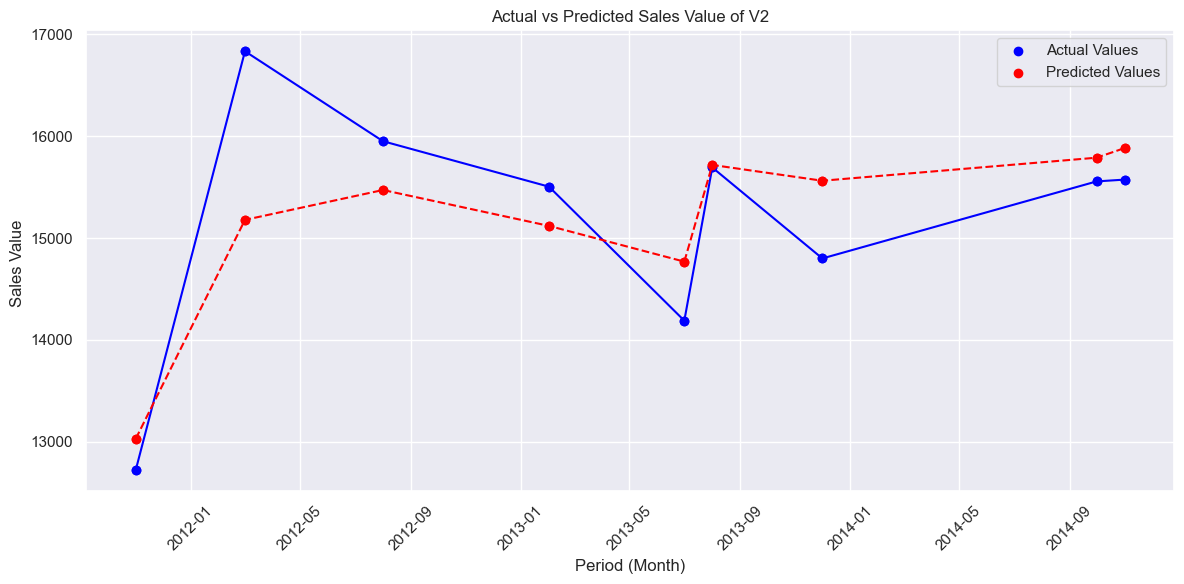

In [1385]:
# Create a DataFrame for test data with actual and predicted values
test_comparison_df = pd.DataFrame({
    'Period': final_data.loc[X_test_data.index, 'Period'],  # Extract periods corresponding to the test set
    'Actual': y_test_data,
    'Predicted': y_predictions
}).sort_values(by='Period')  # Ensure the Period column is sorted

# Create scatter and line plots for actual and predicted sales by Period
plt.figure(figsize=(12, 6))

# Scatter and line plot for actual values
plt.scatter(test_comparison_df['Period'], test_comparison_df['Actual'], label='Actual Values', color='blue')
plt.plot(test_comparison_df['Period'], test_comparison_df['Actual'], color='blue', linestyle='-', marker='o')

# Scatter and line plot for predicted values
plt.scatter(test_comparison_df['Period'], test_comparison_df['Predicted'], label='Predicted Values', color='red')
plt.plot(test_comparison_df['Period'], test_comparison_df['Predicted'], color='red', linestyle='--', marker='o')

# Customize the plot
plt.xlabel('Period (Month)')
plt.ylabel('Sales Value ')
plt.title('Actual vs Predicted Sales Value of V2')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

### V3

In [1386]:
# Dependent
target_var = 'V3_Sales_Value'

# Independent
feature_columns = [
    'V3_Shipment',
    'V3_Avg_Price_per_SU',
    'V1_TV_Total_ISP&TV_Spends_AOR',
    'V1_TV_ISP_Spends_AOR',
    'V1_IMedia_Total_Imp_Dgtl',
    'Adstock_V1_TV_Total_GRP_AOR',
    'V1_IMedia_Total_Spends_Dgtl',
    'month_1',
    'month_6',
    'month_8',
    'month_12',   
]
X_data = final_data[feature_columns]
y_data = final_data[target_var]

# Split the data into training and testing sets
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Initialize the Ridge Regression model
ridge = Ridge(alpha=1.0)

# Fit the model on the training data
ridge.fit(X_train_data, y_train_data)

# Predict on the test set
y_predictions = ridge.predict(X_test_data)

# Compute evaluation metrics
mse_value = mean_squared_error(y_test_data, y_predictions)
mape_value = mean_absolute_percentage_error(y_test_data, y_predictions) * 100
r2_value = r2_score(y_test_data, y_predictions)


# Adjusted R²
num_observations = len(y_test_data)  # Number of observations
num_features = X_test_data.shape[1]  # Number of predictors
adjusted_r2 = 1 - ((1 - r2_value) * (num_observations - 1) / (num_observations - num_features - 1))

# Display the results
print("Ridge Regression Model Evaluation Metrics:")
print(f"Mean Absolute Percentage Error (MAPE): {mape_value:.2f}%")
print(f"R² Score: {r2_value:.3f}")
print(f"Adjusted R² Score: {adjusted_r2:.3f}")

Ridge Regression Model Evaluation Metrics:
Mean Absolute Percentage Error (MAPE): 4.70%
R² Score: 0.882
Adjusted R² Score: 1.316


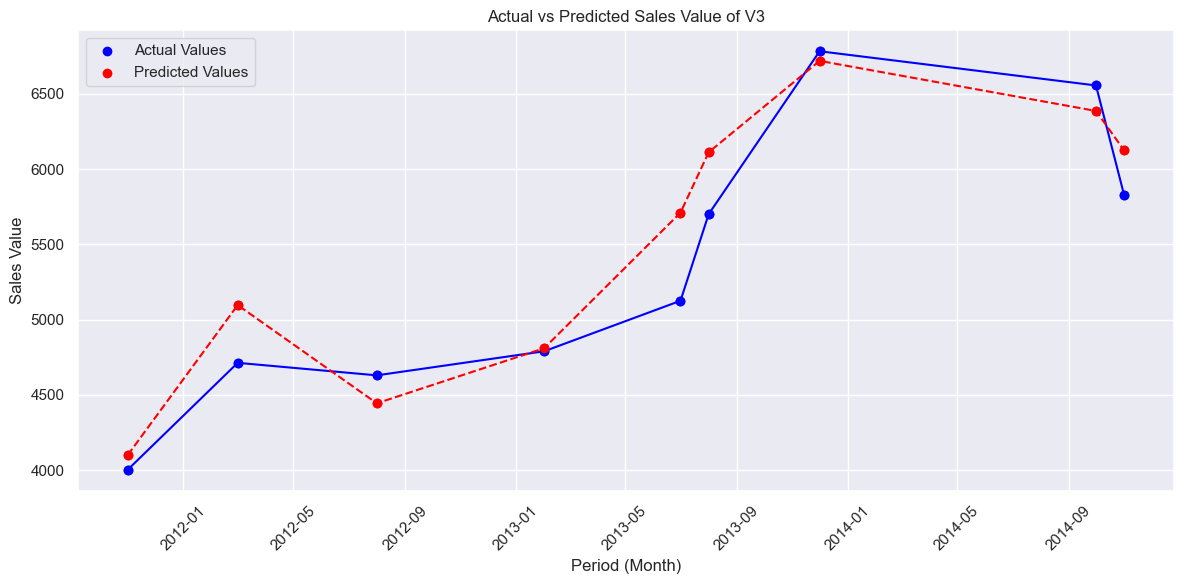

In [1387]:
# Create a DataFrame for test data with actual and predicted values
test_comparison_df = pd.DataFrame({
    'Period': final_data.loc[X_test_data.index, 'Period'],  # Extract periods corresponding to the test set
    'Actual': y_test_data,
    'Predicted': y_predictions
}).sort_values(by='Period')  # Ensure the Period column is sorted

# Create scatter and line plots for actual and predicted sales by Period
plt.figure(figsize=(12, 6))

# Scatter and line plot for actual values
plt.scatter(test_comparison_df['Period'], test_comparison_df['Actual'], label='Actual Values', color='blue')
plt.plot(test_comparison_df['Period'], test_comparison_df['Actual'], color='blue', linestyle='-', marker='o')

# Scatter and line plot for predicted values
plt.scatter(test_comparison_df['Period'], test_comparison_df['Predicted'], label='Predicted Values', color='red')
plt.plot(test_comparison_df['Period'], test_comparison_df['Predicted'], color='red', linestyle='--', marker='o')

# Customize the plot
plt.xlabel('Period (Month)')
plt.ylabel('Sales Value')
plt.title('Actual vs Predicted Sales Value of V3')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

# <b>Random Forest Model<b>

### Brand

In [1388]:
# Dependent
target_var = 'Brand_Sales_Value'

# Independent
feature_columns = [
    'Brand_Avg_Price_per_SU',
    'Brand_Shipment',
    'Brand_SocialAd_fbAd_Likes_Dgtl',
    'month_3',
    'month_7',
    'month_12'
]
X_data = final_data[feature_columns]
y_data = final_data[target_var]

# Split the data into training and testing sets
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Initialize Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train_data, y_train_data)

# Predict on the test set
y_pred = rf.predict(X_test_data)


# Compute evaluation metrics
mse_value = mean_squared_error(y_test_data, y_pred)
mape_value = mean_absolute_percentage_error(y_test_data, y_pred) * 100
r2_value = r2_score(y_test_data, y_pred)

# Adjusted R²
num_observations = len(y_test_data)  # Number of observations
num_features = X_test_data.shape[1]  # Number of predictors

# Avoid division by zero or invalid results
if num_observations > num_features + 1:
    adjusted_r2 = 1 - ((1 - r2_value) * (num_observations - 1) / (num_observations - num_features - 1))
else:
    adjusted_r2 = None  # Set to None or an appropriate placeholder if calculation is invalid

# Display the results
print("Random Forest Model Evaluation Metrics:")
print(f"Mean Absolute Percentage Error (MAPE): {mape_value:.2f}%")
print(f"R² Score: {r2_value:.3f}")
print(f"Adjusted R² Score: {adjusted_r2:.3f}")



Random Forest Model Evaluation Metrics:
Mean Absolute Percentage Error (MAPE): 3.91%
R² Score: 0.791
Adjusted R² Score: 0.164


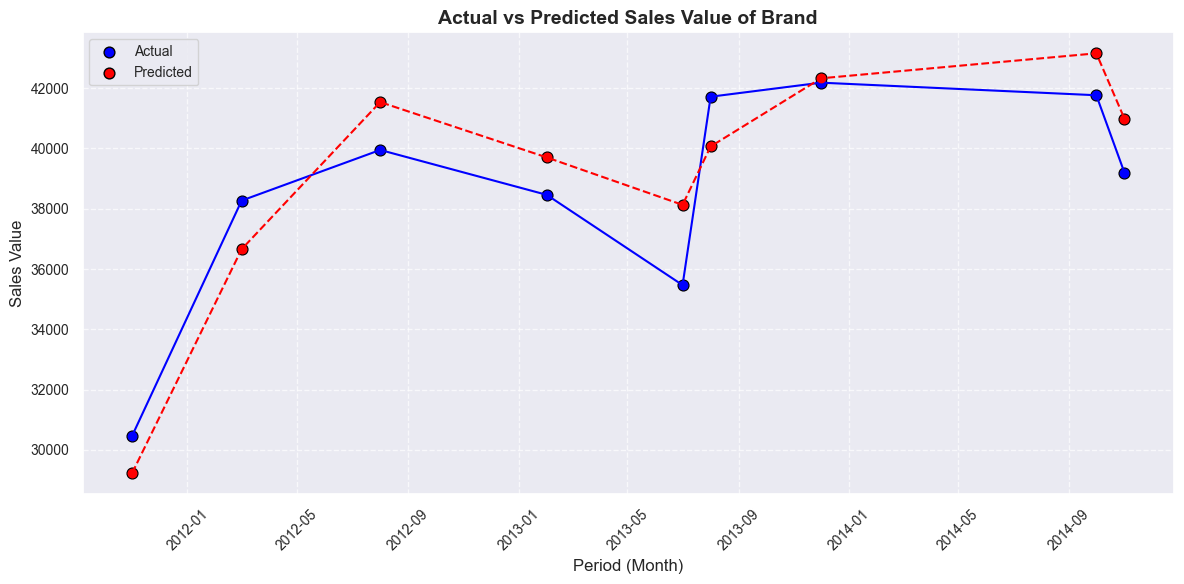

In [1389]:
# Create DataFrame for test data
test_comparison_df = pd.DataFrame({
    'Period': final_data.loc[X_test_data.index, 'Period'],  # Ensure 'Period' exists
    'Actual': y_test_data,
    'Predicted': y_pred  # Use consistent variable
}).sort_values(by='Period')

# Create scatter and line plots
plt.figure(figsize=(12, 6))
plt.scatter(test_comparison_df['Period'], test_comparison_df['Actual'], label='Actual', color='blue', s=60, edgecolor='black')
plt.plot(test_comparison_df['Period'], test_comparison_df['Actual'], color='blue', linestyle='-', marker='o')
plt.scatter(test_comparison_df['Period'], test_comparison_df['Predicted'], label='Predicted', color='red', s=60, edgecolor='black')
plt.plot(test_comparison_df['Period'], test_comparison_df['Predicted'], color='red', linestyle='--', marker='o')

# Customize and show the plot
plt.xlabel('Period (Month)', fontsize=12); plt.ylabel('Sales Value', fontsize=12)
plt.title('Actual vs Predicted Sales Value of Brand', fontsize=14, fontweight='bold')
plt.legend(fontsize=10); plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=10); plt.yticks(fontsize=10); plt.tight_layout()
plt.show()



### V1

In [1390]:
# Dependent
target_var = 'V1_Sales_Value'

# Independent
feature_columns = [
    'V1_IMedia_Total_Clks_Dgtl',
    'V1_IMedia_Total_Imp_Dgtl',
    'Adstock_V1_TV_Total_GRP_AOR',
    'month_7',
    'month_8',
    'month_11'
]
X_data = final_data[feature_columns]
y_data = final_data[target_var]

# Split the data into training and testing sets
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Initialize Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train_data, y_train_data)

# Predict on the test set
y_pred = rf.predict(X_test_data)

# Compute evaluation metrics
mse_value = mean_squared_error(y_test_data, y_pred)
mape_value = mean_absolute_percentage_error(y_test_data, y_pred) * 100
r2_value = r2_score(y_test_data, y_pred)

# Adjusted R²
num_observations = len(y_test_data)  # Number of observations
num_features = X_test_data.shape[1]  # Number of predictors

# Avoid division by zero or invalid results
if num_observations > num_features + 1:
    adjusted_r2 = 1 - ((1 - r2_value) * (num_observations - 1) / (num_observations - num_features - 1))
else:
    adjusted_r2 = None  # Set to None or an appropriate placeholder if calculation is invalid

# Display the results
print("Random Forest Model Evaluation Metrics:")
print(f"Mean Absolute Percentage Error (MAPE): {mape_value:.2f}%")
print(f"R² Score: {r2_value:.3f}")
print(f"Adjusted R² Score: {adjusted_r2:.3f}")

Random Forest Model Evaluation Metrics:
Mean Absolute Percentage Error (MAPE): 7.79%
R² Score: 0.410
Adjusted R² Score: -1.360


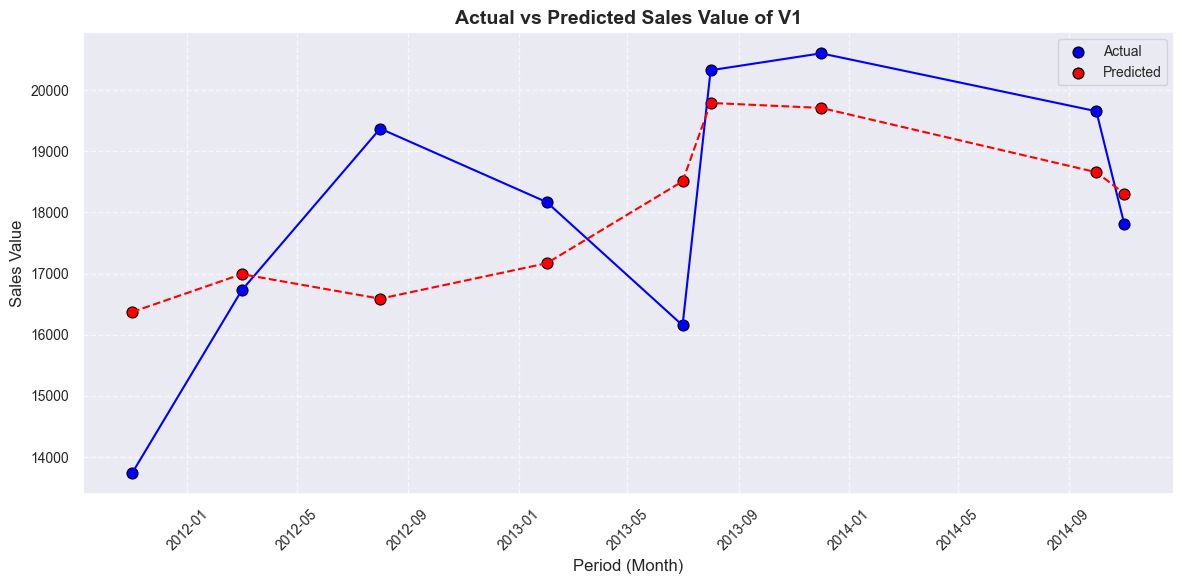

In [1391]:
# Create DataFrame for test data
test_comparison_df = pd.DataFrame({
    'Period': final_data.loc[X_test_data.index, 'Period'],  # Ensure 'Period' exists
    'Actual': y_test_data,
    'Predicted': y_pred  # Use consistent variable
}).sort_values(by='Period')

# Create scatter and line plots
plt.figure(figsize=(12, 6))
plt.scatter(test_comparison_df['Period'], test_comparison_df['Actual'], label='Actual', color='blue', s=60, edgecolor='black')
plt.plot(test_comparison_df['Period'], test_comparison_df['Actual'], color='blue', linestyle='-', marker='o')
plt.scatter(test_comparison_df['Period'], test_comparison_df['Predicted'], label='Predicted', color='red', s=60, edgecolor='black')
plt.plot(test_comparison_df['Period'], test_comparison_df['Predicted'], color='red', linestyle='--', marker='o')

# Customize and show the plot
plt.xlabel('Period (Month)', fontsize=12); plt.ylabel('Sales Value', fontsize=12)
plt.title('Actual vs Predicted Sales Value of V1', fontsize=14, fontweight='bold')
plt.legend(fontsize=10); plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=10); plt.yticks(fontsize=10); plt.tight_layout()
plt.show()


### V2 

In [1392]:
# Dependent
target_var = 'V2_Sales_Value'

# Independent
feature_columns = [
    'V2_Avg_Price_per_SU',
    'V1_TV_Total_ISP&TV_Spends_AOR',
    'V1_NUMD',
    'V1_IMedia_Total_Imp_Dgtl',
    'Adstock_V1_TV_Total_GRP_AOR',
    'month_1',
    'month_3',
    'month_7',
    'month_5',
    'month_9'    
]
X_data = final_data[feature_columns]
y_data = final_data[target_var]

# Split the data into training and testing sets
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Initialize Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train_data, y_train_data)

# Predict on the test set
y_pred = rf.predict(X_test_data)

# Compute evaluation metrics
mse_value = mean_squared_error(y_test_data, y_pred)
mape_value = mean_absolute_percentage_error(y_test_data, y_pred) * 100
r2_value = r2_score(y_test_data, y_pred)

# Adjusted R²
num_observations = len(y_test_data)  # Number of observations
num_features = X_test_data.shape[1]  # Number of predictors
adjusted_r2 = 1 - ((1 - r2_value) * (num_observations - 1) / (num_observations - num_features - 1))


# Display the results
print("Random Forest Model Evaluation Metrics:")
print(f"Mean Absolute Percentage Error (MAPE): {mape_value:.2f}%")
print(f"R² Score: {r2_value:.3f}")
print(f"Adjusted R² Score: {adjusted_r2:.3f}")

Random Forest Model Evaluation Metrics:
Mean Absolute Percentage Error (MAPE): 5.52%
R² Score: 0.260
Adjusted R² Score: 3.959


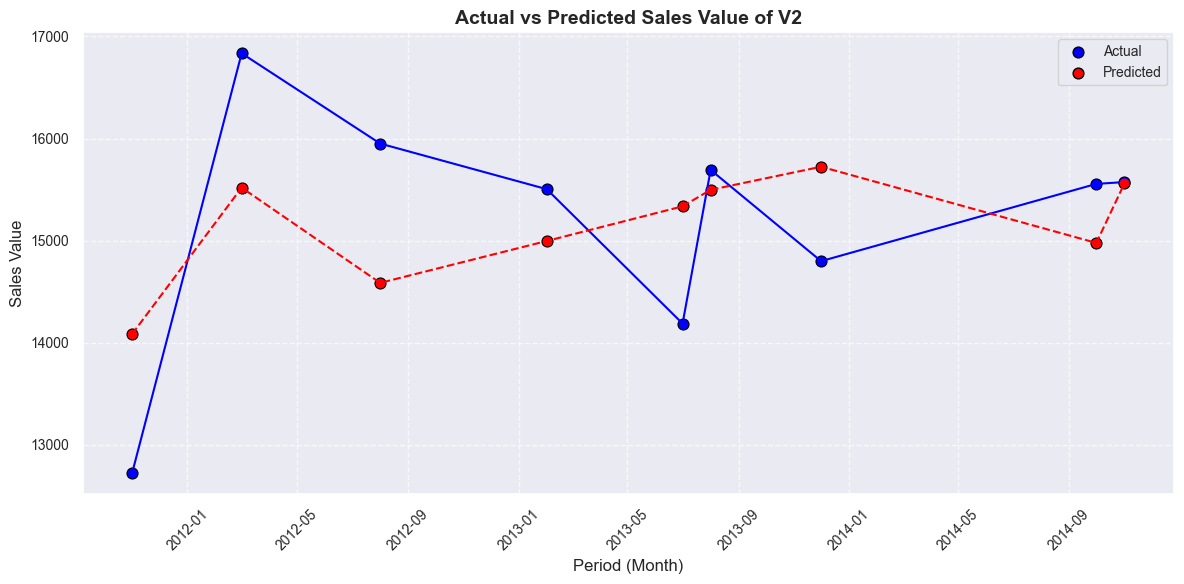

In [1393]:
# Create DataFrame for test data
test_comparison_df = pd.DataFrame({
    'Period': final_data.loc[X_test_data.index, 'Period'],  # Ensure 'Period' exists
    'Actual': y_test_data,
    'Predicted': y_pred  # Use consistent variable
}).sort_values(by='Period')

# Create scatter and line plots
plt.figure(figsize=(12, 6))
plt.scatter(test_comparison_df['Period'], test_comparison_df['Actual'], label='Actual', color='blue', s=60, edgecolor='black')
plt.plot(test_comparison_df['Period'], test_comparison_df['Actual'], color='blue', linestyle='-', marker='o')
plt.scatter(test_comparison_df['Period'], test_comparison_df['Predicted'], label='Predicted', color='red', s=60, edgecolor='black')
plt.plot(test_comparison_df['Period'], test_comparison_df['Predicted'], color='red', linestyle='--', marker='o')

# Customize and show the plot
plt.xlabel('Period (Month)', fontsize=12); plt.ylabel('Sales Value', fontsize=12)
plt.title('Actual vs Predicted Sales Value of V2', fontsize=14, fontweight='bold')
plt.legend(fontsize=10); plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=10); plt.yticks(fontsize=10); plt.tight_layout()
plt.show()


### V3

In [1394]:
# Dependent
target_var = 'V3_Sales_Value'

# Independent
feature_columns = [
    'V3_Shipment',
    'V3_Avg_Price_per_SU',
    'V1_TV_Total_ISP&TV_Spends_AOR',
    'V1_TV_ISP_Spends_AOR',
    'V1_IMedia_Total_Imp_Dgtl',
    'Adstock_V1_TV_Total_GRP_AOR',
    'V1_IMedia_Total_Spends_Dgtl',
    'month_1',
    'month_6',
    'month_8',
    'month_12',   
]
X_data = final_data[feature_columns]
y_data = final_data[target_var]

# Split the data into training and testing sets
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_data, y_data, test_size=0.2, random_state=42)


# Initialize Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train_data, y_train_data)

# Predict on the test set
y_pred = rf.predict(X_test_data)


# Compute evaluation metrics
mse_value = mean_squared_error(y_test_data, y_pred)
mape_value = mean_absolute_percentage_error(y_test_data, y_pred) * 100
r2_value = r2_score(y_test_data, y_pred)

# Adjusted R²
num_observations = len(y_test_data)  # Number of observations
num_features = X_test_data.shape[1]  # Number of predictors
adjusted_r2 = 1 - ((1 - r2_value) * (num_observations - 1) / (num_observations - num_features - 1))


# Display the results
print("Random Forest Model Evaluation Metrics:")
print(f"Mean Absolute Percentage Error (MAPE): {mape_value:.2f}%")
print(f"R² Score: {r2_value:.3f}")
print(f"Adjusted R² Score: {adjusted_r2:.3f}")

Random Forest Model Evaluation Metrics:
Mean Absolute Percentage Error (MAPE): 6.94%
R² Score: 0.787
Adjusted R² Score: 1.567


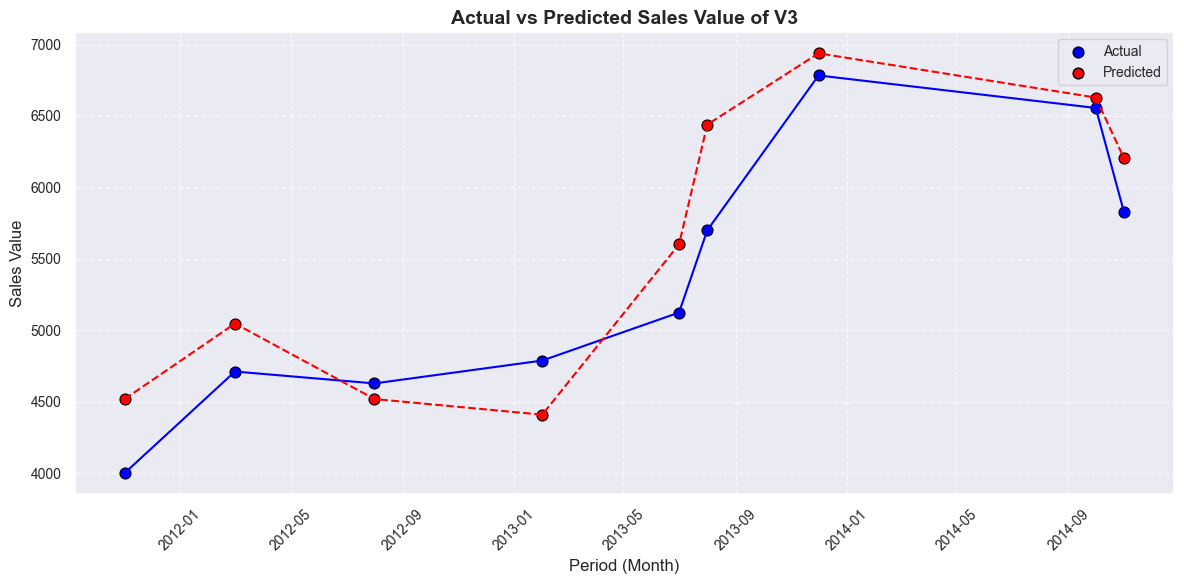

In [1395]:
# Create DataFrame for test data
test_comparison_df = pd.DataFrame({
    'Period': final_data.loc[X_test_data.index, 'Period'],  # Ensure 'Period' exists
    'Actual': y_test_data,
    'Predicted': y_pred  # Use consistent variable
}).sort_values(by='Period')

# Create scatter and line plots
plt.figure(figsize=(12, 6))
plt.scatter(test_comparison_df['Period'], test_comparison_df['Actual'], label='Actual', color='blue', s=60, edgecolor='black')
plt.plot(test_comparison_df['Period'], test_comparison_df['Actual'], color='blue', linestyle='-', marker='o')
plt.scatter(test_comparison_df['Period'], test_comparison_df['Predicted'], label='Predicted', color='red', s=60, edgecolor='black')
plt.plot(test_comparison_df['Period'], test_comparison_df['Predicted'], color='red', linestyle='--', marker='o')

# Customize and show the plot
plt.xlabel('Period (Month)', fontsize=12); plt.ylabel('Sales Value', fontsize=12)
plt.title('Actual vs Predicted Sales Value of V3', fontsize=14, fontweight='bold')
plt.legend(fontsize=10); plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=10); plt.yticks(fontsize=10); plt.tight_layout()
plt.show()


# <b>XGBoost<b>

### Brand

In [1396]:
# Dependent
target_var = 'Brand_Sales_Value'

# Independent
feature_columns = [
    'Brand_Avg_Price_per_SU',
    'Brand_Shipment',
    'Brand_SocialAd_fbAd_Likes_Dgtl',
    'month_3',
    'month_7',
    'month_12'
]
X_data = final_data[feature_columns]
y_data = final_data[target_var]

# Split the data into training and testing sets
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Initialize XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Fit the model on the training data
xgb_model.fit(X_train_data, y_train_data)

# Predict on the test set
y_predictions = xgb_model.predict(X_test_data)

# Compute evaluation metrics
mse_value = mean_squared_error(y_test_data, y_predictions)
mape_value = mean_absolute_percentage_error(y_test_data, y_predictions) * 100
r2_value = r2_score(y_test_data, y_predictions)

# Adjusted R²
num_observations = len(y_test_data)  # Number of observations
num_features = X_test_data.shape[1]  # Number of predictors
adjusted_r2 = 1 - ((1 - r2_value) * (num_observations - 1) / (num_observations - num_features - 1))


# Display the results
print("XGBoost Model Evaluation Metrics:")
print(f"Mean Absolute Percentage Error (MAPE): {mape_value:.2f}%")
print(f"R² Score: {r2_value:.3f}")
print(f"Adjusted R² Score: {adjusted_r2:.3f}")

XGBoost Model Evaluation Metrics:
Mean Absolute Percentage Error (MAPE): 5.59%
R² Score: 0.553
Adjusted R² Score: -0.790


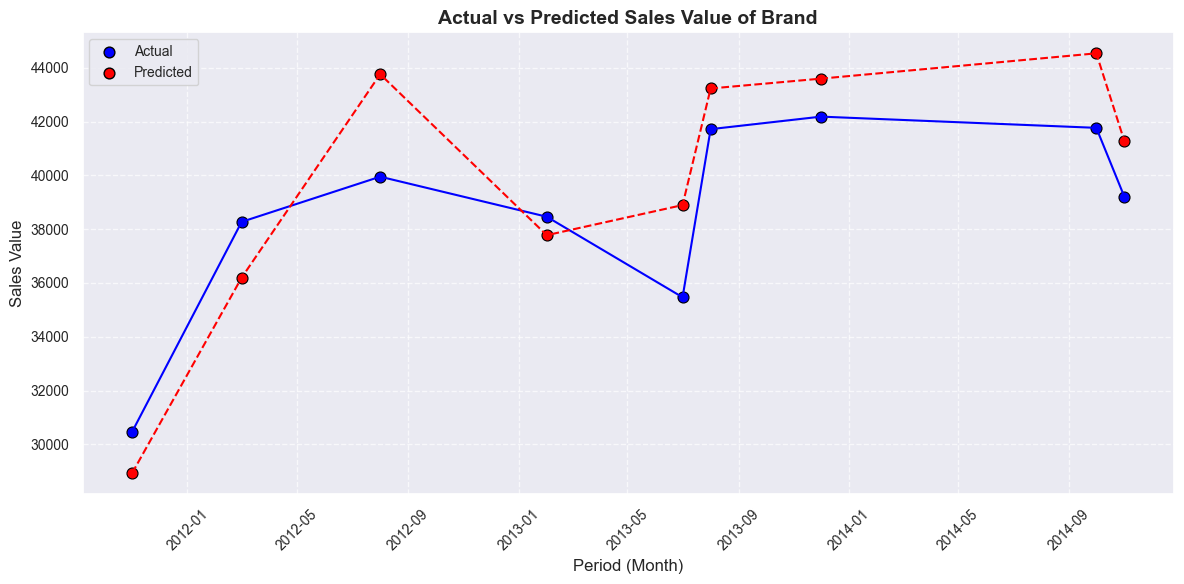

In [1397]:
# Create DataFrame for test data
test_comparison_df = pd.DataFrame({
    'Period': final_data.loc[X_test_data.index, 'Period'],  # Ensure 'Period' exists
    'Actual': y_test_data,
    'Predicted': y_predictions  # Use consistent variable
}).sort_values(by='Period')

# Create scatter and line plots
plt.figure(figsize=(12, 6))
plt.scatter(test_comparison_df['Period'], test_comparison_df['Actual'], label='Actual', color='blue', s=60, edgecolor='black')
plt.plot(test_comparison_df['Period'], test_comparison_df['Actual'], color='blue', linestyle='-', marker='o')
plt.scatter(test_comparison_df['Period'], test_comparison_df['Predicted'], label='Predicted', color='red', s=60, edgecolor='black')
plt.plot(test_comparison_df['Period'], test_comparison_df['Predicted'], color='red', linestyle='--', marker='o')

# Customize and show the plot
plt.xlabel('Period (Month)', fontsize=12); plt.ylabel('Sales Value', fontsize=12)
plt.title('Actual vs Predicted Sales Value of Brand', fontsize=14, fontweight='bold')
plt.legend(fontsize=10); plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=10); plt.yticks(fontsize=10); plt.tight_layout()
plt.show()


### V1

In [1398]:
# Dependent
target_var = 'V1_Sales_Value'

# Independent
feature_columns = [
    'V1_IMedia_Total_Clks_Dgtl',
    'V1_IMedia_Total_Imp_Dgtl',
    'Adstock_V1_TV_Total_GRP_AOR',
    'month_7',
    'month_8',
    'month_11'
]
X_data = final_data[feature_columns]
y_data = final_data[target_var]

# Split the data into training and testing sets
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Initialize XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Fit the model on the training data
xgb_model.fit(X_train_data, y_train_data)

# Predict on the test set
y_predictions = xgb_model.predict(X_test_data)

# Compute evaluation metrics
mse_value = mean_squared_error(y_test_data, y_predictions)
mape_value = mean_absolute_percentage_error(y_test_data, y_predictions) * 100
r2_value = r2_score(y_test_data, y_predictions)

# Adjusted R²
num_observations = len(y_test_data)  # Number of observations
num_features = X_test_data.shape[1]  # Number of predictors
adjusted_r2 = 1 - ((1 - r2_value) * (num_observations - 1) / (num_observations - num_features - 1))


# Display the results
print("XGBoost Model Evaluation Metrics:")
print(f"Mean Absolute Percentage Error (MAPE): {mape_value:.2f}%")
print(f"R² Score: {r2_value:.3f}")
print(f"Adjusted R² Score: {adjusted_r2:.3f}")

XGBoost Model Evaluation Metrics:
Mean Absolute Percentage Error (MAPE): 6.27%
R² Score: 0.605
Adjusted R² Score: -0.578


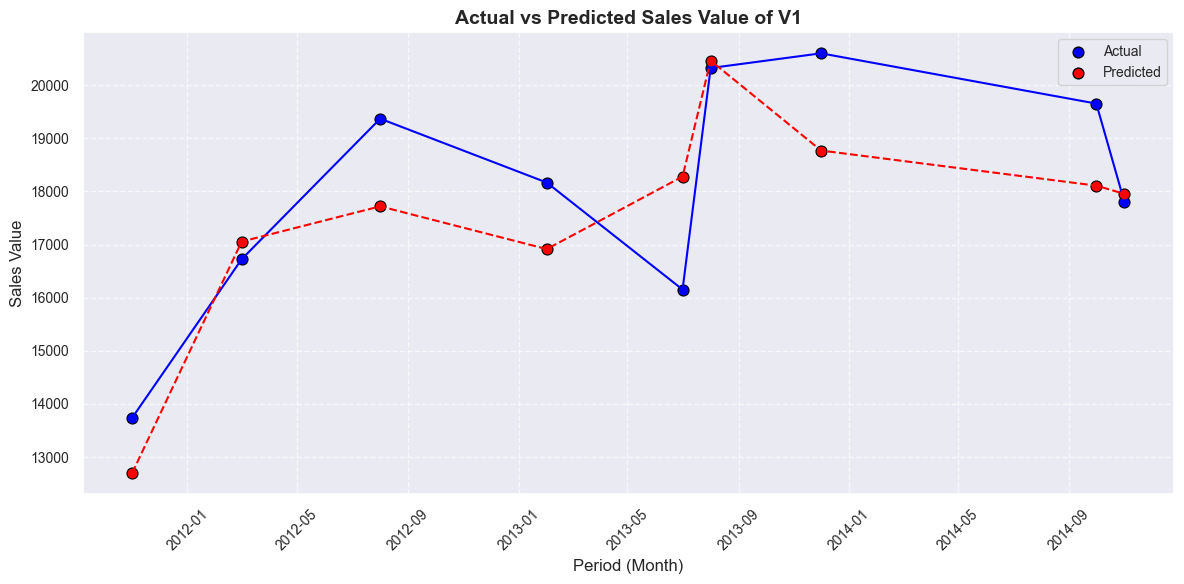

In [1399]:
# Create DataFrame for test data
test_comparison_df = pd.DataFrame({
    'Period': final_data.loc[X_test_data.index, 'Period'],  # Ensure 'Period' exists
    'Actual': y_test_data,
    'Predicted': y_predictions  # Use consistent variable
}).sort_values(by='Period')

# Create scatter and line plots
plt.figure(figsize=(12, 6))
plt.scatter(test_comparison_df['Period'], test_comparison_df['Actual'], label='Actual', color='blue', s=60, edgecolor='black')
plt.plot(test_comparison_df['Period'], test_comparison_df['Actual'], color='blue', linestyle='-', marker='o')
plt.scatter(test_comparison_df['Period'], test_comparison_df['Predicted'], label='Predicted', color='red', s=60, edgecolor='black')
plt.plot(test_comparison_df['Period'], test_comparison_df['Predicted'], color='red', linestyle='--', marker='o')

# Customize and show the plot
plt.xlabel('Period (Month)', fontsize=12); plt.ylabel('Sales Value', fontsize=12)
plt.title('Actual vs Predicted Sales Value of V1', fontsize=14, fontweight='bold')
plt.legend(fontsize=10); plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=10); plt.yticks(fontsize=10); plt.tight_layout()
plt.show()


### V2

In [1400]:
# Dependent
target_var = 'V2_Sales_Value'

# Independent
feature_columns = [
    'V2_Avg_Price_per_SU',
    'V1_TV_Total_ISP&TV_Spends_AOR',
    'V1_NUMD',
    'V1_IMedia_Total_Imp_Dgtl',
    'Adstock_V1_TV_Total_GRP_AOR',
    'month_1',
    'month_3',
    'month_7',
    'month_5',
    'month_9'    
]
X_data = final_data[feature_columns]
y_data = final_data[target_var]

# Split the data into training and testing sets
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Initialize XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Fit the model on the training data
xgb_model.fit(X_train_data, y_train_data)

# Predict on the test set
y_predictions = xgb_model.predict(X_test_data)

# Compute evaluation metrics
mse_value = mean_squared_error(y_test_data, y_predictions)
mape_value = mean_absolute_percentage_error(y_test_data, y_predictions) * 100
r2_value = r2_score(y_test_data, y_predictions)

# Adjusted R²
num_observations = len(y_test_data)  # Number of observations
num_features = X_test_data.shape[1]  # Number of predictors
adjusted_r2 = 1 - ((1 - r2_value) * (num_observations - 1) / (num_observations - num_features - 1))


# Display the results
print("XGBoost Model Evaluation Metrics:")
print(f"Mean Absolute Percentage Error (MAPE): {mape_value:.2f}%")
print(f"R² Score: {r2_value:.3f}")
print(f"Adjusted R² Score: {adjusted_r2:.3f}")

XGBoost Model Evaluation Metrics:
Mean Absolute Percentage Error (MAPE): 5.66%
R² Score: 0.219
Adjusted R² Score: 4.124


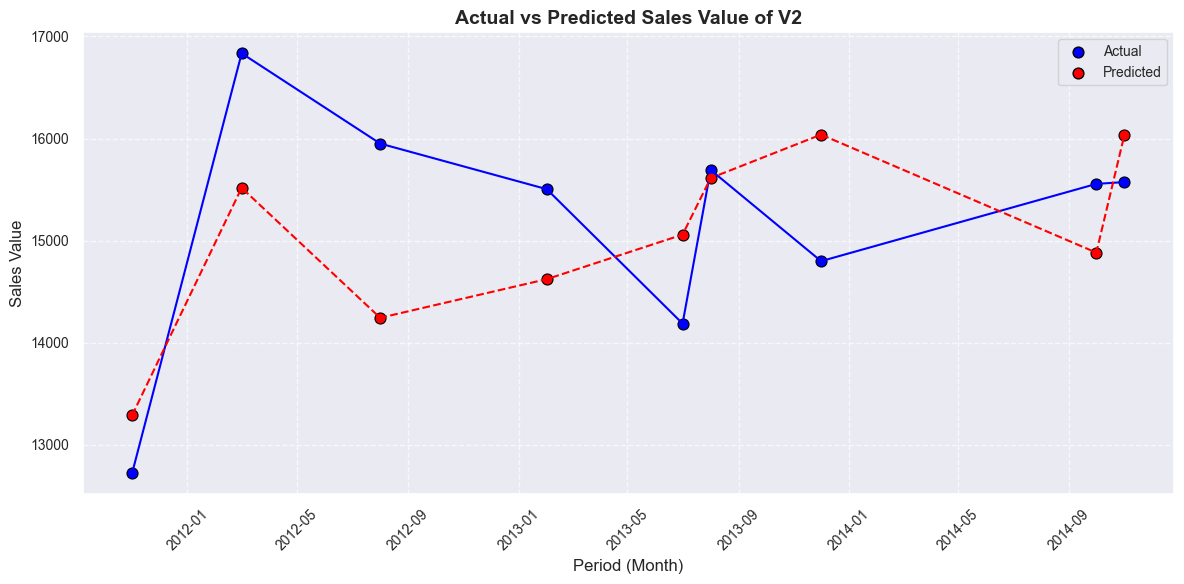

In [1401]:
# Create DataFrame for test data
test_comparison_df = pd.DataFrame({
    'Period': final_data.loc[X_test_data.index, 'Period'],  # Ensure 'Period' exists
    'Actual': y_test_data,
    'Predicted': y_predictions  # Use consistent variable
}).sort_values(by='Period')

# Create scatter and line plots
plt.figure(figsize=(12, 6))
plt.scatter(test_comparison_df['Period'], test_comparison_df['Actual'], label='Actual', color='blue', s=60, edgecolor='black')
plt.plot(test_comparison_df['Period'], test_comparison_df['Actual'], color='blue', linestyle='-', marker='o')
plt.scatter(test_comparison_df['Period'], test_comparison_df['Predicted'], label='Predicted', color='red', s=60, edgecolor='black')
plt.plot(test_comparison_df['Period'], test_comparison_df['Predicted'], color='red', linestyle='--', marker='o')

# Customize and show the plot
plt.xlabel('Period (Month)', fontsize=12); plt.ylabel('Sales Value', fontsize=12)
plt.title('Actual vs Predicted Sales Value of V2', fontsize=14, fontweight='bold')
plt.legend(fontsize=10); plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=10); plt.yticks(fontsize=10); plt.tight_layout()
plt.show()


### V3

In [1402]:
# Dependent
target_var = 'V3_Sales_Value'

# Independent
feature_columns = [
    'V3_Shipment',
    'V3_Avg_Price_per_SU',
    'V1_TV_Total_ISP&TV_Spends_AOR',
    'V1_TV_ISP_Spends_AOR',
    'V1_IMedia_Total_Imp_Dgtl',
    'Adstock_V1_TV_Total_GRP_AOR',
    'V1_IMedia_Total_Spends_Dgtl',
    'month_1',
    'month_6',
    'month_8',
    'month_12',   
]
X_data = final_data[feature_columns]
y_data = final_data[target_var]

# Split the data into training and testing sets
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Initialize XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Fit the model on the training data
xgb_model.fit(X_train_data, y_train_data)

# Predict on the test set
y_predictions = xgb_model.predict(X_test_data)

# Compute evaluation metrics
mse_value = mean_squared_error(y_test_data, y_predictions)
mape_value = mean_absolute_percentage_error(y_test_data, y_predictions) * 100
r2_value = r2_score(y_test_data, y_predictions)

# Adjusted R²
num_observations = len(y_test_data)  # Number of observations
num_features = X_test_data.shape[1]  # Number of predictors
adjusted_r2 = 1 - ((1 - r2_value) * (num_observations - 1) / (num_observations - num_features - 1))


# Display the results
print("XGBoost Model Evaluation Metrics:")
print(f"Mean Absolute Percentage Error (MAPE): {mape_value:.2f}%")
print(f"R² Score: {r2_value:.3f}")
print(f"Adjusted R² Score: {adjusted_r2:.3f}")

XGBoost Model Evaluation Metrics:
Mean Absolute Percentage Error (MAPE): 7.02%
R² Score: 0.712
Adjusted R² Score: 1.768


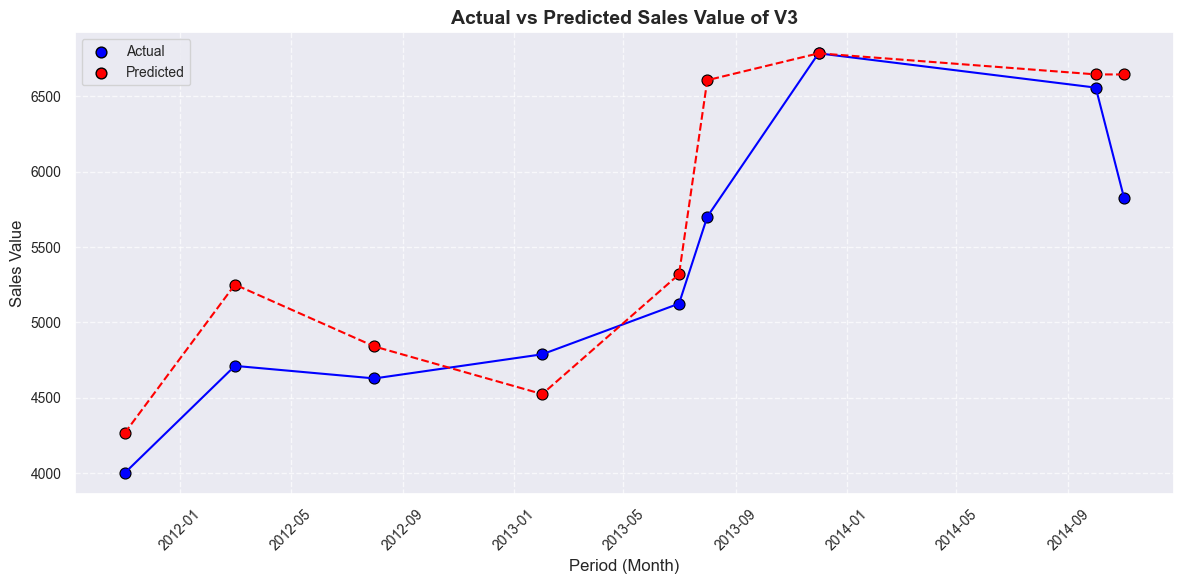

In [1403]:
# Create DataFrame for test data
test_comparison_df = pd.DataFrame({
    'Period': final_data.loc[X_test_data.index, 'Period'],  # Ensure 'Period' exists
    'Actual': y_test_data,
    'Predicted': y_predictions  # Use consistent variable
}).sort_values(by='Period')

# Create scatter and line plots
plt.figure(figsize=(12, 6))
plt.scatter(test_comparison_df['Period'], test_comparison_df['Actual'], label='Actual', color='blue', s=60, edgecolor='black')
plt.plot(test_comparison_df['Period'], test_comparison_df['Actual'], color='blue', linestyle='-', marker='o')
plt.scatter(test_comparison_df['Period'], test_comparison_df['Predicted'], label='Predicted', color='red', s=60, edgecolor='black')
plt.plot(test_comparison_df['Period'], test_comparison_df['Predicted'], color='red', linestyle='--', marker='o')

# Customize and show the plot
plt.xlabel('Period (Month)', fontsize=12); plt.ylabel('Sales Value', fontsize=12)
plt.title('Actual vs Predicted Sales Value of V3', fontsize=14, fontweight='bold')
plt.legend(fontsize=10); plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=10); plt.yticks(fontsize=10); plt.tight_layout()
plt.show()


# <b> Comparision of Models<b>

In [1404]:
# Function to calculate adjusted R²
def adjusted_r2_score(r2, n, p):
    """Calculates the adjusted R² score."""
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# Function to train and evaluate a model
def train_model(model, X_train, y_train):
    """Trains the model with the given training data."""
    model.fit(X_train, y_train)
    return model

def predict_and_evaluate(model, X_test, y_test):
    """Predicts the target and computes evaluation metrics."""
    y_pred = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    r2 = r2_score(y_test, y_pred)
    n = len(y_test)  # Number of observations
    p = X_test.shape[1]  # Number of predictors (features)
    adjusted_r2 = adjusted_r2_score(r2, n, p)
    return mape, r2, adjusted_r2

def initialize_models(alpha=1.0, random_state=42):
    """Initializes and returns the dictionary of models."""
    return {
        "Linear Regression": LinearRegression(),
        "Lasso Regression": Lasso(alpha=alpha),
        "Ridge Regression": Ridge(alpha=alpha),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=random_state),
        "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=random_state)
    }

def get_data(target, features):
    """Prepares the data for training and testing."""
    X = final_data[features]
    y = final_data[target]
    return train_test_split(X, y, test_size=0.2, random_state=42)

def evaluate_models(models, X_train, X_test, y_train, y_test):
    """Evaluates each model and returns the results in a DataFrame."""
    results = []
    for model_name, model in models.items():
        model = train_model(model, X_train, y_train)
        mape, r2, adjusted_r2 = predict_and_evaluate(model, X_test, y_test)
        results.append({
            "Model": model_name,
            "MAPE (%)": mape,
            "R²": r2,
            "Adjusted R²": adjusted_r2
        })
    return pd.DataFrame(results)

def compare_models(target, features, alpha=1.0, random_state=42):
    """Prepares data, runs models, and compares their performance."""
    X_train, X_test, y_train, y_test = get_data(target, features)
    models = initialize_models(alpha, random_state)
    return evaluate_models(models, X_train, X_test, y_train, y_test)


# Define targets and features for all models
model_configurations = {
    'Brand Sales Value': {
        'target': 'Brand_Sales_Value',
        'features': [
            'Brand_Avg_Price_per_SU', 'Brand_Shipment', 'Brand_SocialAd_fbAd_Likes_Dgtl',
            'month_3', 'month_7', 'month_12'
        ]
    },
    'V1 Sales Value': {
        'target': 'V1_Sales_Value',
        'features': [
            'V1_IMedia_Total_Clks_Dgtl', 'V1_IMedia_Total_Imp_Dgtl', 'Adstock_V1_TV_Total_GRP_AOR',
            'month_7', 'month_8', 'month_11'
        ]
    },
    'V2 Sales Value': {
        'target': 'V2_Sales_Value',
        'features': [
            'V2_Avg_Price_per_SU', 'V1_TV_Total_ISP&TV_Spends_AOR', 'V1_NUMD', 
            'V1_IMedia_Total_Imp_Dgtl', 'Adstock_V1_TV_Total_GRP_AOR', 'month_1', 'month_3', 'month_7', 'month_5', 'month_9'
        ]
    },
    'V3 Sales Value': {
        'target': 'V3_Sales_Value',
        'features': [
            'V3_Shipment', 'V3_Avg_Price_per_SU', 'V1_TV_Total_ISP&TV_Spends_AOR',
            'V1_TV_ISP_Spends_AOR', 'V1_IMedia_Total_Imp_Dgtl', 'Adstock_V1_TV_Total_GRP_AOR',
            'V1_IMedia_Total_Spends_Dgtl', 'month_1', 'month_6', 'month_8', 'month_12'
        ]
    }
}

# Run the comparisons for each model
for model_name, config in model_configurations.items():
    print(f"Comparison for Model: {model_name}")
    results = compare_models(config['target'], config['features'])
    print(results)
    print("\n" + "-"*50 + "\n")


Comparison for Model: Brand Sales Value
               Model  MAPE (%)        R²  Adjusted R²
0  Linear Regression  3.051212  0.828365     0.313459
1   Lasso Regression  3.042153  0.827994     0.311977
2   Ridge Regression  3.143589  0.779473     0.117892
3      Random Forest  3.909419  0.791118     0.164474
4            XGBoost  5.592123  0.552558    -0.789768

--------------------------------------------------

Comparison for Model: V1 Sales Value
               Model  MAPE (%)        R²  Adjusted R²
0  Linear Regression  3.485458  0.848762     0.395049
1   Lasso Regression  3.443992  0.849036     0.396142
2   Ridge Regression  3.867771  0.832661     0.330644
3      Random Forest  7.785423  0.409983    -1.360067
4            XGBoost  6.270027  0.605481    -0.578078

--------------------------------------------------

Comparison for Model: V2 Sales Value
               Model  MAPE (%)        R²  Adjusted R²
0  Linear Regression  2.426585  0.787219     1.851125
1   Lasso Regression  2.

C:\Users\vaish\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.308e+06, tolerance: 4.061e+03
  model = cd_fast.enet_coordinate_descent(


               Model  MAPE (%)        R²  Adjusted R²
0  Linear Regression  4.594647  0.896392     1.276288
1   Lasso Regression  4.632568  0.889858     1.293712
2   Ridge Regression  4.698665  0.881582     1.315781
3      Random Forest  6.940043  0.787387     1.566968
4            XGBoost  7.015070  0.712116     1.767691

--------------------------------------------------



# Best Model Report

## Overview

The objective of this analysis was to evaluate and compare the performance of multiple regression models on predicting sales values across four different targets:

- **Brand Sales Value**
- **V1 Sales Value**
- **V2 Sales Value**
- **V3 Sales Value**

The models evaluated include:
- **Linear Regression**
- **Lasso Regression**
- **Ridge Regression**
- **Random Forest**
- **XGBoost**

For each model, we assessed the performance using three metrics:
- **Mean Absolute Percentage Error (MAPE)**: Lower values indicate better accuracy.
- **R² (R-Squared)**: Higher values indicate a better fit of the model to the data.
- **Adjusted R²**: Accounts for the number of predictors in the model, offering a more accurate measure of fit.

## Evaluation Results

### 1. **Brand Sales Value**

| Model               | MAPE (%)  | R²       | Adjusted R² |
|---------------------|-----------|----------|-------------|
| Linear Regression   | 3.05      | 0.828    | 0.313       |
| Lasso Regression    | 3.04      | 0.828    | 0.312       |
| Ridge Regression    | 3.14      | 0.779    | 0.118       |
| Random Forest       | 3.91      | 0.791    | 0.164       |
| XGBoost             | 5.59      | 0.553    | -0.790      |

**Best Model**: **Linear Regression** and **Lasso Regression** both had the lowest MAPE of 3.05% and 3.04%, respectively, and high R² scores of 0.828. **Linear Regression** also had a better Adjusted R² (0.313).

---

### 2. **V1 Sales Value**

| Model               | MAPE (%)  | R²       | Adjusted R² |
|---------------------|-----------|----------|-------------|
| Linear Regression   | 3.49      | 0.849    | 0.395       |
| Lasso Regression    | 3.44      | 0.849    | 0.396       |
| Ridge Regression    | 3.87      | 0.833    | 0.331       |
| Random Forest       | 7.79      | 0.410    | -1.360      |
| XGBoost             | 6.27      | 0.605    | -0.578      |

**Best Model**: **Linear Regression** and **Lasso Regression** both had the lowest MAPE (3.44% and 3.49%) and top R² of 0.849. **Lasso Regression** slightly outperformed Linear Regression in Adjusted R² with a score of 0.396.

---

### 3. **V2 Sales Value**

| Model               | MAPE (%)  | R²       | Adjusted R² |
|---------------------|-----------|----------|-------------|
| Linear Regression   | 2.43      | 0.787    | 1.85        |
| Lasso Regression    | 2.44      | 0.781    | 1.88        |
| Ridge Regression    | 3.40      | 0.616    | 2.54        |
| Random Forest       | 5.52      | 0.260    | 3.96        |
| XGBoost             | 5.66      | 0.219    | 4.12        |

**Best Model**: **Linear Regression** performed best with a MAPE of 2.43% and R² of 0.787. The Adjusted R² of 1.85 also supports its strong performance.

---

### 4. **V3 Sales Value**

| Model               | MAPE (%)  | R²       | Adjusted R² |
|---------------------|-----------|----------|-------------|
| Linear Regression   | 4.59      | 0.896    | 1.28        |
| Lasso Regression    | 4.63      | 0.890    | 1.29        |
| Ridge Regression    | 4.70      | 0.882    | 1.32        |
| Random Forest       | 6.94      | 0.787    | 1.57        |
| XGBoost             | 7.02      | 0.712    | 1.77        |

**Best Model**: **Linear Regression** was the top performer with a MAPE of 4.59% and an R² of 0.896, as well as an Adjusted R² of 1.28.

---

## Conclusion

Based on the evaluation metrics across all four target variables, the following conclusions can be drawn:

- **Linear Regression** and **Lasso Regression** consistently performed well across multiple models, with **Linear Regression** often emerging as the best performer.
- **Linear Regression** is the preferred model for **Brand Sales Value**, **V1 Sales Value**, and **V2 Sales Value** due to its low MAPE, high R², and competitive Adjusted R² scores.
- **Lasso Regression** performed comparably to **Linear Regression**, particularly in **V1 Sales Value** and **V3 Sales Value**, with slightly higher Adjusted R² in some cases.
- **Random Forest** and **XGBoost** generally did not perform as well, especially for **V1 Sales Value**, **V2 Sales Value**, and **Brand Sales Value**, showing lower R² and negative Adjusted R² values.


# <b>Actual vs Predicted Sales Value of Best Model

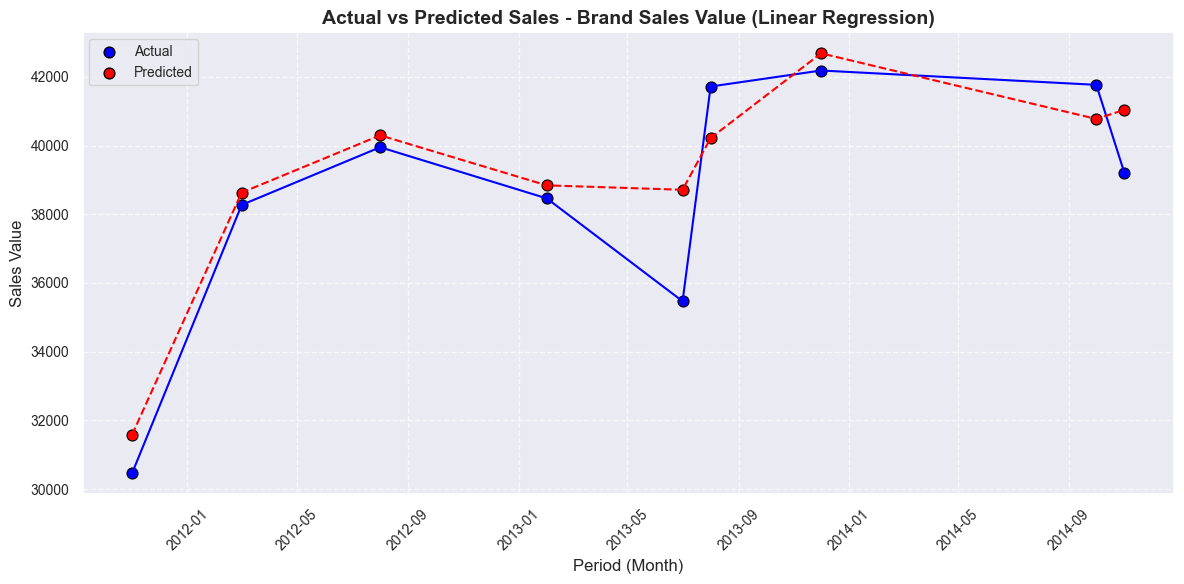

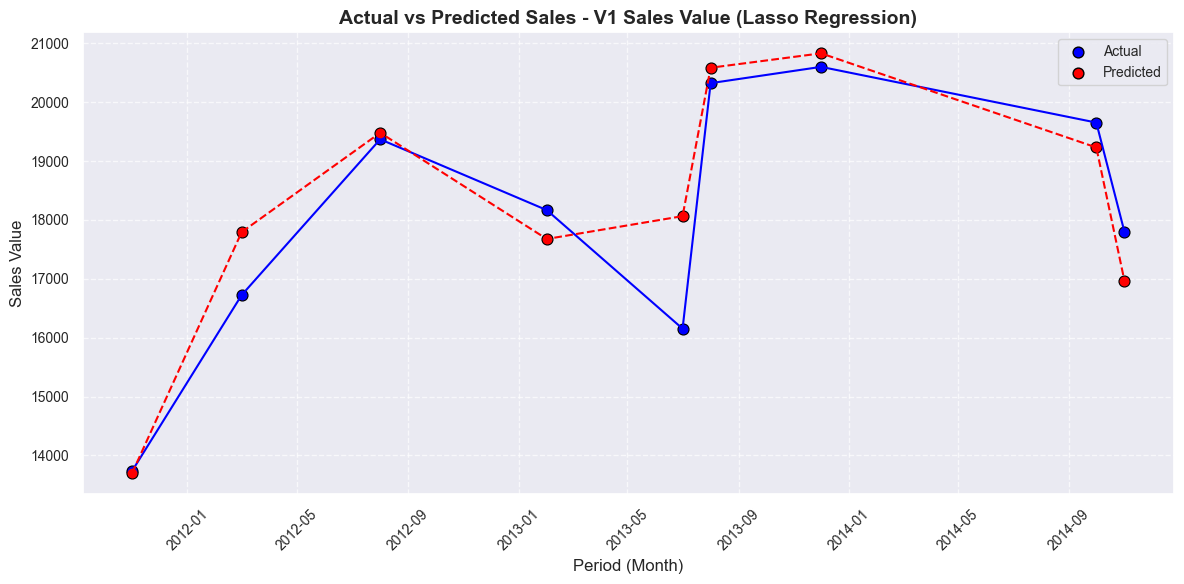

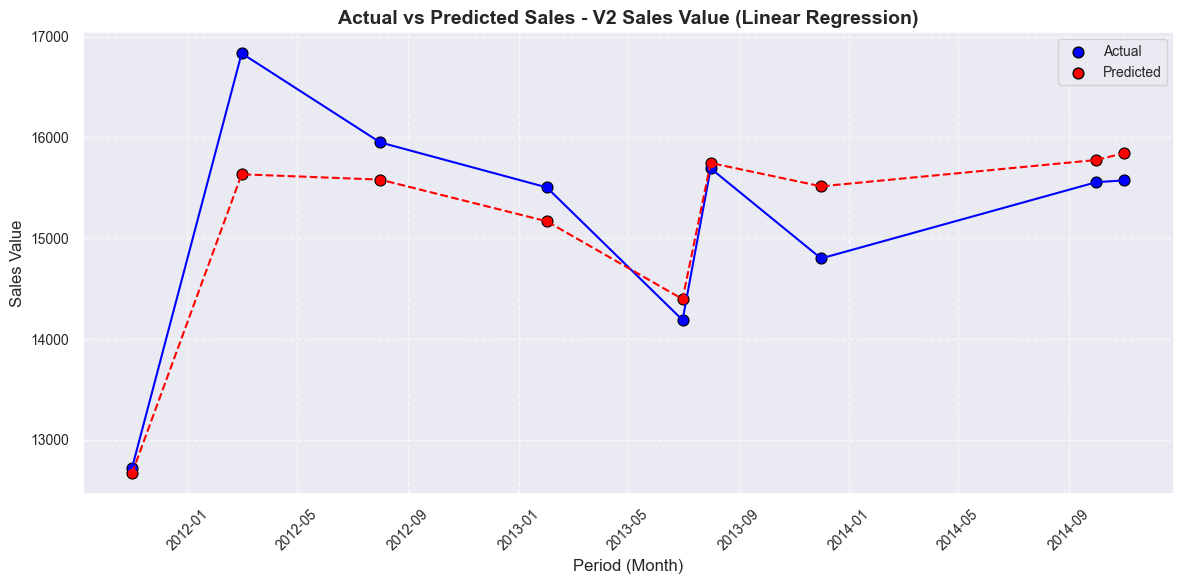

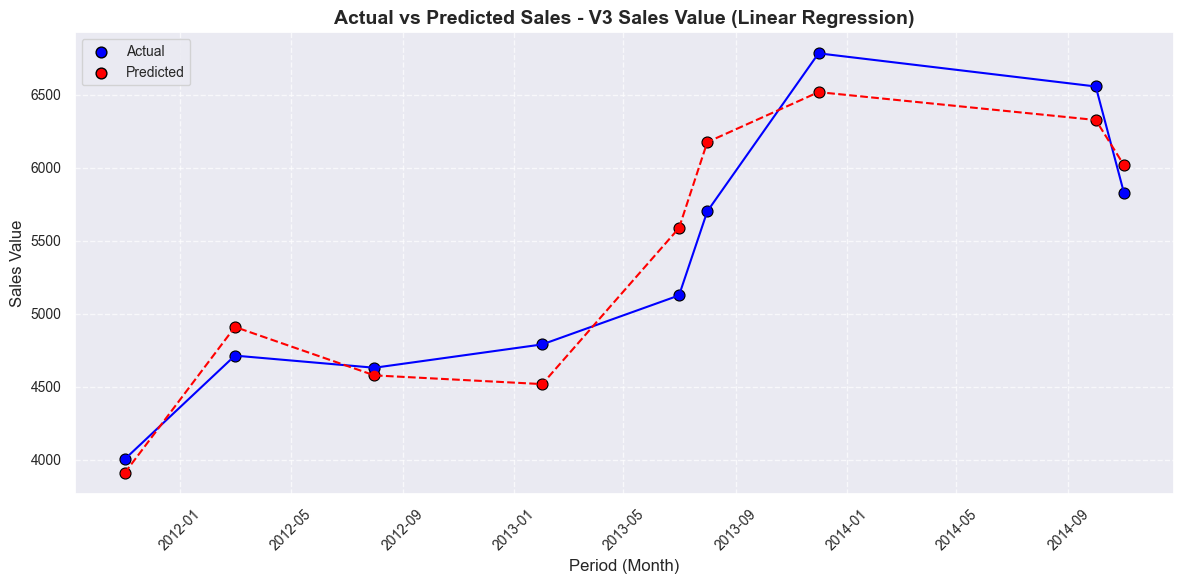

In [1405]:
# Function to plot Actual vs Predicted Sales with model name as title
def plot_actual_vs_predicted_with_style(model, features, target_name, plot_title, model_name):
    # Train the model
    X = final_data[features]
    y = final_data[target_name]
    
    # Split data into training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit model and generate predictions
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Create DataFrame for test data comparison
    test_comparison_df = pd.DataFrame({
        'Period': final_data.loc[X_test.index, 'Period'],  # Ensure 'Period' exists
        'Actual': y_test,
        'Predicted': y_pred  # Use consistent variable
    }).sort_values(by='Period')
    
    # Create scatter and line plots
    plt.figure(figsize=(12, 6))
    
    # Plot Actual Sales
    plt.scatter(test_comparison_df['Period'], test_comparison_df['Actual'], label='Actual', color='blue', s=60, edgecolor='black')
    plt.plot(test_comparison_df['Period'], test_comparison_df['Actual'], color='blue', linestyle='-', marker='o')

    # Plot Predicted Sales
    plt.scatter(test_comparison_df['Period'], test_comparison_df['Predicted'], label='Predicted', color='red', s=60, edgecolor='black')
    plt.plot(test_comparison_df['Period'], test_comparison_df['Predicted'], color='red', linestyle='--', marker='o')
    
    # Customize and show the plot
    plt.xlabel('Period (Month)', fontsize=12)
    plt.ylabel('Sales Value', fontsize=12)
    plt.title(f'Actual vs Predicted Sales - {plot_title} ({model_name})', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

# Generate Actual vs Predicted for all models with model name in title
def plot_all_actual_vs_predicted_with_style():
    models = {
        "Brand_Sales_Value": (LinearRegression(), "Brand Sales Value", "Linear Regression"),
        "V1_Sales_Value": (Lasso(alpha=1.0), "V1 Sales Value", "Lasso Regression"),
        "V2_Sales_Value": (LinearRegression(), "V2 Sales Value", "Linear Regression"),
        "V3_Sales_Value": (LinearRegression(), "V3 Sales Value", "Linear Regression")
    }
    
    features = {
        "Brand_Sales_Value": [
            'Brand_Avg_Price_per_SU', 'Brand_Shipment', 'Brand_SocialAd_fbAd_Likes_Dgtl',
            'month_3', 'month_7', 'month_12'
        ],
        "V1_Sales_Value": [
            'V1_IMedia_Total_Clks_Dgtl', 'V1_IMedia_Total_Imp_Dgtl', 'Adstock_V1_TV_Total_GRP_AOR',
            'month_7', 'month_8', 'month_11'
        ],
        "V2_Sales_Value": [
            'V2_Avg_Price_per_SU', 'V1_TV_Total_ISP&TV_Spends_AOR', 'V1_NUMD', 
            'V1_IMedia_Total_Imp_Dgtl', 'Adstock_V1_TV_Total_GRP_AOR', 'month_1', 'month_3', 'month_7', 'month_5', 'month_9'
        ],
        "V3_Sales_Value": [
            'V3_Shipment', 'V3_Avg_Price_per_SU', 'V1_TV_Total_ISP&TV_Spends_AOR',
            'V1_TV_ISP_Spends_AOR', 'V1_IMedia_Total_Imp_Dgtl', 'Adstock_V1_TV_Total_GRP_AOR',
            'V1_IMedia_Total_Spends_Dgtl', 'month_1', 'month_6', 'month_8', 'month_12'
        ]
    }
    
    for target, (model, plot_title, model_name) in models.items():
        plot_actual_vs_predicted_with_style(model, features[target], target, plot_title, model_name)

# Call the function to plot Actual vs Predicted Sales with model names in title
plot_all_actual_vs_predicted_with_style()




# <b>Contribution Chart of each Model<b>

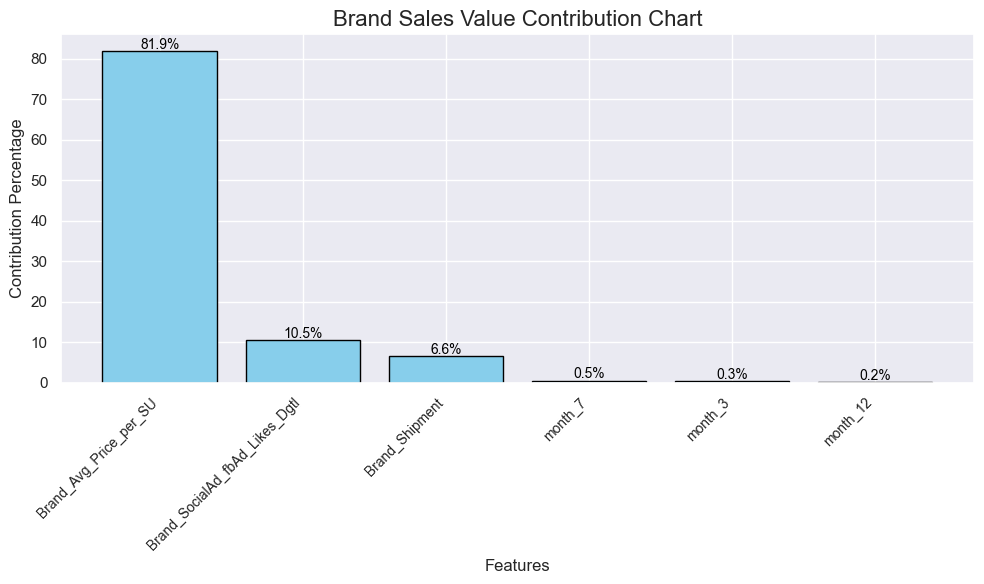


Feature Contributions for Brand Sales Value Contribution Chart:

Brand_Avg_Price_per_SU: 81.94%
Brand_SocialAd_fbAd_Likes_Dgtl: 10.51%
Brand_Shipment: 6.60%
month_7: 0.50%
month_3: 0.28%
month_12: 0.17%

--------------------------------------------------



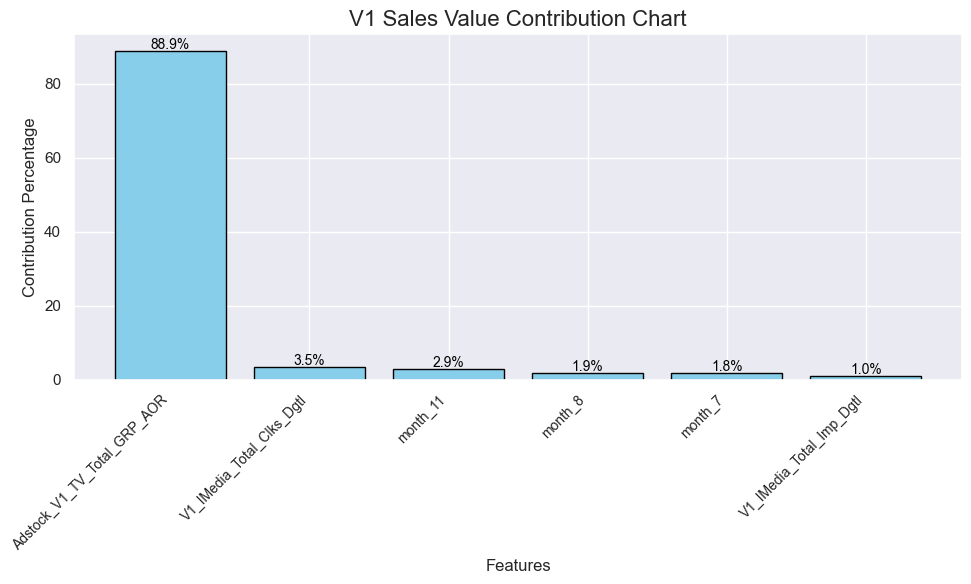


Feature Contributions for V1 Sales Value Contribution Chart:

Adstock_V1_TV_Total_GRP_AOR: 88.86%
V1_IMedia_Total_Clks_Dgtl: 3.45%
month_11: 2.94%
month_8: 1.93%
month_7: 1.85%
V1_IMedia_Total_Imp_Dgtl: 0.97%

--------------------------------------------------



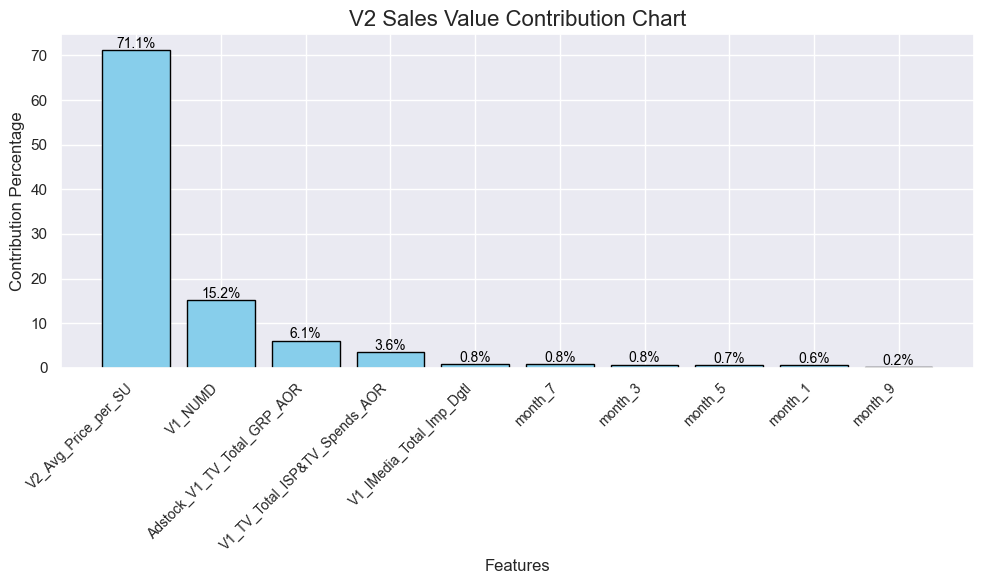


Feature Contributions for V2 Sales Value Contribution Chart:

V2_Avg_Price_per_SU: 71.15%
V1_NUMD: 15.17%
Adstock_V1_TV_Total_GRP_AOR: 6.14%
V1_TV_Total_ISP&TV_Spends_AOR: 3.60%
V1_IMedia_Total_Imp_Dgtl: 0.82%
month_7: 0.78%
month_3: 0.78%
month_5: 0.72%
month_1: 0.64%
month_9: 0.21%

--------------------------------------------------



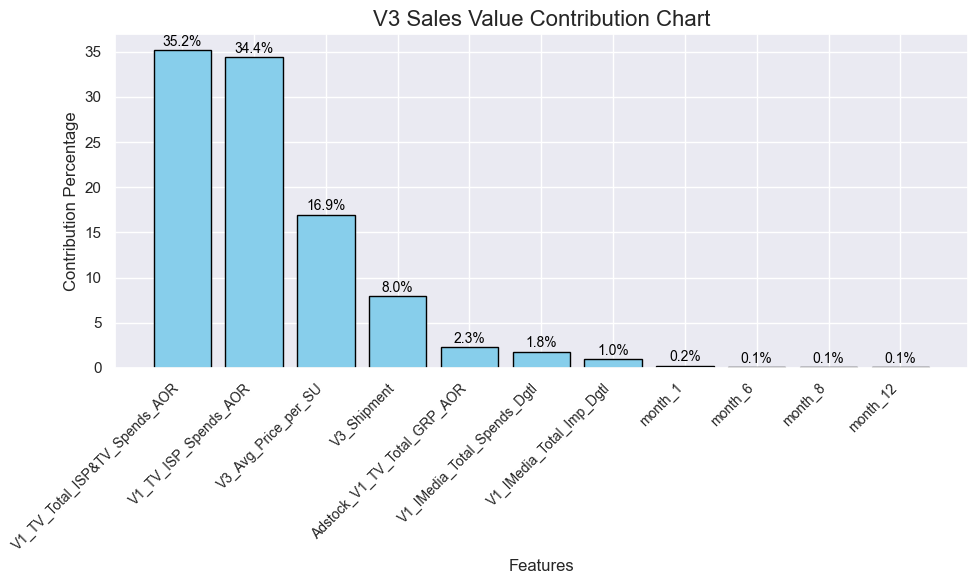


Feature Contributions for V3 Sales Value Contribution Chart:

V1_TV_Total_ISP&TV_Spends_AOR: 35.17%
V1_TV_ISP_Spends_AOR: 34.40%
V3_Avg_Price_per_SU: 16.93%
V3_Shipment: 7.96%
Adstock_V1_TV_Total_GRP_AOR: 2.28%
V1_IMedia_Total_Spends_Dgtl: 1.79%
V1_IMedia_Total_Imp_Dgtl: 0.99%
month_1: 0.23%
month_6: 0.10%
month_8: 0.09%
month_12: 0.07%

--------------------------------------------------



In [1406]:
# Function to calculate contribution percentages and plot descending histograms
def plot_feature_contributions(model, features, target_name, plot_title):
    # Train the model
    X = final_data[features]
    y = final_data[target_name]
    model.fit(X, y)
    
    # Get coefficients (absolute values) and calculate contributions
    coeffs = np.abs(model.coef_)  # Take absolute values of coefficients
    feature_averages = X.mean().values
    contributions = coeffs * feature_averages
    
    # Calculate percentage contributions
    total_contribution = np.sum(contributions)
    contribution_percentages = (contributions / total_contribution) * 100
    
    # Sort contributions in descending order
    sorted_indices = np.argsort(contribution_percentages)[::-1]  # Sort indices by descending order
    sorted_names = np.array(features)[sorted_indices]
    sorted_percentages = contribution_percentages[sorted_indices]
    
    # Create a descending histogram
    plt.figure(figsize=(10, 6))
    bars = plt.bar(
        sorted_names, sorted_percentages, color='skyblue', edgecolor='black', align='center'
    )
    
    # Annotate percentages above the bars
    for bar, percentage in zip(bars, sorted_percentages):
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # Position at the center of the bar
            bar.get_height() + 0.5,             # Position slightly above the bar
            f"{percentage:.1f}%",              # Display percentage with one decimal
            ha='center', fontsize=10, color='black'
        )
    
    # Add title and labels
    plt.title(plot_title, fontsize=16)
    plt.xlabel("Features", fontsize=12)
    plt.ylabel("Contribution Percentage", fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
    # Print the numerical values for reference
    print(f"\nFeature Contributions for {plot_title}:\n")
    for name, percentage in zip(sorted_names, sorted_percentages):
        print(f"{name}: {percentage:.2f}%")
    print("\n" + "-"*50 + "\n")

# Generate descending histograms for all models
def plot_all_feature_contributions():
    models = {
        "Brand_Sales_Value": (Lasso(alpha=1.0), "Brand Sales Value Contribution Chart"),
        "V1_Sales_Value": (Lasso(alpha=1.0), "V1 Sales Value Contribution Chart"),
        "V2_Sales_Value": (LinearRegression(), "V2 Sales Value Contribution Chart"),
        "V3_Sales_Value": (LinearRegression(), "V3 Sales Value Contribution Chart")
    }
    
    features = {
        "Brand_Sales_Value": [
            'Brand_Avg_Price_per_SU', 'Brand_Shipment', 'Brand_SocialAd_fbAd_Likes_Dgtl',
            'month_3', 'month_7', 'month_12'
        ],
        "V1_Sales_Value": [
            'V1_IMedia_Total_Clks_Dgtl', 'V1_IMedia_Total_Imp_Dgtl', 'Adstock_V1_TV_Total_GRP_AOR',
            'month_7', 'month_8', 'month_11'
        ],
        "V2_Sales_Value": [
            'V2_Avg_Price_per_SU', 'V1_TV_Total_ISP&TV_Spends_AOR', 'V1_NUMD', 
            'V1_IMedia_Total_Imp_Dgtl', 'Adstock_V1_TV_Total_GRP_AOR', 'month_1', 'month_3', 'month_7', 'month_5', 'month_9'
        ],
        "V3_Sales_Value": [
            'V3_Shipment', 'V3_Avg_Price_per_SU', 'V1_TV_Total_ISP&TV_Spends_AOR',
            'V1_TV_ISP_Spends_AOR', 'V1_IMedia_Total_Imp_Dgtl', 'Adstock_V1_TV_Total_GRP_AOR',
            'V1_IMedia_Total_Spends_Dgtl', 'month_1', 'month_6', 'month_8', 'month_12'
        ]
    }
    
    for target, (model, plot_title) in models.items():
        plot_feature_contributions(model, features[target], target, plot_title)

# Call the function to plot descending histograms
plot_all_feature_contributions()
